# Progetto di Machine Learning 2023

Il presente progetto riguarda la predizione dei prezzi delle case.

In [237]:
import matplotlib.pyplot as plt
import sm as sm
from pandas import Series, DataFrame

from feature_selection import *
from model_selection import *
from models import *
from grafici import *
from dataset import *
import pandas as pd
import numpy as np
import seaborn as sns
from typing import List, Tuple, Dict, Any
from pprint import pprint


In [238]:
from sklearn.model_selection import train_test_split

initial_training_set = pd.read_csv('../dataset/train.csv')

In [239]:
print(initial_training_set.shape)
print(initial_training_set.columns)

(1460, 81)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

Ci sono delle colonne, che anche se numeriche, in realtà corrispondono ad una descrizione; quindi, è opportuno cambiare il tipo da **int** a **object**:

In [240]:
columns_to_convert = ['MSSubClass', 'YrSold', 'GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'OverallCond', 'OverallQual']
initial_training_set[columns_to_convert] = initial_training_set[columns_to_convert].astype('object')

Suddividiamo le colonne in numeriche e categoriche:

In [241]:
numerical_cols = initial_training_set.select_dtypes(include='number').columns.to_list()
numerical_train = initial_training_set[numerical_cols]
print(numerical_cols)

['Id', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SalePrice']


Verifichiamo il tipo delle colonne:

In [242]:
categorical_cols = initial_training_set.select_dtypes(include='object').columns.to_list()
categorical_train = initial_training_set[categorical_cols]
print(categorical_cols)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'YrSold', 'SaleType', 'SaleCondition']


# 1. Data Exploration

Sono state confrontate tutte le feature con il target. Per i dettagli fare riferimento ai file dataset/valutazioneFeatures.csv e valutazioneFeatures.ipynb.

## 1.1 Matrice di correlazione

Le feature più importanti sono le seguenti:

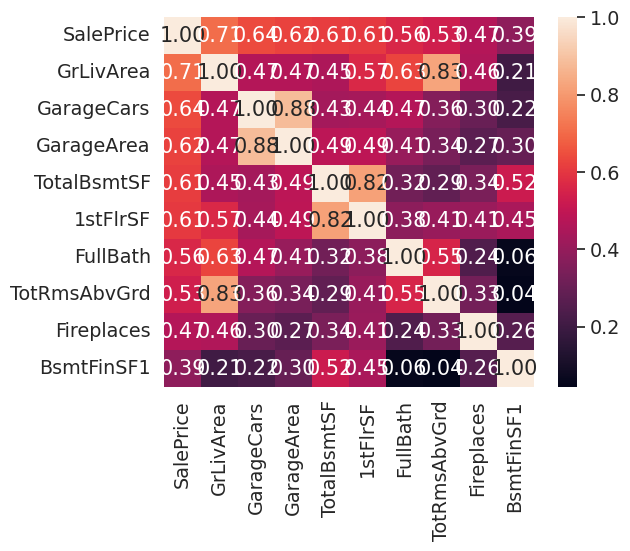

In [243]:
def correlation_matrix_plot(df_train: DataFrame, k=10):
    # saleprice correlation matrix
    corrmat = df_train.corr()
    cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
    cm = np.corrcoef(df_train[cols].values.T)
    sns.set(font_scale=1.25)
    sns.heatmap(cm,
                cbar=True,  # mostra la legenda a destra
                annot=True,  # mostra i valori nelle celle
                square=True,  # se True mostra il grafico come un quadrato
                fmt='.2f',  # formatta il numero di cifre decimali delle 'annot'
                yticklabels=cols.values,  # mostra le label dell'asse y
                xticklabels=cols.values  # mostra le label dell'asse x
                )
    plt.show()


columns_int = initial_training_set.select_dtypes(include='int64').columns
correlation_matrix_plot(initial_training_set[columns_int], k=10)

Analizziamo la heatmap:
- Sulla diagonale c'è sempre 1 perché le features sono in correlazione con loro stesse.
- Garage Cars e Garage Area sono molto correlate tra loro, quindi si può mantenere solamente quella che è più correlata con il SalePrice, ovvero **GarageCars**.
- TotRmsAbvGrd e GrLivArea sono anche loro molto correlate tra loro, la più importante però è **GrLivArea**.
- 1stFlrSF è correlata con **TotalBsmtSF**, ma è più importante quest'ultima.

Per essere più precisi, visualizziamo la heatmap con le sole feature che hanno valore di correlazione con almeno un altra feature superiore a una certa soglia.

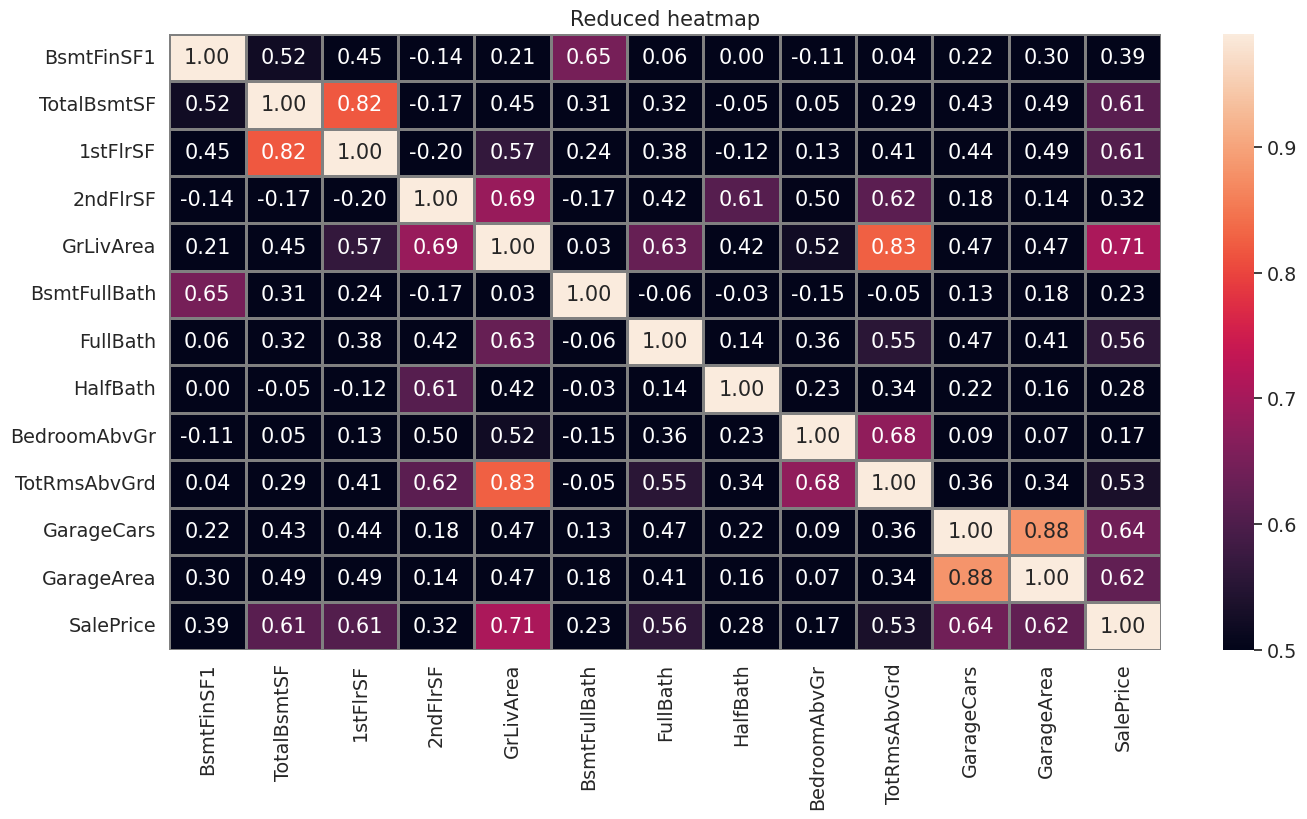

In [244]:
def correlazione_matrice(df_train: DataFrame, threshold: float, val_max: float):
    """Calcola la matrice di correlazione (ndarray) a partire da un dataframe di feature tutte numeriche"""
    corr = df_train.corr().to_numpy()
    # seleziona gli elementi che sono compresi tra il threshold e un valore massimo
    ind_x, = np.where(np.all(np.logical_or(corr < threshold, corr > val_max), axis=0))
    corr = np.delete(corr, ind_x, 1)  # si eliminano

    # stessa cosa per le righe
    ind_y, = np.where(np.all(np.logical_or(corr < threshold, corr > val_max), axis=1))
    corr = np.delete(corr, ind_y, 0)
    # si aggiornano le colonne selezionando solamente quelle filtrate

    return corr, ind_x, ind_y


def correlation_matrix_filtered_plot(df_train: DataFrame, threshold=0.6):
    # threshold: valore minimo di correlazione da considerare
    val_max = 0.99
    # si selezionano le colonne
    labels = df_train.columns
    corr, ind_x, ind_y = correlazione_matrice(df_train, threshold, val_max)
    # si aggiornano le colonne selezionando solamente quelle filtrate
    map_labels_x = [item for i, item in enumerate(labels) if i not in ind_x]
    map_labels_y = [item for i, item in enumerate(labels) if i not in ind_y]
    # plot heatmap
    plt.figure(figsize=(16, 8))
    heatmap = sns.heatmap(corr, annot=True, fmt='.2f',
                          xticklabels=map_labels_x,
                          yticklabels=map_labels_y,
                          vmin=threshold,
                          vmax=val_max,
                          linewidths=1.0,
                          linecolor="grey")

    heatmap.set_title("Reduced heatmap")
    plt.show()


correlation_matrix_filtered_plot(numerical_train, 0.5)

Ora troviamo le coppie feature con correlazione maggiore di 0.6 e prendiamo anche il valore di correlazione di ciascuna con il SalePrice:

In [245]:
def correlazione_dataframe(df_train, threshold, val_max):
    # si selezionano le colonne
    labels = df_train.columns

    corr, ind_x, ind_y = correlazione_matrice(df_train, threshold, val_max)
    map_labels_x = [item for i, item in enumerate(labels) if i not in ind_x]
    map_labels_y = [item for i, item in enumerate(labels) if i not in ind_y]

    return pd.DataFrame(corr, columns=map_labels_x, index=map_labels_y)


class Correlazione:
    def __init__(self, feature1, feature2, correlazione, correlazione_f1_target, correlazione_f2_target):
        self.feature1 = feature1
        self.feature2 = feature2
        self.correlazione = correlazione
        self.correlazione_f1_target = correlazione_f1_target
        self.correlazione_f2_target = correlazione_f2_target

    def __str__(self):
        return f"({self.feature1, self.feature2, self.correlazione, self.correlazione_f1_target, self.correlazione_f2_target})"

    def __repr__(self):
        return f"({self.feature1, self.feature2, self.correlazione, self.correlazione_f1_target, self.correlazione_f2_target})"

    def __gt__(self, other):
        return self.correlazione > other.correlazione

    def __lt__(self, other):
        return self.correlazione < other.correlazione


def feature_in_correlazione(corr: DataFrame, thresh: float) -> List[Correlazione]:
    colonne = corr.columns
    corr_list = []
    target_index = len(colonne) - 1
    # per ogni riga del dataframe della matrice di correlazione
    for (i, r) in enumerate(corr):
        # e per ogni colonna
        for (j, c) in enumerate(corr[r]):
            # se una coppia di feature diverse ha correlazione elevata, la aggiungiamo alla lista
            if c > thresh and i != j and colonne[i] != "SalePrice" and colonne[j] != "SalePrice":
                # calcoliamo la correlazione delle due feature con la colonna target
                corr_f1_target = corr.iloc[i, target_index]
                corr_f2_target = corr.iloc[j, target_index]
                corr_list.append(Correlazione(colonne[i], colonne[j], c, corr_f1_target, corr_f2_target))

    corr_list.sort()
    return corr_list


min_correlation = 0.6
# trasformo la matrice di correlazione di tutto il dataset in un dataframe
corr = correlazione_dataframe(numerical_train, min_correlation, 0.99)
# poi stampo la lista di feature in correlazione
feature_correlate = feature_in_correlazione(corr, min_correlation)
pprint(feature_correlate)

[(('2ndFlrSF', 'HalfBath', 0.6097073002717436, 0.31933380283206736, 0.28410767559478256)),
 (('HalfBath', '2ndFlrSF', 0.6097073002717436, 0.28410767559478256, 0.31933380283206736)),
 (('2ndFlrSF', 'TotRmsAbvGrd', 0.6164226354915431, 0.31933380283206736, 0.5337231555820284)),
 (('TotRmsAbvGrd', '2ndFlrSF', 0.6164226354915431, 0.5337231555820284, 0.31933380283206736)),
 (('GrLivArea', 'FullBath', 0.6300116462511148, 0.7086244776126515, 0.5606637627484453)),
 (('FullBath', 'GrLivArea', 0.6300116462511148, 0.5606637627484453, 0.7086244776126515)),
 (('BsmtFinSF1', 'BsmtFullBath', 0.6492117535742649, 0.3864198062421535, 0.22712223313149427)),
 (('BsmtFullBath', 'BsmtFinSF1', 0.6492117535742649, 0.22712223313149427, 0.3864198062421535)),
 (('BedroomAbvGr', 'TotRmsAbvGrd', 0.676619935742649, 0.16821315430073963, 0.5337231555820284)),
 (('TotRmsAbvGrd', 'BedroomAbvGr', 0.676619935742649, 0.5337231555820284, 0.16821315430073963)),
 (('2ndFlrSF', 'GrLivArea', 0.6875010641666033, 0.31933380283206

Quindi troviamo le feature che hanno correlazione maggiore con il SalePrice:

In [246]:
best_features = set()
worst_features = set()
for c in feature_correlate:
    c: Correlazione = c
    if c.correlazione_f1_target > c.correlazione_f2_target:
        best_features.add((c.feature1, c.correlazione_f1_target))
        worst_features.add(c.feature2)
    else:
        best_features.add((c.feature2, c.correlazione_f2_target))
        worst_features.add(c.feature1)

best_features_list = list(best_features)
worst_features_list = list(worst_features)
best_features_list.sort(key=lambda x: x[1], reverse=True)
pprint(best_features_list)
print("feature correlate con altre: ", worst_features_list)

[('GrLivArea', 0.7086244776126515),
 ('GarageCars', 0.6404091972583519),
 ('TotalBsmtSF', 0.6135805515591943),
 ('TotRmsAbvGrd', 0.5337231555820284),
 ('BsmtFinSF1', 0.3864198062421535),
 ('2ndFlrSF', 0.31933380283206736)]
feature correlate con altre:  ['BedroomAbvGr', '1stFlrSF', 'FullBath', 'GarageArea', 'TotRmsAbvGrd', '2ndFlrSF', 'BsmtFullBath', 'HalfBath']


## 1.2 Distribuzione normale

Confrontiamo le feature migliori che hanno un'alta correlazione con il valore target:


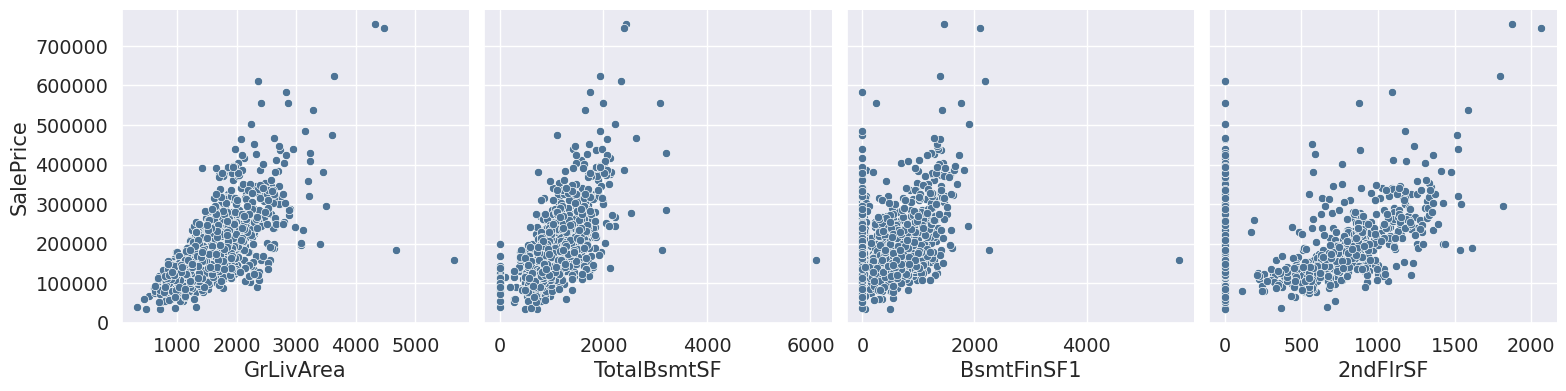

In [247]:
features_pair_plot = ['GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', '2ndFlrSF']
sns.pairplot(initial_training_set, x_vars=features_pair_plot, y_vars="SalePrice", height=4, diag_kind='kde',
             plot_kws=dict(color='xkcd:cadet blue'),
             diag_kws=dict(fill=True, alpha=.7, color='xkcd:pale orange'))

Sembrerebbe che le feature abbiano un andamento lineare.

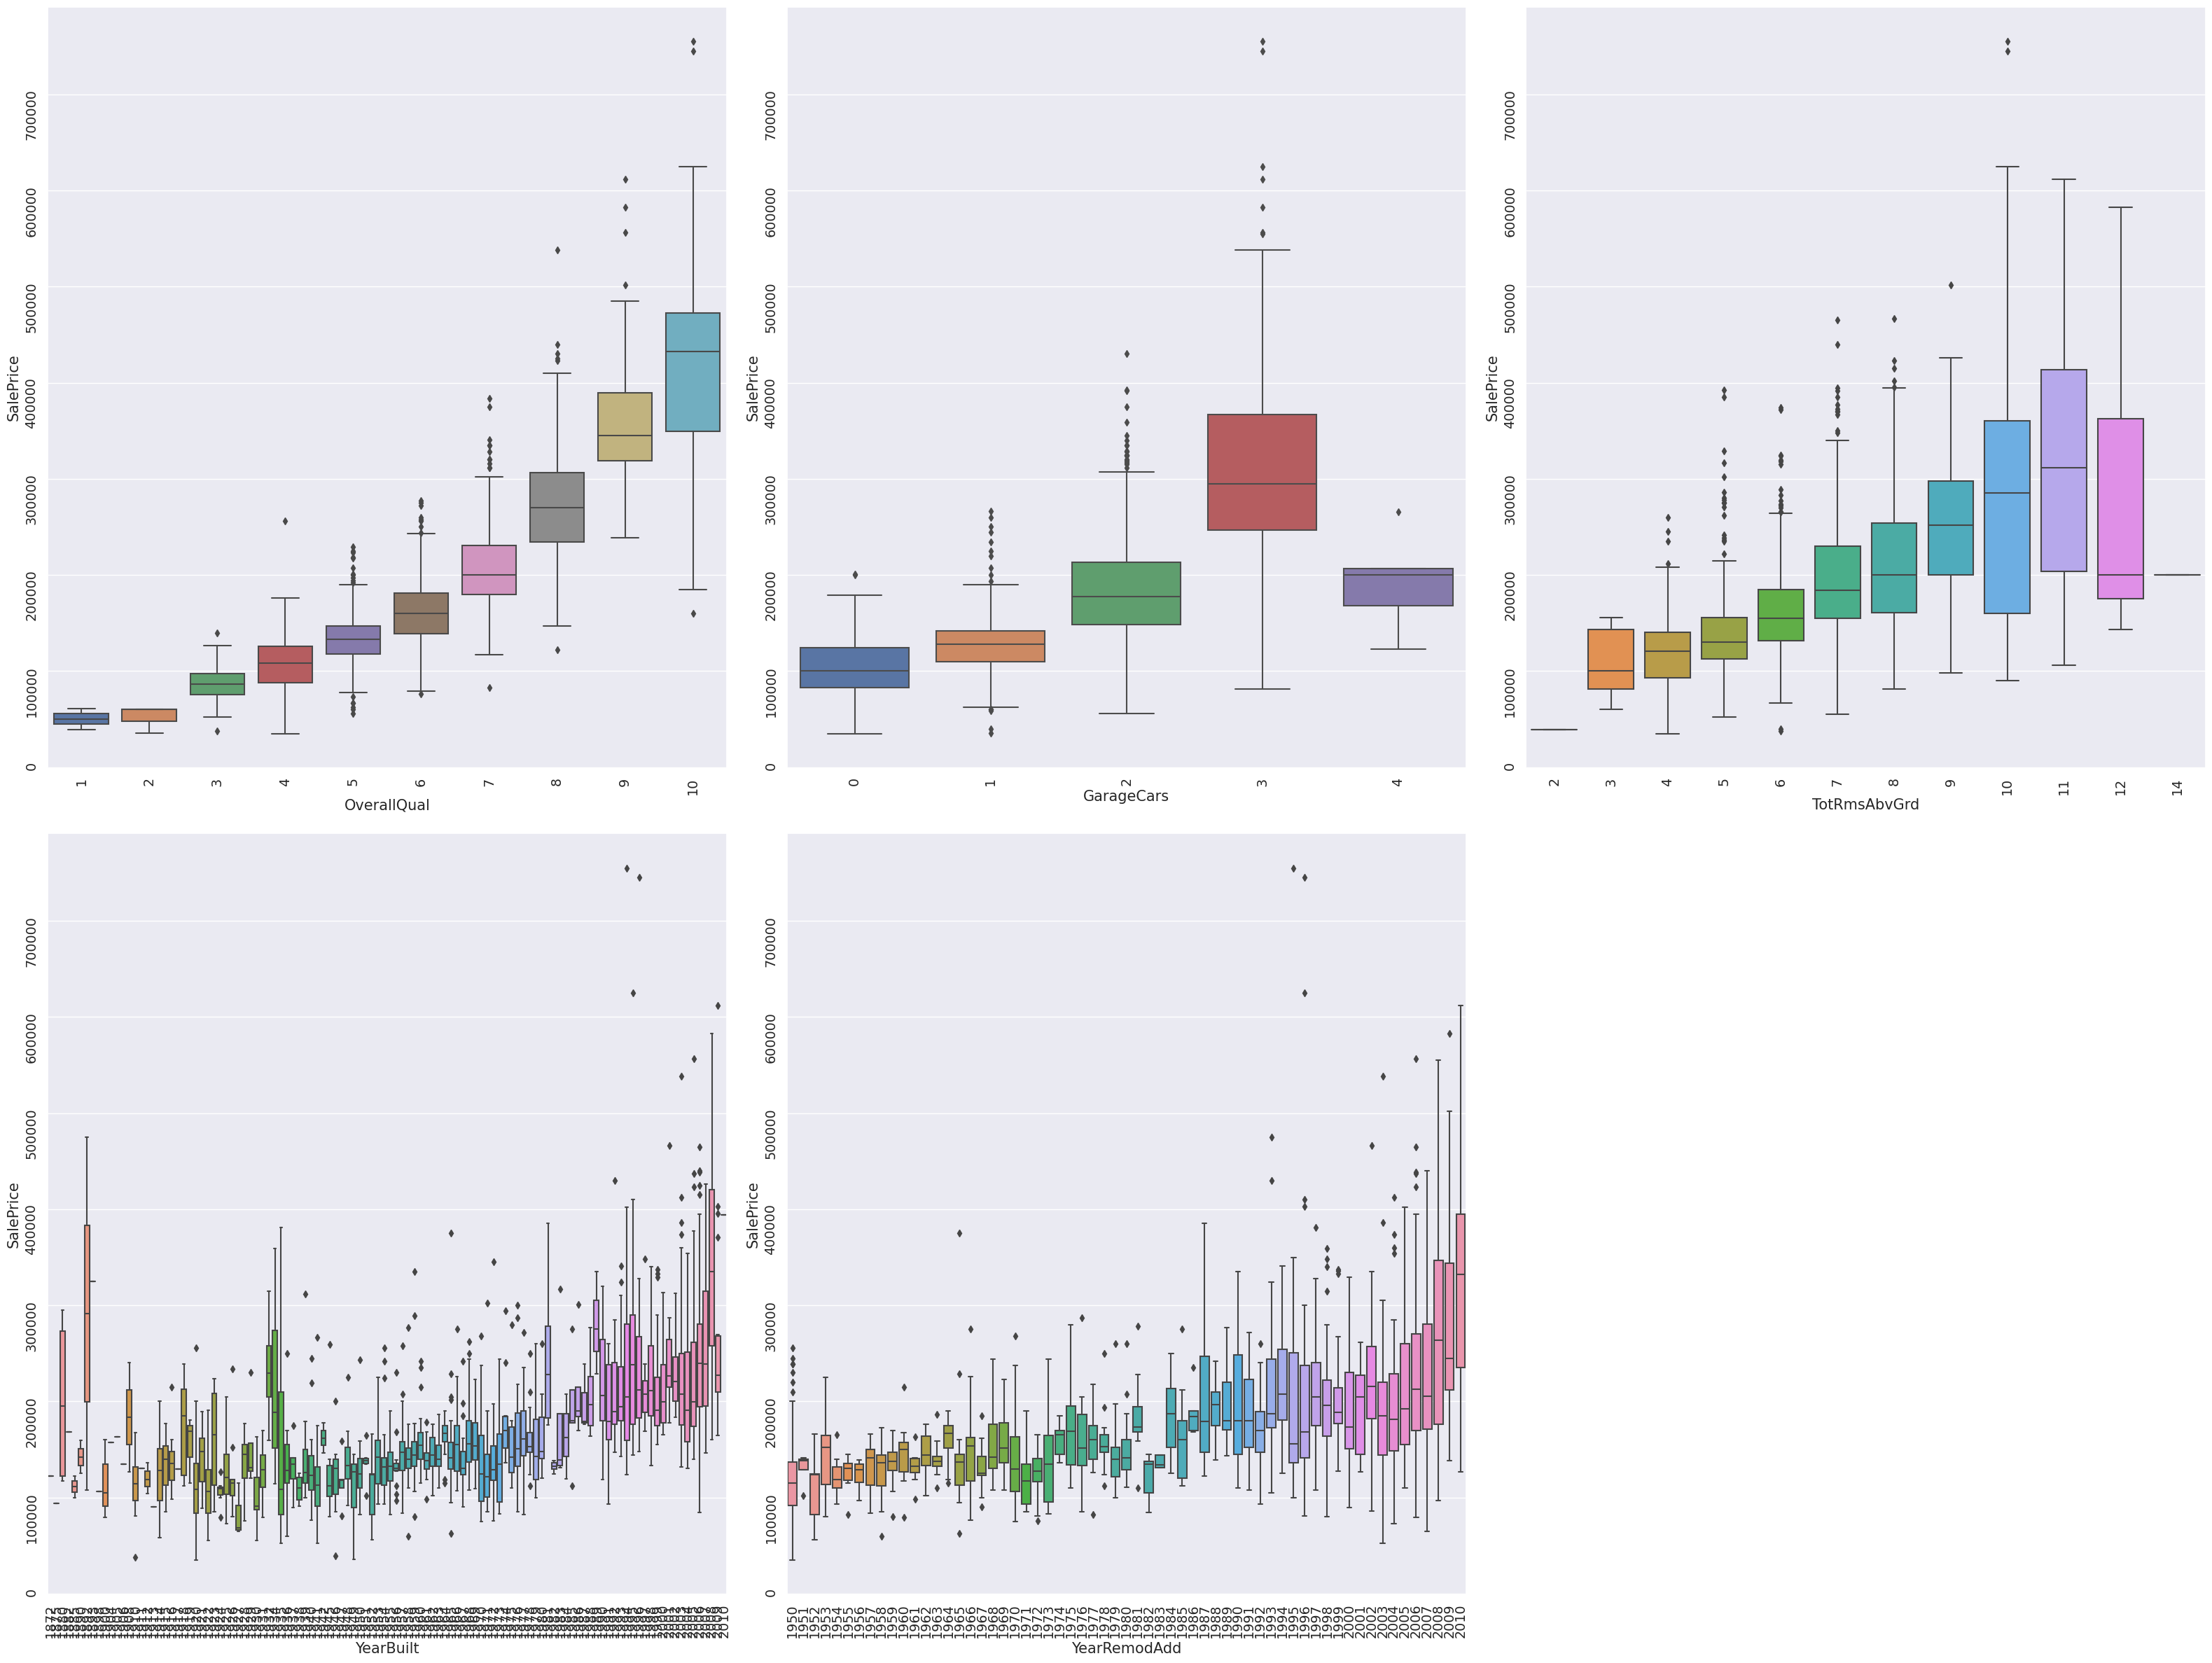

In [248]:
features_box_plot = ['OverallQual', 'GarageCars', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']

axis_x = 0
axis_y = 0
fig, axes = plt.subplots(2, 3, figsize=(32, 24))
for fbp in features_box_plot:
    f = sns.boxplot(ax=axes[axis_x, axis_y], data=initial_training_set, x=fbp, y='SalePrice')
    f.axis(ymin=0, ymax=800000)
    axes[axis_x, axis_y].tick_params(rotation=90)
    axes[axis_x, axis_y].autoscale(enable=True)
    fig.tight_layout()
    if axis_y == 2:
        axis_x = 1
        axis_y = 0
    else:
        axis_y += 1

fig.delaxes(axes[axis_x][2])

Possiamo notare che *'OverallQual'* influisce molto sul prezzo, infatti all'aumentare della qualità aumenta anche il prezzo delle case; mentre, sulle altre feature non influisce molto come la prima.

Studiamo se le feature hanno una distribuzione normale.

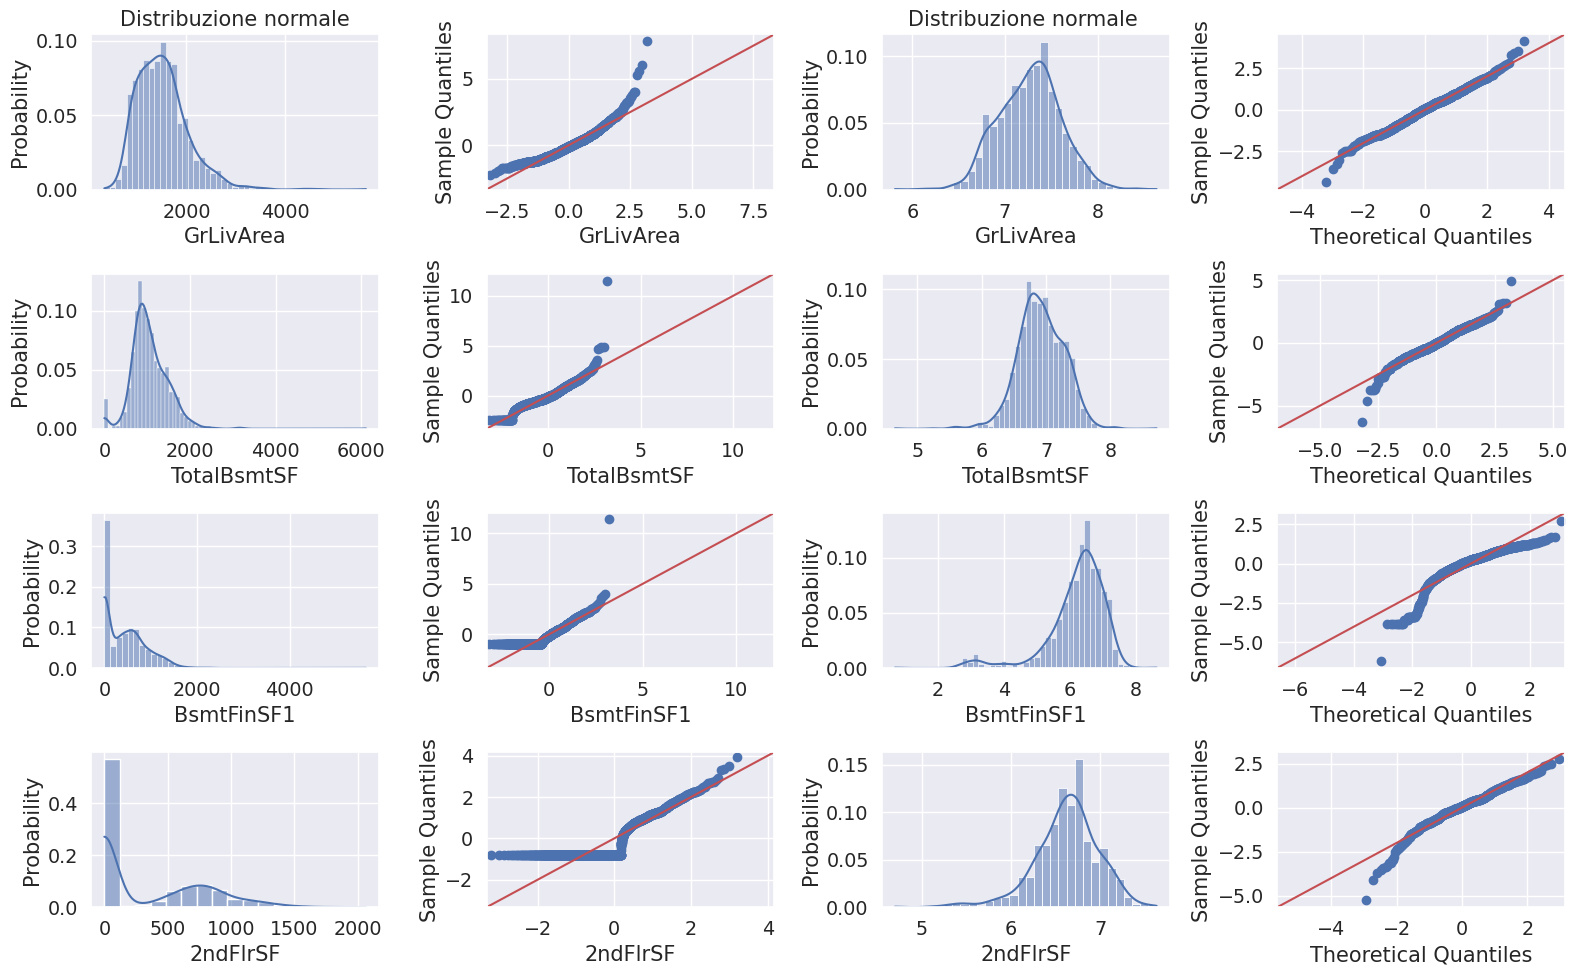

In [249]:
import statsmodels.api as sm


def distribution_plot(train_df: DataFrame, features: str):
    fig, axes = plt.subplots(features.__len__(), 4, figsize=(16, 10))
    axis = 0
    for feature in features:
        sns.histplot(ax=axes[axis, 0], data=train_df, x=feature, kde=True, stat="probability")
        sm.qqplot(ax=axes[axis, 1], data=train_df[feature], line='45', fit=True)
        # in questo caso si considerano valori > 0
        sns.histplot(ax=axes[axis, 2], data=np.log(train_df[train_df[feature] > 0][feature]),
                     kde=True, stat="probability")
        sm.qqplot(ax=axes[axis, 3], data=np.log(train_df[train_df[feature] > 0][feature]), line='45', fit=True)
        axes[0, 0].set_title("Distribuzione normale")
        axes[0, 2].set_title("Distribuzione normale ")
        axes[axis, 0].set_xlabel(feature)
        axes[axis, 1].set_xlabel(feature)
        plt.tight_layout()
        axis += 1


distribution_plot(initial_training_set, features_pair_plot)

E' possibile notare che in:
- **'GrLiveArea'**, ci sono più outliers, rispetto agli altri, e non si ha una distribuzione normale. Effettuando la trasformazione dei dati attraverso una *trasformazione log* si ottiene una distribuzione normale.

# 2. Data cleaning
Analizziamo il dataset per eliminare i valori nulli. In particolare adottiamo la seguente politica:
- se i valori nulli sono maggiori del 80% degli elementi del training set, eliminiamo la feature.
- altrimenti, se la feature è numerica, sostituiamo il valore nullo con il valore medio.
- altrimenti, se la feature è categorica, sostituiamo il valore nullo con il valore più comune.

Questo passaggio è necessario per il corretto funzionamento dei metodi di feature selection, feature extraction e per i modelli di machine learning che utilizzeremo.

## 2.1 Rimozione delle colonne con molti valori nulli
Innanzitutto realizziamo un grafico con le features che hanno almeno un valore nullo:

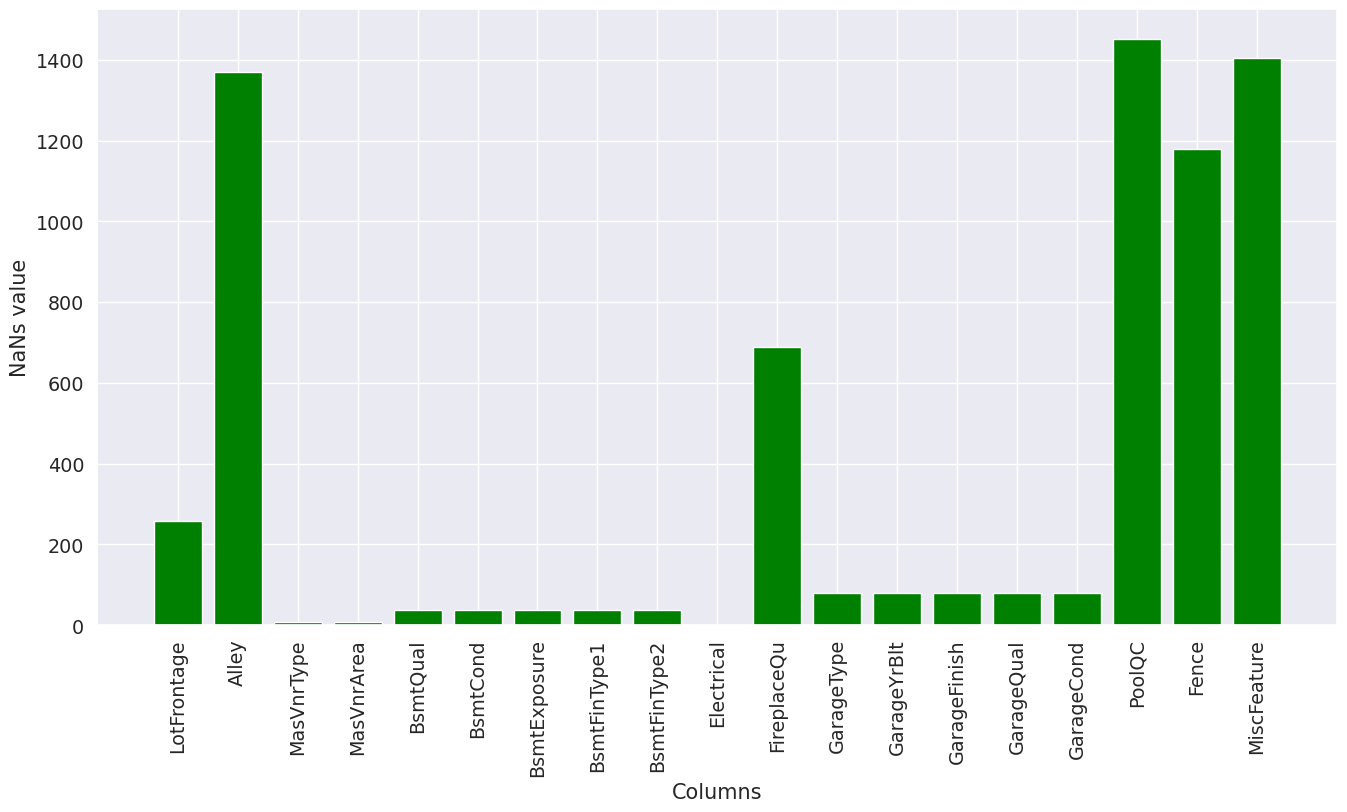

Colonne con valori nulli:  19


In [250]:
def get_nan_cols(dataset: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Index]:
    """ Restituisce:
        0: un dataframe con nome colonna, numero null
        1: una lista (Index) con i nomi delle colonne che hanno valori nulli
    """
    count_nan = dataset.isnull().sum(axis=0)
    columns_with_nan_df = count_nan.loc[count_nan != 0]
    nan_cols_names = dataset.columns[dataset.isna().any()]
    return columns_with_nan_df, nan_cols_names


def get_cols_with_nan_number(dataset: pd.DataFrame):
    print("Colonne con valori nulli: ", len(get_nan_cols(dataset)[1].to_list()))


def check_nan_value(dataset):
    # Verifichiamo se ci sono valori NaN
    columns_with_nan_df, nan_cols_names = get_nan_cols(dataset)
    pd.DataFrame(data=nan_cols_names)
    plt.figure(figsize=(16, 8))
    plt.bar(nan_cols_names, columns_with_nan_df, color="green")
    plt.xlabel("Columns")
    plt.xticks(rotation=90)
    plt.ylabel("NaNs value")
    plt.show()


check_nan_value(initial_training_set)
get_cols_with_nan_number(initial_training_set)

Notiamo che ci sono 19 colonne che hanno almeno un valore nullo. In particolare: **Alley**, **PoolQC**, **Fence** e **MiscFeature** hanno più dell'85% di valori nulli, quindi le **eliminiamo**

Numero di valori non nulli minimo:  293


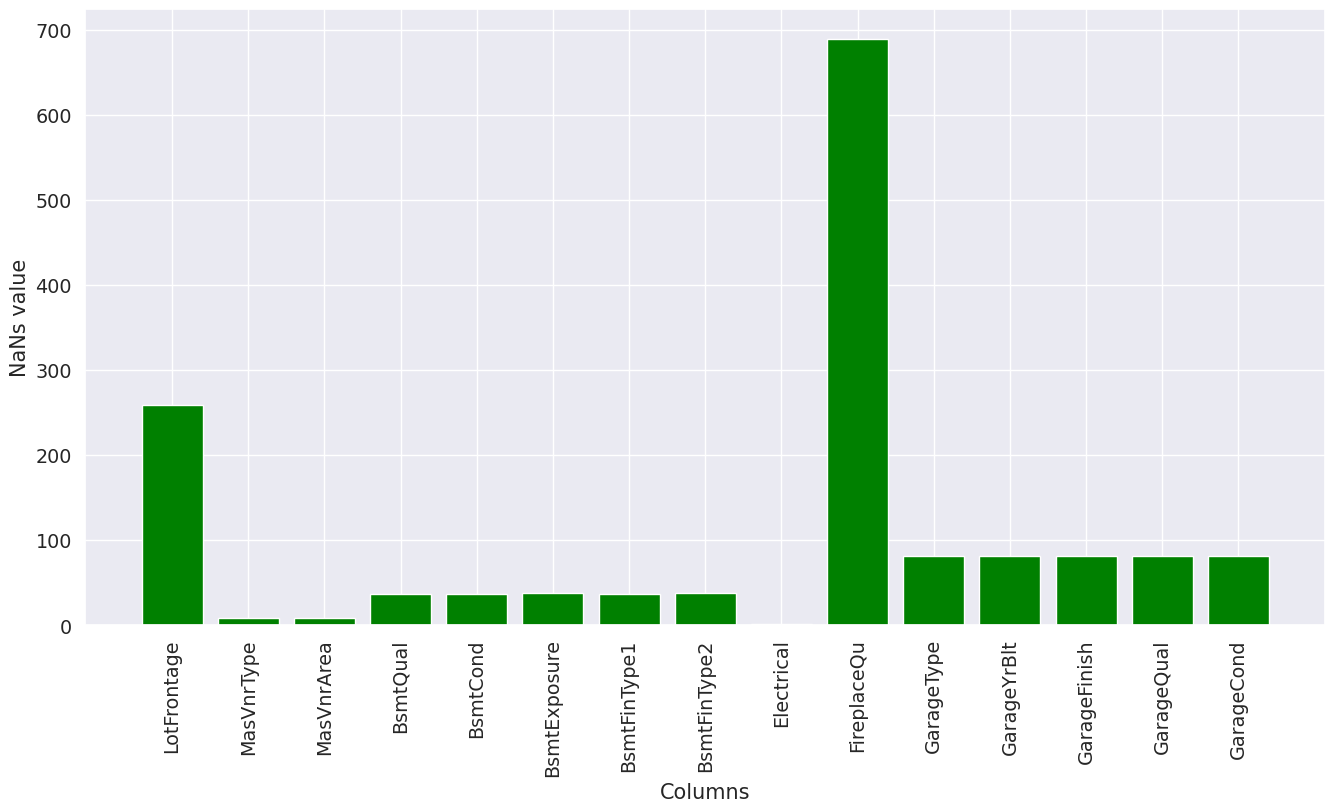

Colonne con valori nulli:  15


In [251]:
def remove_nan_columns(dataset: DataFrame, threshold=20) -> DataFrame:
    """Elimina colonne con valori NaN quando i valori Nan sono superiori a [threshold]%"""
    thresh = int((len(dataset) * threshold) / 100) + 1
    print("Numero di valori non nulli minimo: ", thresh)
    # axis: specifichiamo di eliminare solo le colonne; thresh: numero minimo per eliminare
    dataset.dropna(axis='columns', thresh=thresh, inplace=True)
    return dataset


initial_training_set2 = remove_nan_columns(initial_training_set)
check_nan_value(initial_training_set2)  # senza troppi valori nulli
get_cols_with_nan_number(initial_training_set2)

## 2.2 Sostituzione dei valori nulli nelle feature numeriche

Consideriamo le colonne numeriche dopo aver eliminato le colonne con valori NaN:


In [252]:
numerical_cols = initial_training_set2.select_dtypes(include='number').columns.to_list()
numerical_train = initial_training_set2[numerical_cols]
print(numerical_cols)

['Id', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SalePrice']


L'Id non ci serve, quindi lo togliamo:

In [253]:
if len(numerical_cols) > 0 and numerical_cols[0] == 'Id':
    del numerical_cols[0]
numerical_train = numerical_train.drop(['Id'], axis=1, errors='ignore')
initial_training_set2 = initial_training_set2.drop(['Id'], axis=1, errors='ignore')

Sostituiamo alle colonne numeriche del training set `initial_training_set2` a cui abbiamo eliminato le colonne con oltre l'80% dei valori nulli, la media dei valori al posto dei rimanenti valori NaN

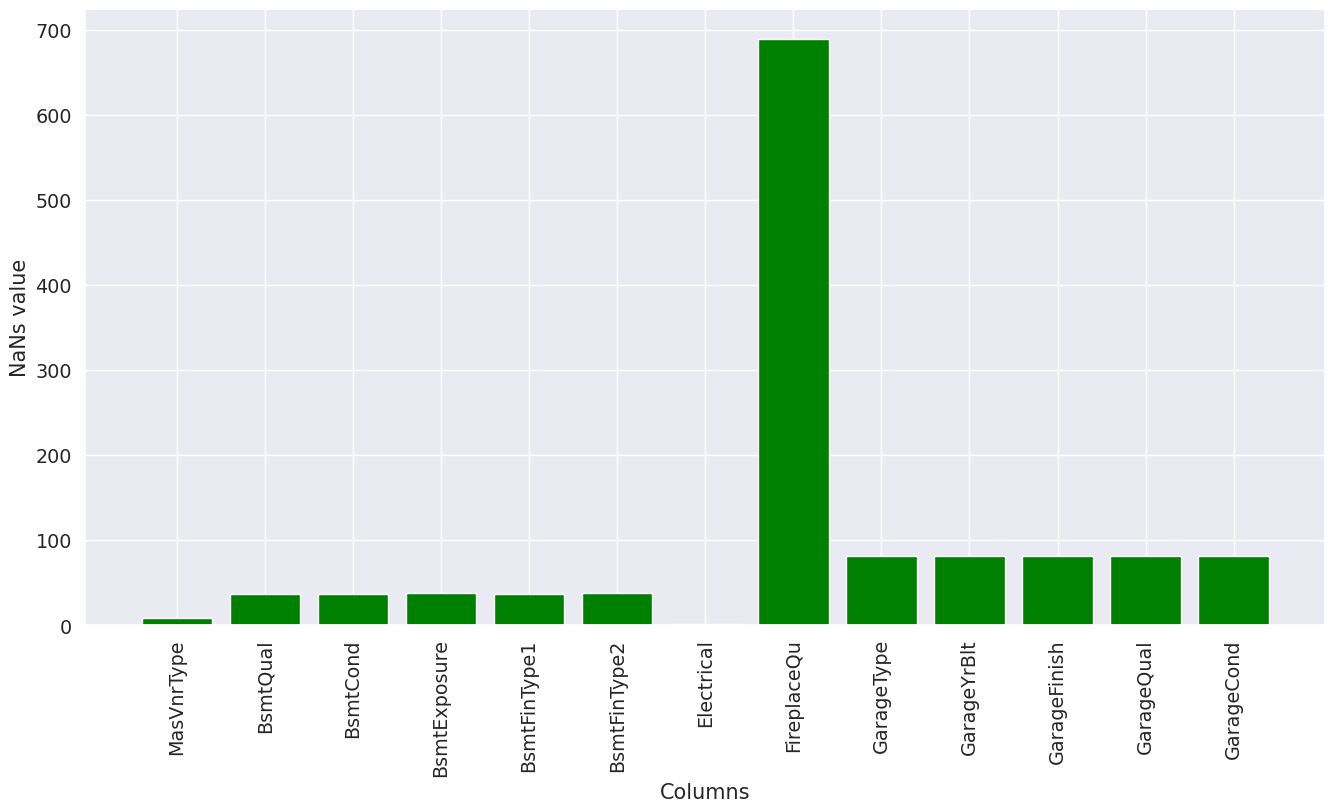

Colonne con valori nulli:  13
     MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0            60       RL         65.0     8450   Pave      Reg         Lvl   
1            20       RL         80.0     9600   Pave      Reg         Lvl   
2            60       RL         68.0    11250   Pave      IR1         Lvl   
3            70       RL         60.0     9550   Pave      IR1         Lvl   
4            60       RL         84.0    14260   Pave      IR1         Lvl   
...         ...      ...          ...      ...    ...      ...         ...   
1455         60       RL         62.0     7917   Pave      Reg         Lvl   
1456         20       RL         85.0    13175   Pave      Reg         Lvl   
1457         70       RL         66.0     9042   Pave      Reg         Lvl   
1458         20       RL         68.0     9717   Pave      Reg         Lvl   
1459         20       RL         75.0     9937   Pave      Reg         Lvl   

     Utilities LotConfig LandSlop

In [254]:
initial_training_set2 = initial_training_set2.fillna(initial_training_set2[numerical_cols].mean())
check_nan_value(initial_training_set2)  # senza troppi valori nulli
get_cols_with_nan_number(initial_training_set2)
print(initial_training_set2)

Bisogna avere per le colonne numeriche tutti lo stesso tipo; infatti, ci sono delle colonne che hanno tipo **float64** e li convertiamo in **int64**:

In [255]:
columns_float = initial_training_set2[numerical_cols].astype('float64').columns
initial_training_set2[columns_float] = initial_training_set2[columns_float].astype('int64')
print(initial_training_set2[numerical_cols].dtypes)

LotFrontage      int64
LotArea          int64
MasVnrArea       int64
BsmtFinSF1       int64
BsmtFinSF2       int64
BsmtUnfSF        int64
TotalBsmtSF      int64
1stFlrSF         int64
2ndFlrSF         int64
LowQualFinSF     int64
GrLivArea        int64
BsmtFullBath     int64
BsmtHalfBath     int64
FullBath         int64
HalfBath         int64
BedroomAbvGr     int64
KitchenAbvGr     int64
TotRmsAbvGrd     int64
Fireplaces       int64
GarageCars       int64
GarageArea       int64
WoodDeckSF       int64
OpenPorchSF      int64
EnclosedPorch    int64
3SsnPorch        int64
ScreenPorch      int64
PoolArea         int64
MiscVal          int64
MoSold           int64
SalePrice        int64
dtype: object


## 2.3 Sostituzione dei valori nulli nelle feature categoriche

Per prima cosa prendiamo le colonne categoriche

In [256]:
categorical_cols = initial_training_set2.select_dtypes(include='object').columns.to_list()
categorical_train = initial_training_set2[categorical_cols]
print(categorical_cols)

['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'YrSold', 'SaleType', 'SaleCondition']


Sostituiamo alle colonne **categoriche** del training set `initial_training_set2` a cui abbiamo eliminato le colonne con oltre l'80% dei valori nulli e i valori nulli delle colonne numeriche, la moda dei valori al posto dei rimanenti valori NaN.

In [257]:
mode = categorical_train.mode()
print(f"Valori più frequenti\n{mode.iloc[0]}\n\n")
initial_training_set2 = initial_training_set2.fillna(mode.iloc[0])
get_cols_with_nan_number(initial_training_set2)

Valori più frequenti
MSSubClass            20
MSZoning              RL
Street              Pave
LotShape             Reg
LandContour          Lvl
Utilities         AllPub
LotConfig         Inside
LandSlope            Gtl
Neighborhood       NAmes
Condition1          Norm
Condition2          Norm
BldgType            1Fam
HouseStyle        1Story
OverallQual            5
OverallCond            5
YearBuilt           2006
YearRemodAdd        1950
RoofStyle          Gable
RoofMatl         CompShg
Exterior1st      VinylSd
Exterior2nd      VinylSd
MasVnrType          None
ExterQual             TA
ExterCond             TA
Foundation         PConc
BsmtQual              TA
BsmtCond              TA
BsmtExposure          No
BsmtFinType1         Unf
BsmtFinType2         Unf
Heating             GasA
HeatingQC             Ex
CentralAir             Y
Electrical         SBrkr
KitchenQual           TA
Functional           Typ
FireplaceQu           Gd
GarageType        Attchd
GarageYrBlt       2005.0
Gara

## 2.4 Rimozione delle colonne correlate
Eliminiamo colonne che sono molto correlare con altre e il target 'SalePrice':

In [258]:
print(len(initial_training_set2.columns))
initial_training_set3 = initial_training_set2.drop(columns=worst_features_list, axis=1)
print(len(initial_training_set3.columns))

76
68


Si passa ad avere un dataset con 76 colonne a 68.

# 2. Preprocessing
Trasformiamo tutte le colonne categoriche in numeriche.
- Se la colonna categorica rappresenta una valutazione, usiamo l'ordinal encoding
- Altrimenti usiamo one-hot encoding (one-of-k). In tal caso le feature aumenteranno quindi bisogna controllare il numero di colonne finale.

Per prima cosa determiniamo le colonne categoriche che vanno trasformate con l'**ordinal encoding** e quelle che vanno trasformate con l'one hot encoding, a partire dal file `valutazioneFeature.csv`.

In [259]:
features_year = [
    'YrSold',
    'GarageYrBlt',
    'YearRemodAdd',
    'YearBuilt'
]

Le features che corrispondo ad **anni** sono state trasformate in range di anni, per ridurre il numero di feature dopo OneHotEncoder.

In [260]:
def trasforma_range_anni(dataset: DataFrame, features: List[str], start_year, end_year_inclusive, range_step):
    # start_range = range(1900, 2041, 20)
    # end_range = range(1920, 2041, 20)
    start_range = range(start_year, end_year_inclusive+1, range_step)
    end_range = range(start_year+range_step, end_year_inclusive+1, range_step)
    range_labels = []
    for i in range((end_year_inclusive-start_year) // range_step):
        range_labels.append(str(start_range[i])+"-"+str(end_range[i]))

    for f in features:
        dataset[f] = pd.cut(dataset[f], bins=list(start_range), labels=range_labels)
    return dataset


initial_training_set4 = trasforma_range_anni(initial_training_set3, features_year, 1900, 2100, 100)
# TypeError: '<' not supported between instances of 'int' and 'str' -> Eseguire la cella prima che inizializza initial_training_set3


In [261]:
ordinal_enc_cols = [
    'OverallCond',
    'OverallQual',
    "ExterQual",
    "KitchenQual",
    "ExterCond",
    "HeatingQC",
    "BsmtCond",
    "BsmtFinType1",
    "BsmtFinType2",
    "GarageCond",
    "BsmtExposure",
    "GarageQual",
    "FireplaceQu",
    "BsmtQual"
]

onehot_enc_cols = [
    'YrSold',
    'GarageYrBlt',
    'YearRemodAdd',
    'YearBuilt',
    'MSSubClass',
    "MSZoning",
    "Condition1",
    "Electrical",
    "Functional",
    "Utilities",
    "Condition2",
    "Exterior1st",
    "BldgType",
    "CentralAir",
    "Exterior2nd",
    "Heating",
    "HouseStyle",
    "RoofMatl",
    "Street",
    "LotConfig",
    "Neighborhood",
    "LandSlope",
    "Foundation",
    "LandContour",
    "MasVnrType",
    "PavedDrive",
    "RoofStyle",
    "SaleType",
    "GarageFinish",
    "GarageType",
    "LotShape",
    "SaleCondition"
]


## 3.1 Ordinal encoding

Eseguiamo prima l'ordinal encoding:

In [262]:
def ordinal_encoding(dataset: DataFrame, ord_enc_cols: List[str]) -> DataFrame:
    # applica l'ordinal Encoding alle colonne categoriche che rappresentano una valutazione
    copy = dataset.copy()
    for cat in ord_enc_cols:
        copy[cat], _ = pd.factorize(dataset[cat])

    return copy


initial_training_set5 = ordinal_encoding(initial_training_set4, ordinal_enc_cols)

print("Alcune delle colonne prima e dopo l'ordinal encoding")
print(initial_training_set4[ordinal_enc_cols[:3]])
print(initial_training_set5[ordinal_enc_cols[:3]])

Alcune delle colonne prima e dopo l'ordinal encoding
      OverallCond  OverallQual ExterQual
0               5            7        Gd
1               8            6        TA
2               5            7        Gd
3               5            7        TA
4               5            8        Gd
...           ...          ...       ...
1455            5            6        TA
1456            6            6        TA
1457            9            7        Ex
1458            6            5        TA
1459            6            5        Gd

[1460 rows x 3 columns]
      OverallCond  OverallQual  ExterQual
0               0            0          0
1               1            1          1
2               0            0          0
3               0            0          1
4               0            2          0
...           ...          ...        ...
1455            0            1          1
1456            2            1          1
1457            7            0          2
1458      

## 3.2 One hot encoding

Ora eseguiamo il one hot encoding. Il numero iniziale di colonne è:

In [263]:
initial_training_set4.shape[1]

68

In [264]:
from sklearn.preprocessing import OneHotEncoder


def one_hot_encoding(dataset: DataFrame, one_hot_cols: List[str]) -> DataFrame:
    """
    Mappa le features categoriche in nuove colonne in formato one-hot
    :param dataset: self.train o self.test
    :return: il DataFrame di train o test con le stringhe trasformate in ulteriori colonne one-hot (con i nomi)
    """

    copy = dataset.copy()

    # applica il One Hot Encoding alle colonne categoriche
    onehot_encoder = OneHotEncoder(sparse_output=False)
    encoded_features = onehot_encoder.fit_transform(dataset[one_hot_cols])
    encoded_df = pd.DataFrame(encoded_features, columns=onehot_encoder.get_feature_names_out())

    #encoded_df = pd.get_dummies(dataset[one_hot_cols])
    # aggiunge il prefisso al nome delle colonne
    #prefix_dict = {col: f"{col}_{val}" for col in one_hot_cols for val in dataset[col].unique()}

    #encoded_df.add_prefix('').rename(columns=prefix_dict)

    only_non_one_hot = copy.drop(columns=one_hot_cols, axis=1)
    result_df = pd.concat([only_non_one_hot, encoded_df], axis=1)

    return result_df


initial_training_set6 = one_hot_encoding(initial_training_set5, one_hot_cols=onehot_enc_cols)
initial_training_set6.to_csv("../dataset/train_encoded.csv", index=False)
print(initial_training_set6.shape[1])

242


Notiamo che il numero di colonne è passato da 76 a 508. Quindi in seguito sarà necessario determinare quali colonne sono più informative rispetto alla variabile target SalePrice.

# 3. Shuffle e suddivisione training - testing set

In [265]:
initial_training_shuffle = initial_training_set6.sample(frac=1, random_state=42).reset_index(drop=True)

In [266]:
initial_X = initial_training_shuffle.iloc[:,
            initial_training_shuffle.columns != 'SalePrice']  # tutte le colonne tranne il target
initial_y = pd.Series(initial_training_shuffle["SalePrice"], name="SalePrice")  # solo target
X_train, X_test, y_train, y_test = train_test_split(initial_X, initial_y, test_size=0.2, random_state=42)

print(f"shape train X: {X_train.shape}")
print(f"shape train y: {y_train.shape}")
print(f"shape test X: {X_test.shape}")
print(f"shape test y: {y_test.shape}")

print(X_train)

shape train X: (1168, 241)
shape train y: (1168,)
shape test X: (292, 241)
shape test y: (292,)
      LotFrontage  LotArea  OverallQual  OverallCond  MasVnrArea  ExterQual  \
254            70    11553            3            0         188          1   
1066           60     8072            3            0           0          1   
638           144    21384            3            2           0          1   
799            70    13650            3            0           0          0   
380            71     9187            1            0           0          1   
...           ...      ...          ...          ...         ...        ...   
1095           70    10150            3            0           1          1   
1130           70     8462            1            0         105          0   
1294           80     9600            1            2         164          1   
860            70    28698            3            0           0          1   
1126           63     7875         

Definiamo una funzione per normalizzare i dati, per migliorare l'accuratezza dei modelli

In [267]:
def scale_features(X_df, y_train=None, scaler=StandardScaler()):
    if y_train is not None:
        res = scaler.fit_transform(X_df, y_train)
    else:
        res = scaler.transform(X_df)
    return pd.DataFrame(res, columns=X_df.columns)

Usiamo il metodo seguente per suddividere il training set iniziale in diversi train/test set sulla base della cross validation

In [268]:
class Dataset:
    """
    Classe che definisce il nostro dataset, separato in training e testing set, 
    normalizzato o meno e con o senza feature selection. Va inizializzato con un solo fold (es. 80/20)
    """

    def __init__(self, X_train: DataFrame, y_train: Series, X_test: DataFrame, y_test: Series,
                 scaler=StandardScaler()):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_train_normalized = None
        self.X_test_normalized = None
        self.X_train_fs = None
        self.X_test_fs = None
        self.scaler = scaler
        self.scale_features()

    def check_ok(self, initial_size):
        return self.X_train.shape[0] + self.X_test.shape[0] == initial_size

    def scale_features(self):
        self.X_train_normalized = scale_features(self.X_train, self.scaler)
        self.X_test_normalized = scale_features(self.X_test, self.scaler)

    def num_features(self) -> int:
        return self.X_train.shape[1]


dataset = Dataset(X_train, y_train, X_test, y_test)

In [269]:
class Fold:
    def __init__(self, fold_id: int, X_train: DataFrame, y_train: Series, X_test: DataFrame, y_test: DataFrame,
                 scaler=StandardScaler()):
        self.fold_id = fold_id
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_train_normalized = None
        self.X_test_normalized = None
        self.X_train_normalized_fs = None
        self.X_test_normalized_fs = None
        self.scaler = scaler
        self.scale_features()

    def check_ok(self, initial_size):
        return self.X_train.shape[0] + self.X_test.shape[0] == initial_size

    def print_shapes(self):
        print(f"{self.fold_id} shape x train: {self.X_train.shape} " +
              f"{self.fold_id} shape y train: {self.y_train.shape} " +
              f"{self.fold_id} shape x test : {self.X_test.shape} " +
              f"{self.fold_id} shape y test : {self.y_test.shape}")

    def scale_features(self):
        self.X_train_normalized = scale_features(self.X_train, self.scaler)
        self.X_test_normalized = scale_features(self.X_test, self.scaler)


def split_dataset(initial_dataset_x, initial_y, splits=10) -> List[Fold]:
    lista: List[Fold] = []
    n_elements = len(initial_dataset_x)
    for split in range(splits):
        # dataset: |-1-|-2-|...|-10-|
        if split == 0:  # training: |-2-10| testing: |-1-|
            f = Fold(fold_id=split,
                     X_train=initial_dataset_x.iloc[(n_elements // splits):, :],
                     y_train=initial_y[(n_elements // splits):],
                     X_test=initial_dataset_x.iloc[:(n_elements // splits), :],
                     y_test=initial_y[:(n_elements // splits)])
            lista.append(f)
        elif split == n_elements - 1:  # training: |-1-9| testing: |-10-|
            f = Fold(fold_id=split,
                     X_train=initial_dataset_x.iloc[:split *
                                                     (n_elements // splits), :],
                     y_train=initial_y[:split * (n_elements // splits)],
                     X_test=initial_dataset_x.iloc[split *
                                                   (n_elements // splits):, :],
                     y_test=initial_y[split * (n_elements // splits):])
            lista.append(f)
        else:  # training: |-1-i||(i+1)-10| testing: |-i-(i+1)-|
            before_test_x = initial_dataset_x.iloc[:split * (n_elements // splits), :]
            after_test_x = initial_dataset_x.iloc[(split + 1) * (n_elements // splits):, :]

            x_train_appended: DataFrame = pd.concat([before_test_x, after_test_x])
            before_test_y = initial_y[:split * (n_elements // splits)]
            after_test_y = initial_y[(split + 1) * (n_elements // splits):]
            y_train_appended = pd.concat([before_test_y, after_test_y])

            lista.append(Fold(fold_id=split,
                              X_train=x_train_appended,
                              y_train=y_train_appended,
                              X_test=initial_dataset_x.iloc[split * (n_elements // splits):(
                                                                                                   split + 1) * (
                                                                                                   n_elements // splits),
                                     :],
                              y_test=initial_y[split * (n_elements // splits):(split + 1) * (n_elements // splits)]
                              )
                         )
    return lista


In [270]:
# IMPORTANTE questa variabile folds deve essere usata nel seguito al posto di X_train / y_train / X_test / y_test
folds = split_dataset(initial_X, initial_y, splits=10)

Test di funzionamento:

In [271]:
for i, f in enumerate(folds):
    f.print_shapes()
    # print(f.X_train)
    if not f.check_ok(len(initial_X)):
        raise "ERROR la somma delle lunghezze di train X / y e test X / y non coincide con la lunghezza iniziale"


0 shape x train: (1314, 241) 0 shape y train: (1314,) 0 shape x test : (146, 241) 0 shape y test : (146,)
1 shape x train: (1314, 241) 1 shape y train: (1314,) 1 shape x test : (146, 241) 1 shape y test : (146,)
2 shape x train: (1314, 241) 2 shape y train: (1314,) 2 shape x test : (146, 241) 2 shape y test : (146,)
3 shape x train: (1314, 241) 3 shape y train: (1314,) 3 shape x test : (146, 241) 3 shape y test : (146,)
4 shape x train: (1314, 241) 4 shape y train: (1314,) 4 shape x test : (146, 241) 4 shape y test : (146,)
5 shape x train: (1314, 241) 5 shape y train: (1314,) 5 shape x test : (146, 241) 5 shape y test : (146,)
6 shape x train: (1314, 241) 6 shape y train: (1314,) 6 shape x test : (146, 241) 6 shape y test : (146,)
7 shape x train: (1314, 241) 7 shape y train: (1314,) 7 shape x test : (146, 241) 7 shape y test : (146,)
8 shape x train: (1314, 241) 8 shape y train: (1314,) 8 shape x test : (146, 241) 8 shape y test : (146,)
9 shape x train: (1314, 241) 9 shape y train: 

# 5. Feature Selection

Per eseguire la feature selection, sfruttiamo la mutua informazione. Se la mutua informazione di una feature $x_i$ è alta, allora tanto più la feature e il target $t$ sono dipendenti. Noi cerchiamo le feature che hanno la mutua informazione più alta possibile.

In [272]:
def mutual_info_feature_selection(x_train: DataFrame, y_train: Series, k: int) -> DataFrame:
    selector = SelectKBest(mutual_info_regression, k=k)
    x_new = selector.fit_transform(x_train, y_train)
    return pd.DataFrame(x_new, columns=selector.get_feature_names_out())


def mutual_info_feature_selection_train_test(x_train: DataFrame, y_train: Series, X_test: DataFrame, k: int) -> Tuple[
    DataFrame, DataFrame]:
    x_train_fs = mutual_info_feature_selection(x_train, y_train, k)
    x_test_fs = X_test[x_train_fs.columns]
    return x_train_fs, x_test_fs


# Esempio di FS Senza normalizzazione
fs_X_train, fs_X_test = mutual_info_feature_selection_train_test(dataset.X_train, dataset.y_train, dataset.X_test, 4)
print(f"old shape = {dataset.X_train.shape} - new shape = {fs_X_train.shape}")
fs_X_train

old shape = (1168, 241) - new shape = (1168, 4)


,OverallQual,TotalBsmtSF,GrLivArea,GarageCars
0,3.0,1051.0,1159.0,1.0
1,3.0,990.0,990.0,2.0
2,3.0,1324.0,1576.0,2.0
3,3.0,1052.0,1920.0,2.0
4,1.0,1084.0,1080.0,2.0
...,...,...,...,...
1163,3.0,912.0,912.0,1.0
1164,1.0,928.0,1721.0,2.0
1165,1.0,1156.0,1520.0,1.0
1166,3.0,1013.0,2126.0,2.0


In [273]:
# Esempio di FS Con normalizzazione (vengono selezionate le stesse features)
fs_X_train_normalized, fs_X_test_normalized = mutual_info_feature_selection_train_test(dataset.X_train_normalized,
                                                                                       dataset.y_train, dataset.X_test,
                                                                                       4)
print(f"old shape = {dataset.X_train_normalized.shape} - new shape = {fs_X_train_normalized.shape}")
fs_X_train_normalized

old shape = (1168, 241) - new shape = (1168, 4)


,OverallQual,TotalBsmtSF,GrLivArea,GarageCars
0,0.549502,-0.024177,-0.680051,-1.01384
1,0.549502,-0.161631,-0.997416,0.31073
2,0.549502,0.590984,0.103036,0.31073
3,0.549502,-0.021924,0.749035,0.31073
4,-0.595580,0.050183,-0.828405,0.31073
...,...,...,...,...
1163,0.549502,-0.337391,-1.143893,-1.01384
1164,-0.595580,-0.301337,0.375332,0.31073
1165,-0.595580,0.212423,-0.002127,-1.01384
1166,0.549502,-0.109804,1.135883,0.31073


Il metodo seguente esegue la feature selection per ogni fold, se non è stata già fatta

In [274]:
def do_fs_for_each_fold(folds: List[Fold], k_features, scaled=True):
    # eseguiamo la feature selection su tutti i fold e manteniamola in memoria, per ridurre il tempo di esecuzione totale
    for f in folds:
        x_train = f.X_train_normalized if scaled else f.X_train

        if f.X_train_normalized_fs is None:
            f.X_train_normalized_fs = mutual_info_feature_selection(x_train, f.y_train, k_features)
        if f.X_test_normalized_fs is None:
            f.X_test_normalized_fs = f.X_test_normalized[f.X_train_normalized_fs.columns]
    print("Feature selection... Done")
    return folds

In [275]:
def do_feature_selection(dataset: Dataset, k_features=129):
    if dataset.X_train_fs is None:
        dataset.X_train_fs = mutual_info_feature_selection(dataset.X_train, dataset.y_train, k_features)
    if dataset.X_test_fs is None:
        dataset.X_test_fs = dataset.X_test[dataset.X_train_fs.columns]
    print("Feature selection... Done")
    return dataset

## 5.1. PCA feature "extraction"
In alcuni modelli useremo la feature extraction PCA per ridurre la dimensionalità del dataset.

In [276]:
from sklearn.decomposition import PCA


def pca_reduction(x_train, y_train, x_test, n_components=4) -> Tuple[DataFrame, DataFrame]:
    """
    Esegue la feature extraction Principal Component Analysis sia sul training set che sul testing set
    n_components deve essere minore del len(x_train)
    """
    if x_train.shape[1] <= n_components:
        raise IndexError(
            "Il numero di componenti da estrarre deve essere strettamente minore del numero iniziale di features")

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(x_train, y_train)
    X_test_pca = pca.transform(x_test)
    return pd.DataFrame(X_train_pca), pd.DataFrame(X_test_pca)

# 6. Valutazione modelli

Definiamo una classe che mantiene i parametri migliori di un modello

In [277]:
class BestParameters:
    def __init__(self, model: str, k_feature: int, alpha: float, other: Dict[str, float], r2: float, rms: float,
                 scores: List):
        self.model = model
        self.k_feature = k_feature
        self.alpha = alpha
        self.other = other
        self.r2 = r2
        self.rms = rms
        self.scores = scores
        #self.scores = list(zip(*filter(lambda s: s[1] > 0, scores)))

    def print_parameters(self):
        print(f"Model: {self.model} " +
              f"k feature: {self.k_feature} " +
              f"alpha: {self.alpha} " +
              f"other: {self.other} " +
              f"r2: {self.r2} " +
              f"mse: {self.rms}")


parameters: List[BestParameters] = []

Esempio di uso di cross_val_predict()

In [278]:
from sklearn.metrics import r2_score
from sklearn.calibration import cross_val_predict

# metodo con cross val predict (è veloce, ma i risultati cambiano sempre...)
linear = LinearRegression()
fs_initial_X = mutual_info_feature_selection(initial_X, initial_y, 104)
y_pred = cross_val_predict(linear, fs_initial_X, initial_y, cv=10)

print(y_pred.shape)
print(r2_score(y_pred, initial_y))

(1460,)
0.7518784288524565


Definiamo:
- una funzione che esegue una **cross validation sul training set**, restituendo $R^2$ e $E_{rms}$ per il training set; useremo questa funzione per i modelli semplici come la regressione lineare.
- una funzione con **GridSearch** per permette di trovare i migliori parametri di un modello. Useremo questa funzione per i modelli con diversi parametri, per trovarne la combinazione migliore
- una funzione per valutare le **prestazioni sul testing set**; utilizzeremo questa funzione per tutti i modelli, valutando le performance del miglior modello trovato finora.

In [279]:
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# tipo alias per i modelli
Model = LinearRegression | Lasso | Ridge | ElasticNet | SVR | KNeighborsRegressor | DecisionTreeRegressor


def _performance_cross_validation(model: Model, x_train: DataFrame, y_train: Series) -> Tuple[float, float]:
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=("r2", "neg_root_mean_squared_error"),
                            return_train_score=True)
    r2_train = scores['train_r2'].mean()
    # r2_validation_set = scores['test_r2'].mean()
    rms_train = - scores['train_neg_root_mean_squared_error'].mean()
    # rms_validation_set = - scores['test_neg_root_mean_squared_error'].mean()
    return r2_train, rms_train


def performance_cross_validation(model: Model, dataset: Dataset, x_train_new=None, scaled=False) -> Tuple[float, float]:
    """Esegue la cross validation del modello già istanziato (ma non fittato) sull'intero training set
    Se x_train_new non è None, scaled viene ignorato.
    returns: (r2, rms) """
    if x_train_new is not None:
        return _performance_cross_validation(model, x_train_new, dataset.y_train)
    if scaled:
        return _performance_cross_validation(model, dataset.X_train_normalized, dataset.y_train)
    else:
        return _performance_cross_validation(model, dataset.X_train, dataset.y_train)


def _performance_test(model: LinearRegression, x_train: DataFrame, x_test: DataFrame, y_train: Series,
                      y_test: Series) -> Tuple[float, float, Any]:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    rms = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
    return r2, rms, y_pred


def performance_test(model: Model, dataset: Dataset, x_train_new=None, x_test_new=None, scaled=False) -> Tuple[
    float, float, Any]:
    """Esegue il fit del modello già istanziato (ma non fittato) sull'intero training set e 
    poi predice sul testing set, valutandone r2 e rms.
    returns: (r2, rms) """
    if x_train_new is not None and x_test_new is not None:
        return _performance_test(model, x_train_new, x_test_new, dataset.y_train, dataset.y_test)
    if scaled:
        return _performance_test(model, dataset.X_train_normalized, dataset.X_test_normalized, dataset.y_train,
                                 dataset.y_test)
    else:
        return _performance_test(model, dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test)


def _grid_search(model: Model, x_train: DataFrame, y_train: Series, param_grid: Dict):
    #max_features = int(dataset.X_train.shape[1] / 2)
    grid_search = GridSearchCV(model, param_grid, scoring='r2', cv=10)
    grid_search.fit(x_train, y_train)

    return grid_search.best_score_, grid_search.best_params_


def grid_search(model: Model, dataset: Dataset, param_grid: Dict, scaled=True):
    if scaled:
        return _grid_search(model, dataset.X_train_normalized, dataset.y_train, param_grid)
    else:
        return _grid_search(model, dataset.X_train, dataset.y_train, param_grid)


Definiamo:
- una funzione che applica sia la feature selection e pca;
- una funzione che applica sia la cross validation sul training set e la valutazione sul testing set, dopo aver applicato feature selection e/o pca.

In [280]:
def apply_fs_and_or_pca(dataset: Dataset, k_fs, k_pca, scaled=False) -> Tuple[
    DataFrame, DataFrame, DataFrame, DataFrame]:
    X_train = dataset.X_train if not scaled else dataset.X_train_normalized
    X_test = dataset.X_test if not scaled else dataset.X_test_normalized

    # Eseguo la riduzione pca con il numero di feature desiderate, sia per il training set che per il testing set
    X_train_pca, X_test_pca = pca_reduction(X_train, dataset.y_train, X_test, k_pca)
    print("Feature ridotte da 220 con PCA: ", X_train_pca.shape)

    # Eseguo una feature selection
    X_train_fs, X_test_fs = mutual_info_feature_selection_train_test(X_train, dataset.y_train, X_test, k_fs)
    print("Feature selezionate: ", X_train_fs.shape)

    # Applico la riduzione PCA dopo la feature selection
    X_train_fs_pca, X_test_fs_pca = pca_reduction(X_train_fs, dataset.y_train, X_test_fs, k_pca)
    print("Feature ridotte da 104 con MI e PCA: ", X_train_fs_pca.shape)
    return X_train_pca, X_test_pca, X_train_fs_pca, X_test_fs_pca


def run_regression_train_test(msg, model: LinearRegression(), dataset, X_train_pca, X_test_pca, scaled=True):
    r2_cv_poly_reg_d2, rms_cv_poly_reg_d2 = performance_cross_validation(model, dataset, x_train_new=X_train_pca,
                                                                         scaled=scaled)
    print(f"{msg} - r2: {r2_cv_poly_reg_d2} - rms: {rms_cv_poly_reg_d2}")
    r2_cv_poly_reg_d2_test, rms_cv_poly_reg_d2_test, y_pred = performance_test(model, dataset, x_train_new=X_train_pca,
                                                                               x_test_new=X_test_pca, scaled=scaled)
    print(f"{msg} - r2 test: {r2_cv_poly_reg_d2_test} - rms test: {rms_cv_poly_reg_d2_test}")
    return r2_cv_poly_reg_d2_test, rms_cv_poly_reg_d2_test, y_pred

Infine definiamo:
 - una funzione che visualizzi i punteggi in un plot;
  - una funzione che visualizzi i residui, o **residual plot**.

In [281]:
def simple_plot_scores(x, y, label, title):
    sns.lineplot(x=x, y=y, marker='s', markersize=3.5, linewidth=1, label=label).set_title(title)


def residual_plot(y_pred: Series, y_test: Series, title: str):
    """E' un grafico che mostra la differenza tra i valori previsti dal modello e i valori reali del dataset di test. In questo modo è possibile verificare se il modello ha una buona capacità predittiva e se ci sono eventuali pattern nei dati che non sono stati catturati dal modello"""
    mm = min(y_pred)
    mx = max(y_pred)
    fig = plt.figure(figsize=(16, 8))
    fig.gca()
    plt.scatter(y_pred, (y_pred - y_test), c='xkcd:goldenrod', edgecolor='white', label='Train')
    plt.xlabel(r'Valori predetti ($y_i$)')
    plt.ylabel(r'Residui ($y_i-t_i$)')
    plt.hlines(y=0, xmin=(int(mm) / 10) * 10, xmax=(int(mx) / 10) * 10 + 10, color='xkcd:sea blue', lw=2)
    plt.tight_layout()
    plt.title('Grafico dei Residui - ' + title)
    plt.show()


## 6.1 Regressione Lineare
### 6.1.1 Performance training set

Valutiamo le performance con cross validation con il modello di regressione lineare sul training set:

In [46]:
print("Linear Regression without normalization")
r2_cv_linear_regression, rms_cv_linear_regression = performance_cross_validation(LinearRegression(), dataset)
print(f"Linear Regression -> r2 = {r2_cv_linear_regression} rms = {rms_cv_linear_regression}")

print("\nLinear Regression with normalization")
r2_cv_linear_regression, rms_cv_linear_regression = performance_cross_validation(LinearRegression(), dataset,
                                                                                 scaled=True)
print(f"Linear Regression -> r2 = {r2_cv_linear_regression} rms = {rms_cv_linear_regression}")


Linear Regression without normalization
Linear Regression -> r2 = 0.9222452186676989 rms = 22552.351657911648

Linear Regression with normalization
Linear Regression -> r2 = 0.9219653178478879 rms = 22594.466609222636


### 6.1.2 Performance test

Valutiamo le perfomance sul testing set:

In [47]:
r2_linear_regression, rms_linear_regression, y_pred_linear = performance_test(LinearRegression(), dataset, scaled=True)
print(f"Linear Regression -> r2 mean: {r2_linear_regression} - rms mean: {rms_linear_regression} ")

best_params_linear_regression = BestParameters("Linear Regression", 220, 0.0, None, r2_linear_regression,
                                               rms_linear_regression, None)

pars_linear_regr = BestParameters("Linear Regression", 220, 0.0, {}, r2_linear_regression, rms_linear_regression, [])
parameters.append(pars_linear_regr)

Linear Regression -> r2 mean: -1.4100948777264066e+26 - rms mean: 8.673259200378638e+17 


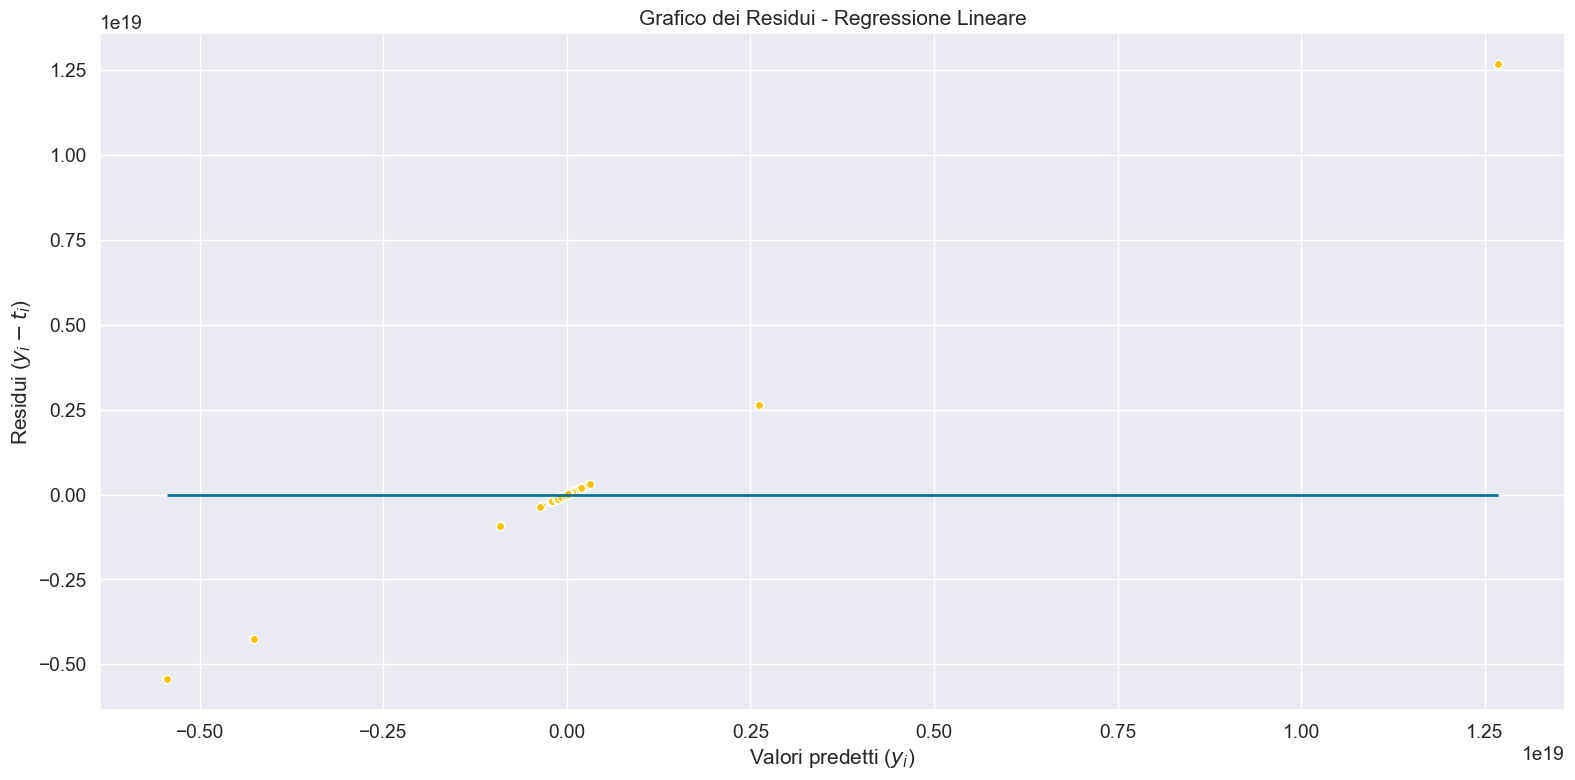

In [48]:
residual_plot(y_pred_linear, dataset.y_test, 'Regressione Lineare')

Possiamo notare che ci sono alcuni punti che sono lontani dalla retta, e di conseguenza hanno un errore maggiore rispetto ai punti vicino.

### 6.1.3 Performance test con scaling, PCA e con/senza FS

In [49]:
X_train_pca, X_test_pca, X_train_pca, X_test_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=True)
score1, _, y_pred_pca_linear = run_regression_train_test("linear normalized with PCA", LinearRegression(), dataset,
                                                         X_train_pca, X_test_pca,
                                                         scaled=False)
score2, _, y_pred_fs_pca_linear = run_regression_train_test("linear normalized with FS and PCA", LinearRegression(),
                                                            dataset, X_train_pca,
                                                            X_test_pca, scaled=False)

# migliore score2

Feature ridotte da 220 con PCA:  (1168, 4)
Feature selezionate:  (1168, 10)
Feature ridotte da 104 con MI e PCA:  (1168, 4)
linear normalized with PCA - r2: 0.6155717814276697 - rms: 50164.60891271981
linear normalized with PCA - r2 test: 0.5998622934273016 - rms test: 46202.225695514
linear normalized with FS and PCA - r2: 0.6797953566725947 - rms: 45769.815483641374
linear normalized with FS and PCA - r2 test: 0.7260596199112688 - rms test: 38228.40558217387


Per la regressione lineare si ottengono risultati migliori se non si utilizza la normalizzazione dei dati e si considerano tutte le feature sel training set (r2=0.86).

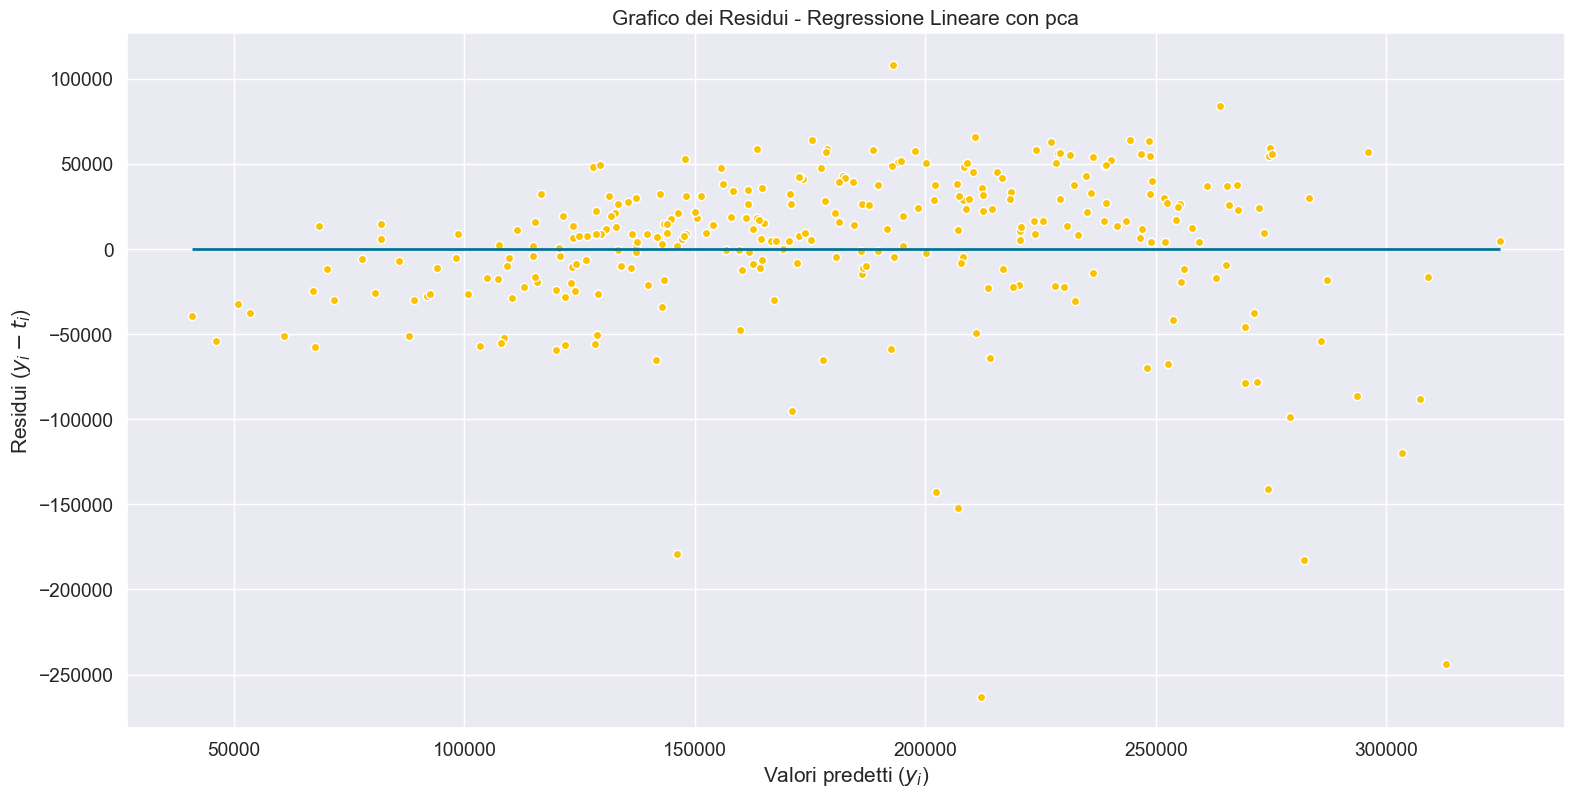

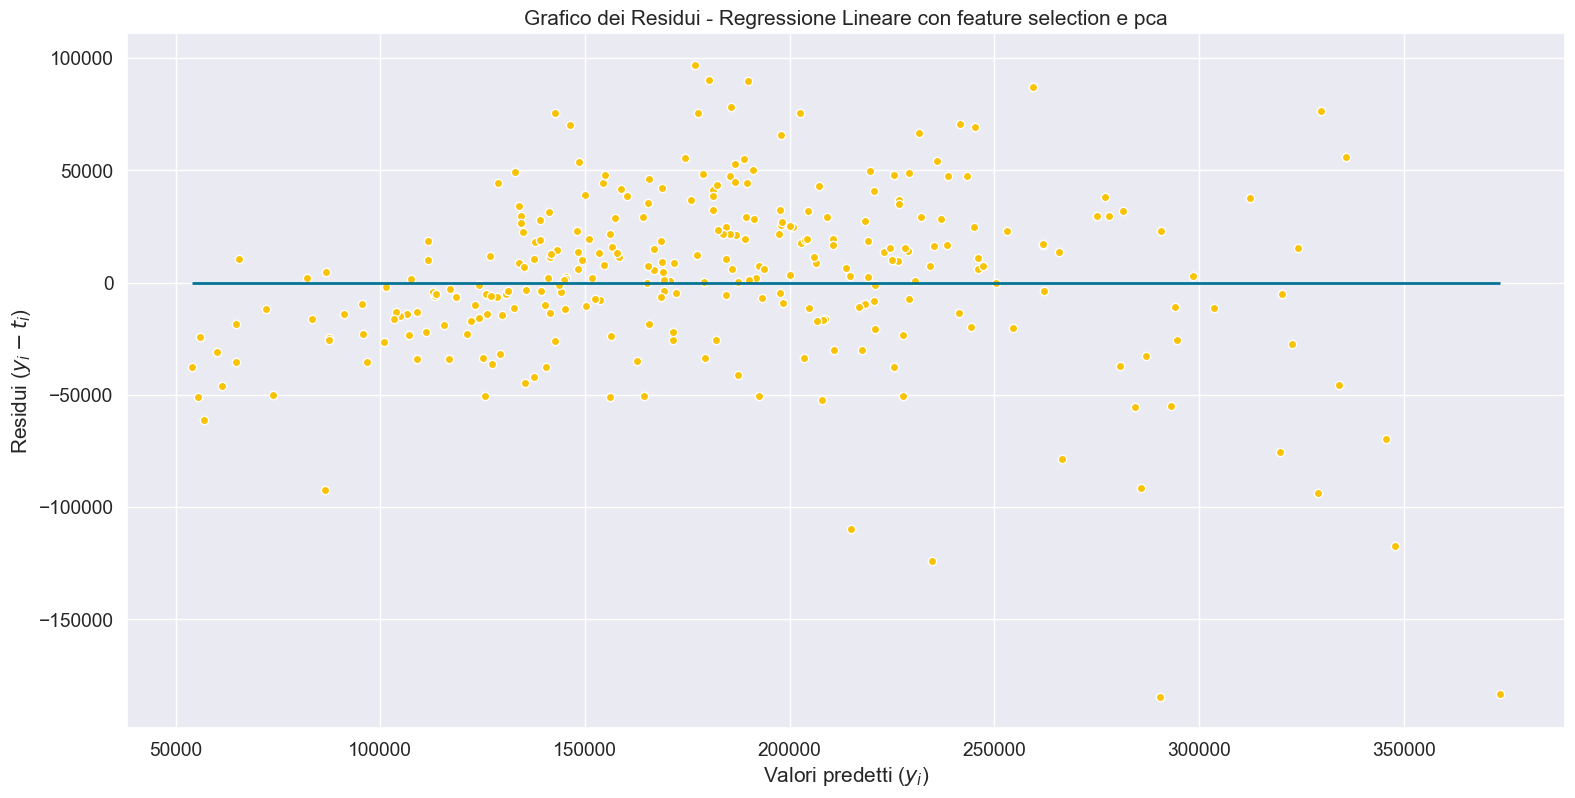

In [50]:
residual_plot(y_pred_pca_linear, dataset.y_test, 'Regressione Lineare con pca')
residual_plot(y_pred_fs_pca_linear, dataset.y_test, 'Regressione Lineare con feature selection e pca')

## 6.2 Regressione Polinomiale
Corrisponde a usare $m$ funzioni base polinomiale $\phi_j(\bold{x})=x^j$ per trasformare il dataset. Il grado massimo del polinomio è $m-1$. Vogliamo quindi trovare il miglior grado del polinomio che massimizza $R^2$.

In [62]:
def polynomial_transformation(x_train: DataFrame, x_test: DataFrame, d=2, only_interactions=False) -> Tuple[
    DataFrame, DataFrame]:
    """
    Trasforma il dataset di training e testing di partenza con n feature a dei dataset con m >> n feature.
    Ad esempio con 4 feature un polinomio di grado 2 produrrebbe 15 features:
    1, x1, x2, x3, x4, x1x2, x1x3, x1x4, x2x3, x2x4, x3x4, x1^2, x2^2, x3^2, x4^2
    d: grado del polinomio di regressione
    only_interactions: non mette le potenze ma solo le coppie (o tuple di dimensione massima d) di features
    returns: training set trasformato e testing set trasformato
    """
    # include_bias=False significa che non si forza l'intercetta y=0
    poly = PolynomialFeatures(degree=d, include_bias=False, interaction_only=only_interactions)
    # usiamo le funzioni base per trasformare il dataset (in questo caso aumenta d*(d-1)/2 il numero di features)
    x_train_poly = poly.fit_transform(x_train)
    # print(f"old train shape = {x_train.shape}, new train shape = {x_train_poly.shape}")
    x_test_poly = poly.transform(x_test)
    # print(f"old test shape = {x_test.shape}, new test shape = {x_test_poly.shape}")
    return pd.DataFrame(x_train_poly), pd.DataFrame(x_test_poly)


Il numero di feature ottenute è proporzionale al coefficiente binomiale delle feature iniziali e del grado del polinomio:

In [63]:
from scipy.special import binom

deg = 2
new_features = binom(220, deg)
print(f"Con 220 features, il polinomio di regressione di grado {deg} avrà {new_features} termini al più")

deg = 2
new_features = binom(40, deg)
print(f"Con 40 features, il polinomio di regressione di grado {deg} avrà {new_features} termini al più")

Con 220 features, il polinomio di regressione di grado 2 avrà 24090.0 termini al più
Con 40 features, il polinomio di regressione di grado 2 avrà 780.0 termini al più


Però poiché le feature iniziali sono 220, anche un polinomio di grado 2 produrrebbe ben 24090 features con PolynomialFeature, che sono decisamente troppe. Per ridurre la dimensionalità, quindi usiamo PCA per ridurre il numero di feature ad esempio a 40.

In [64]:
X_train_pca, X_test_pca, X_train_pca, X_test_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=False)

Feature ridotte da 220 con PCA:  (1168, 4)
Feature selezionate:  (1168, 10)
Feature ridotte da 104 con MI e PCA:  (1168, 4)


### 6.2.1 Con polynomial regression grado 3 con e senza `only_interactions`
Ora applichiamo le funzioni base polinomiali, con un polinomio di grado 3, con tutte le potenze delle features:

In [127]:
poly_degree = 3  # grado del polinomio (non aumentarlo troppo!)
X_poly_train_pca, X_poly_test_pca = polynomial_transformation(X_train_pca, X_test_pca, d=poly_degree)
X_poly_train_pca_fs, X_poly_test_pca_fs = polynomial_transformation(X_train_pca, X_test_pca, d=poly_degree)
score3, _, y_pred_poly3 = run_regression_train_test(f"poly (deg {poly_degree}) normalized with PCA", LinearRegression(),
                                                    dataset,
                                                    X_poly_train_pca,
                                                    X_poly_test_pca)
score4, _, y_pred_poly4 = run_regression_train_test(f"poly (deg {poly_degree}) normalized with FS and PCA",
                                                    LinearRegression(), dataset,
                                                    X_poly_train_pca_fs,
                                                    X_poly_test_pca_fs)

# migliore score 4 > score 2

poly (deg 3) normalized with PCA - r2: 0.7402868085708846 - rms: 40803.35456629967
poly (deg 3) normalized with PCA - r2 test: -0.07911837600852034 - rms test: 75946.83122581088
poly (deg 3) normalized with FS and PCA - r2: 0.8284943015435774 - rms: 33138.78268211199
poly (deg 3) normalized with FS and PCA - r2 test: 0.8628965783054217 - rms test: 27070.68597701348


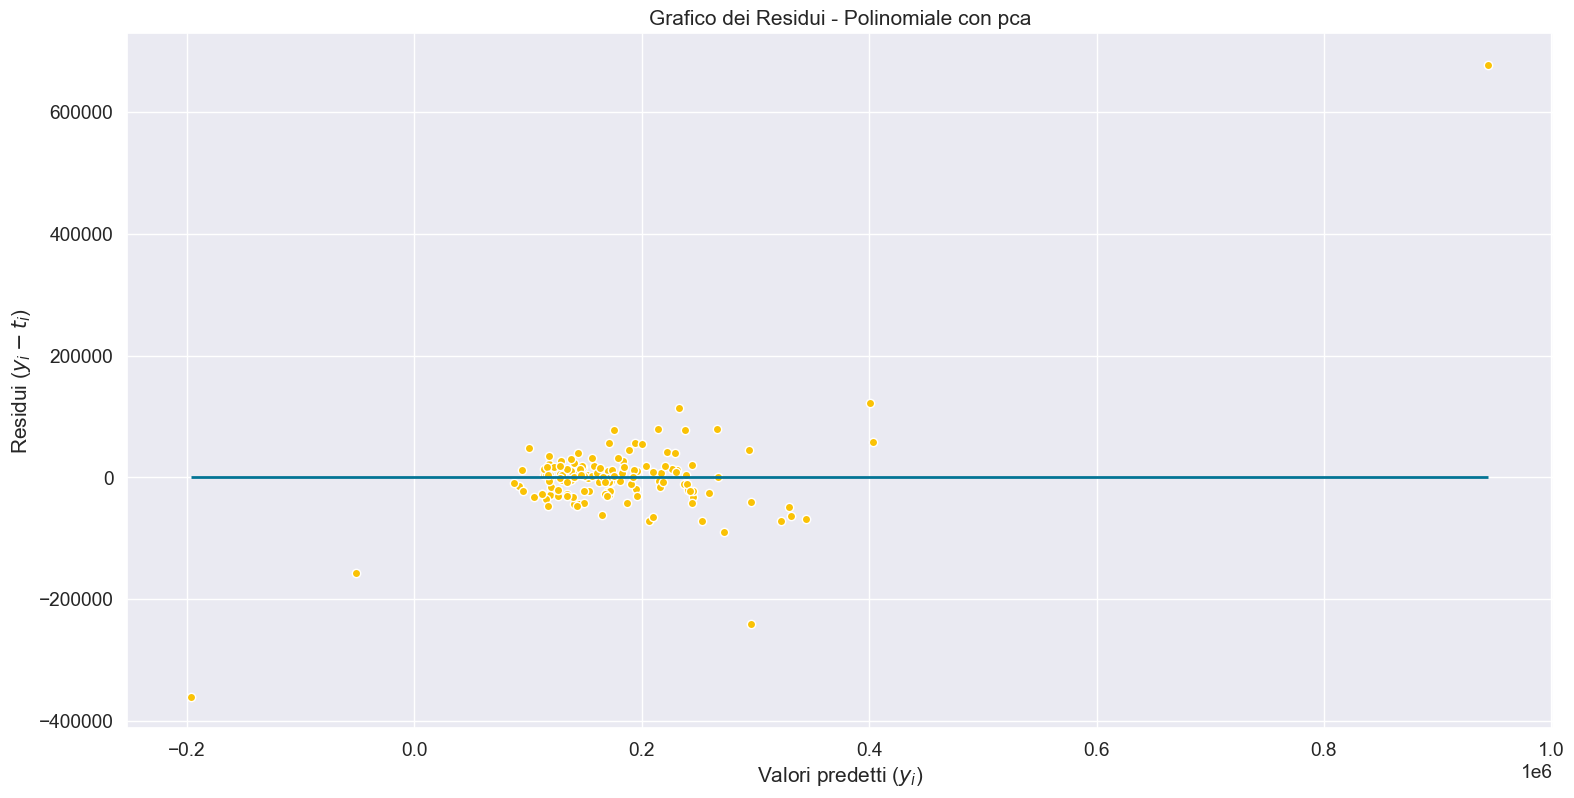

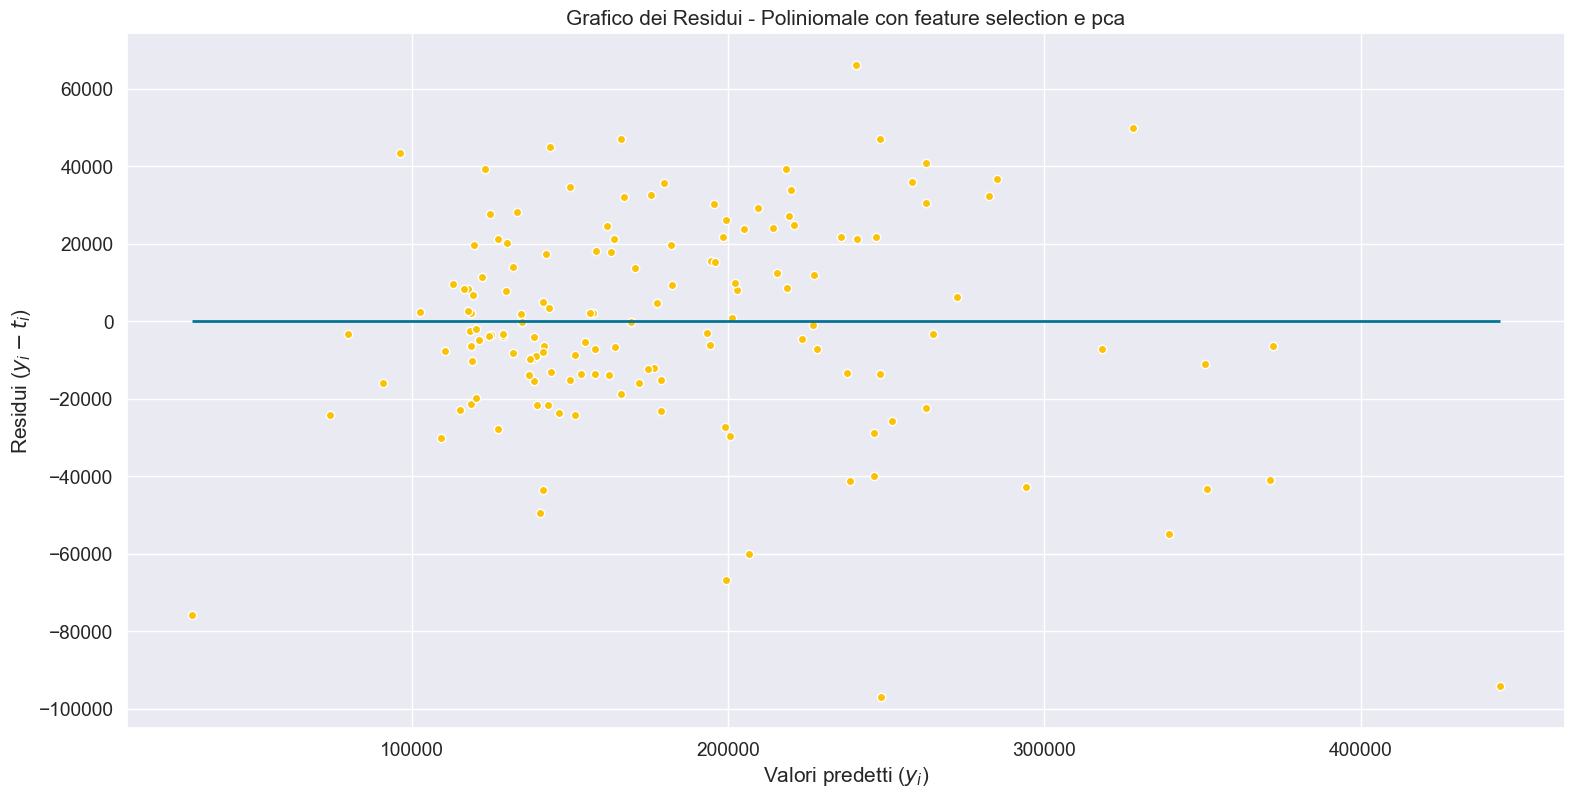

In [128]:
residual_plot(y_pred_poly3, dataset.y_test, 'Polinomiale con pca')
residual_plot(y_pred_poly4, dataset.y_test, 'Poliniomale con feature selection e pca')

Invece se manteniamo solo le interazioni tra le features, escludendo le potenze:

In [66]:
poly_degree = 3
X_poly_train_pca2, X_poly_test_pca2 = polynomial_transformation(X_train_pca, X_test_pca, d=poly_degree,
                                                                only_interactions=True)
X_poly_train_pca_fs2, X_poly_test_pca_fs2 = polynomial_transformation(X_train_pca, X_test_pca, d=poly_degree,
                                                                      only_interactions=True)

score5, _, y_pred_poly5 = run_regression_train_test(f"poly (deg {poly_degree}) normalized with PCA", LinearRegression(),
                                                    dataset,
                                                    X_poly_train_pca2,
                                                    X_poly_test_pca2)
score6, _, y_pred_poly6 = run_regression_train_test(f"poly (deg {poly_degree}) normalized with PCA", LinearRegression(),
                                                    dataset,
                                                    X_poly_train_pca_fs2,
                                                    X_poly_test_pca_fs2)

# meglio score 4

poly (deg 3) normalized with PCA - r2: 0.702379795276727 - rms: 44127.08180004463
poly (deg 3) normalized with PCA - r2 test: 0.6265099878998458 - rms test: 44637.27295249735
poly (deg 3) normalized with PCA - r2: 0.7784112274109738 - rms: 38087.07539486744
poly (deg 3) normalized with PCA - r2 test: 0.7879584065860202 - rms test: 33633.238544818436


Meglio usare `only_interactions=False`

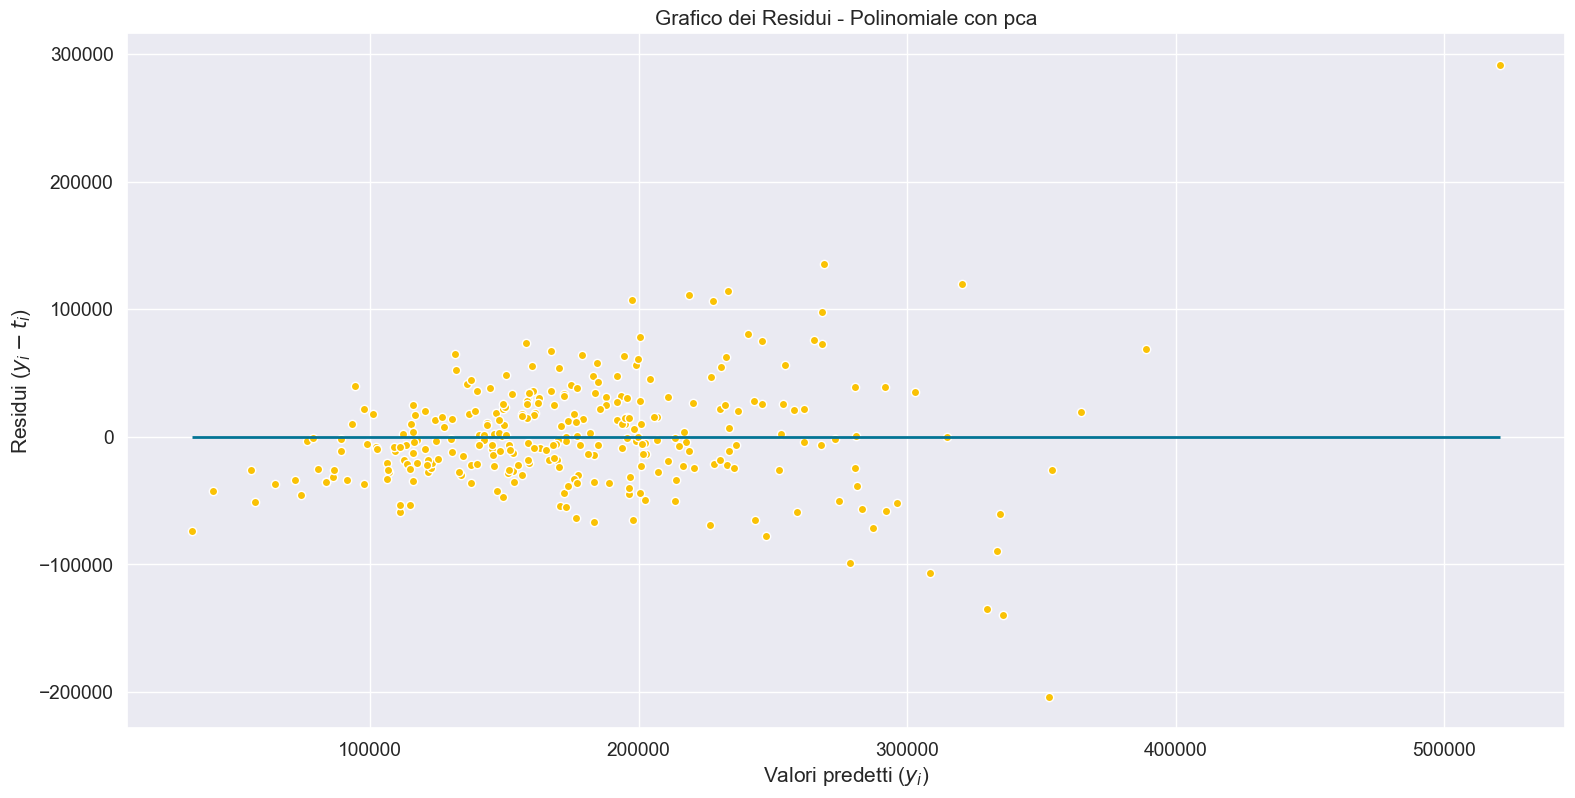

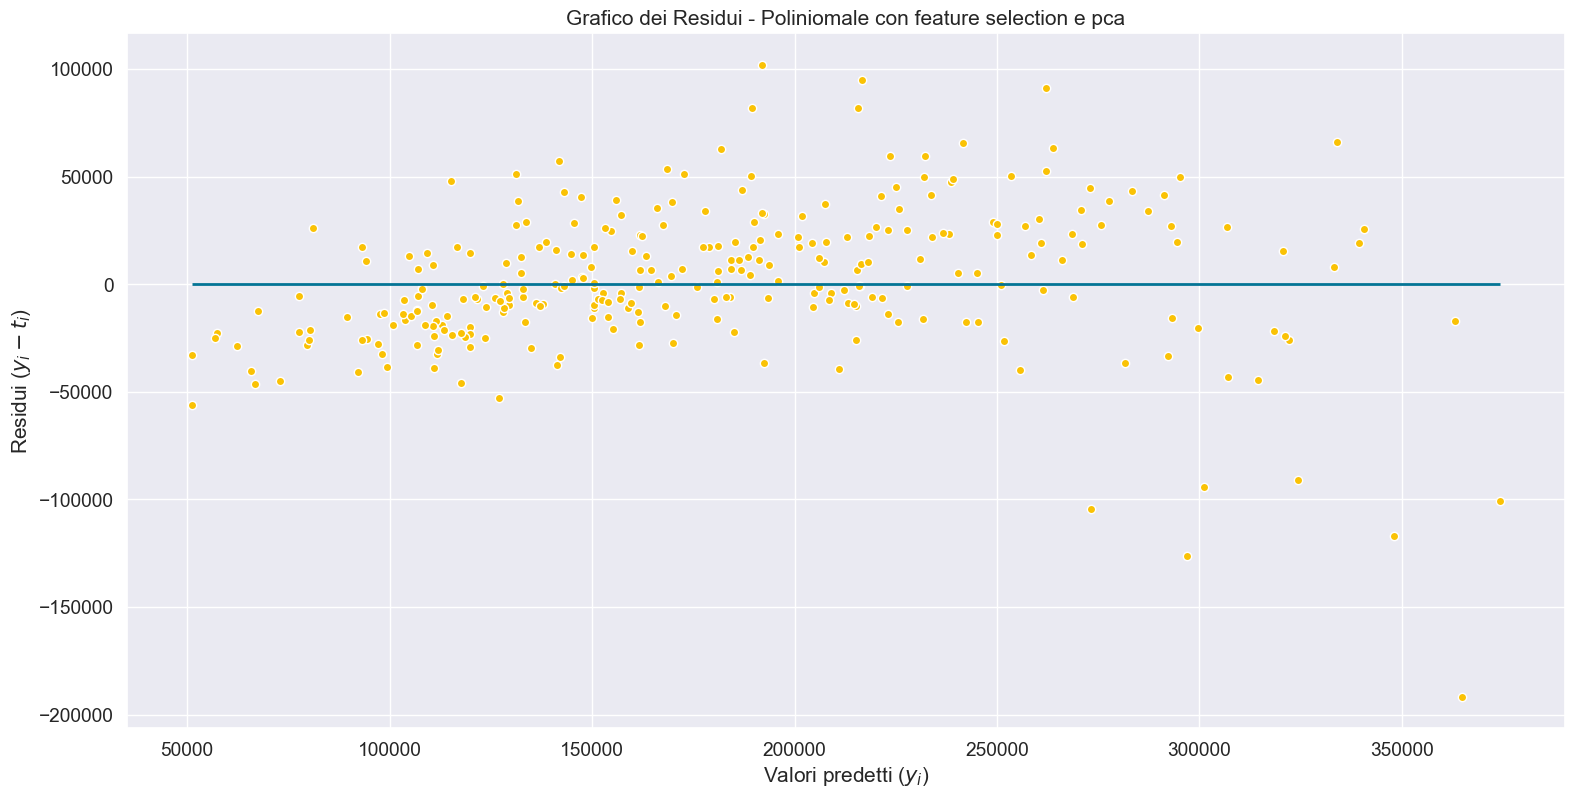

In [67]:
residual_plot(y_pred_poly5, dataset.y_test, 'Polinomiale con pca')
residual_plot(y_pred_poly6, dataset.y_test, 'Poliniomale con feature selection e pca')

### 6.2.2 Regressione polinomiale - Miglior grado
Troviamo il miglior grado del polinomio fissando il numero di feature dei dataset (con FS e PCA).

In [68]:
def best_poly_degree(dataset: Dataset):
    linear_regr = LinearRegression()
    degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    _, _, X_train_fs_pca, X_test_fs_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=False)
    best_r2 = 0.0
    best_rms = 0.0
    best_d = 0
    results = {"d": [], "r2": [], "rms": []}
    for d in degrees:
        # qua non possiamo fare grid search perché il grado non è un parametro della linear regression, 
        # ma un iperparametro per trasformare il dataset iniziale
        X_poly_train_fs_pca, _ = polynomial_transformation(X_train_fs_pca, X_test_fs_pca, d=d)
        r2_cv_poly, rms_cv_poly = performance_cross_validation(LinearRegression(), dataset,
                                                               x_train_new=X_poly_train_fs_pca)
        print(f"Polynomial Regression deg {d} -> r2 = {r2_cv_poly} rms = {rms_cv_poly}")
        results["d"].append(d)
        results["r2"].append(r2_cv_poly)
        results["rms"].append(rms_cv_poly)
        if r2_cv_poly > best_r2:
            best_r2 = r2_cv_poly
            best_rms = rms_cv_poly
            best_d = d
    return best_d, best_r2, best_rms, results

In [69]:
d, r2, rms, results = best_poly_degree(dataset)
print(f"Best degree for Polynomial regression: {d} - best r2: {r2} - best rms: {rms}")
pars_ridge = BestParameters("Polynomial Regression", 220, 0.0, {'degree': d}, r2, rms, None)
parameters.append(pars_ridge)

Feature ridotte da 220 con PCA:  (1168, 4)
Feature selezionate:  (1168, 10)
Feature ridotte da 104 con MI e PCA:  (1168, 4)
Polynomial Regression deg 1 -> r2 = 0.7186101517974367 rms = 42903.12487734975
Polynomial Regression deg 2 -> r2 = 0.8079787198050529 rms = 35442.431137744024
Polynomial Regression deg 3 -> r2 = 0.845181093698898 rms = 31826.661252568232
Polynomial Regression deg 4 -> r2 = 0.8613493872238468 rms = 30116.849269899685
Polynomial Regression deg 5 -> r2 = -3.2122074683448494 rms = 108265.4413070392
Polynomial Regression deg 6 -> r2 = -13.956071632273403 rms = 288500.39260155975
Polynomial Regression deg 7 -> r2 = -2.4240982513570914 rms = 145708.85395508393
Polynomial Regression deg 8 -> r2 = -0.9746319566884848 rms = 109904.2841505435
Polynomial Regression deg 9 -> r2 = -2.6676648602857007 rms = 132829.51393605018
Polynomial Regression deg 10 -> r2 = -3.9263059262183666 rms = 138232.98748658126
Best degree for Polynomial regression: 4 - best r2: 0.8613493872238468 - 

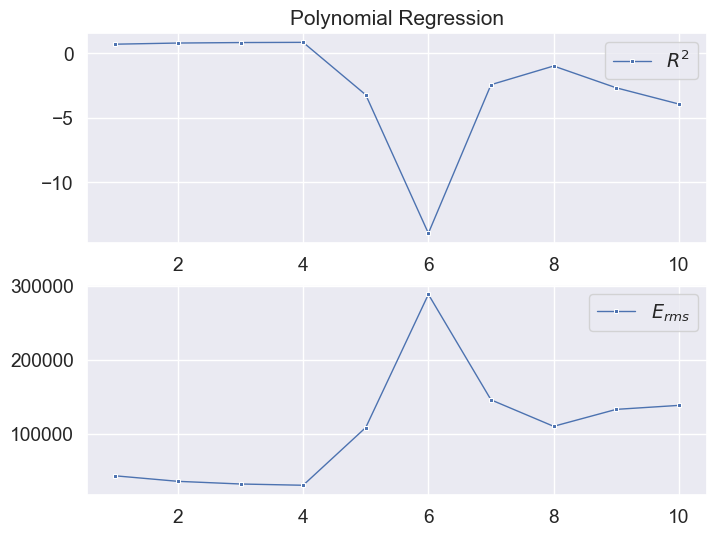

In [70]:
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
simple_plot_scores(x=results["d"], y=results["r2"], label="$R^2$", title="Polynomial Regression")
plt.subplot(2, 1, 2)
simple_plot_scores(x=results["d"], y=results["rms"], label="$E_{rms}$", title="")

### 6.3.3 Performance test

Determiniamo la performance del modello sul testing set, usando il miglior grado:

In [71]:
best_degree = d  # 4
X_poly_train_fs_pca, X_poly_test_fs_pca = polynomial_transformation(X_train_pca, X_test_pca, d=best_degree)
r2_poly_test, rms_poly_test, y_pred_poly = performance_test(LinearRegression(), dataset,
                                                            x_train_new=X_poly_train_fs_pca,
                                                            x_test_new=X_poly_test_fs_pca, scaled=False)
print(f"Polynomial Regression best degree ({best_degree})-> r2 mean: {r2_poly_test} - rms mean: {rms_poly_test} ")

Polynomial Regression best degree (4)-> r2 mean: 0.5588734817898983 - rms mean: 48510.94569151547 


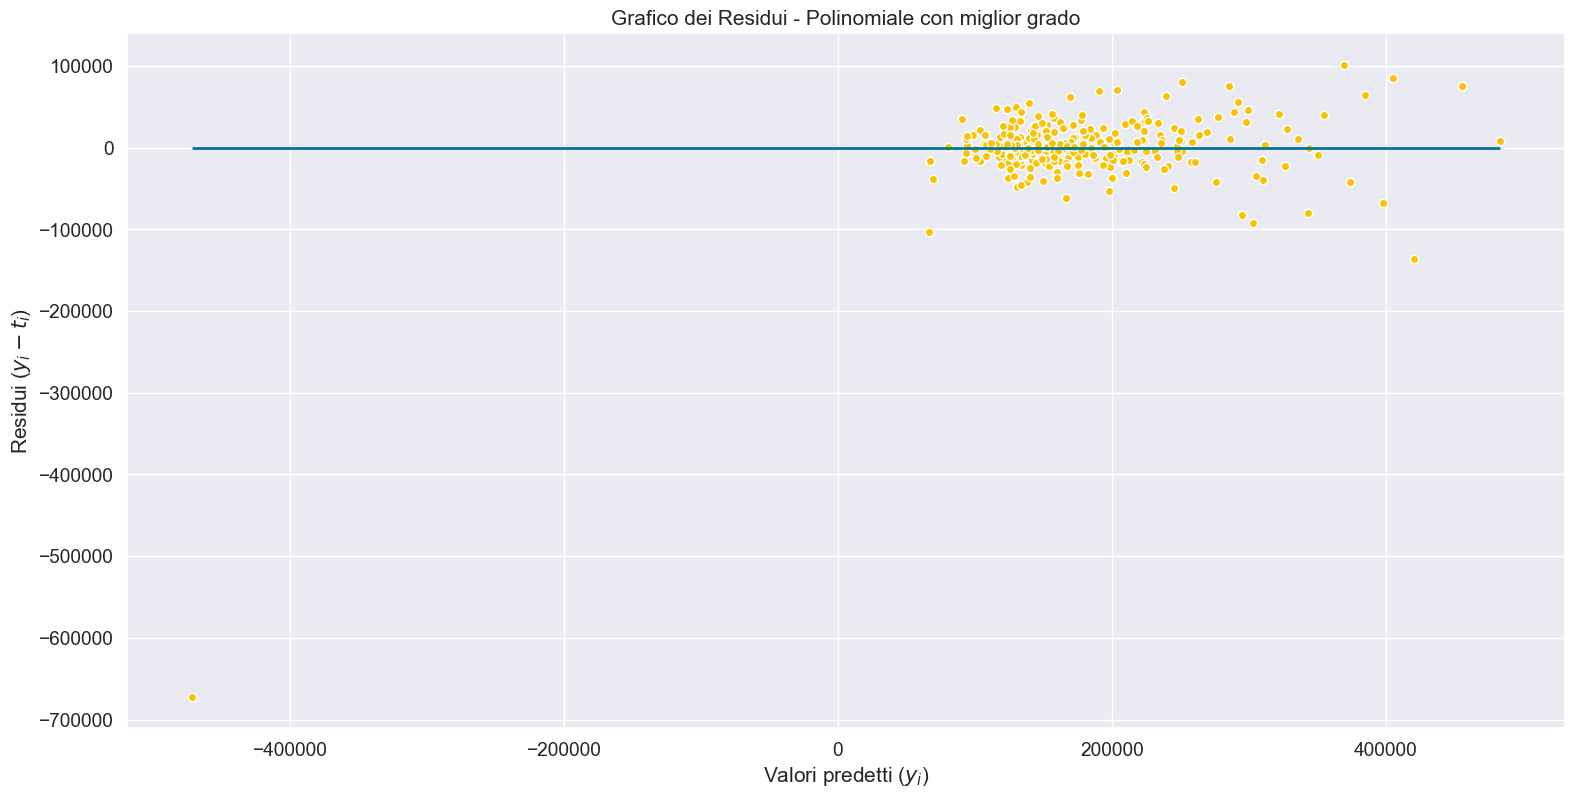

In [72]:
residual_plot(y_pred_poly, dataset.y_test, 'Polinomiale con miglior grado')

## 6.3 Regressione Lasso
La regressione lasso ha un termine di regolarizzazione che tende ad azzerare molte feature.


### 6.3.1 GridSeach

Tramite GridSearch troviamo il miglior $\alpha$ per la regressiona Lasso:

In [51]:
lasso_regression_gs = Lasso()
params_lasso = {
    'alpha': [1, 5, 50, 100, 300, 500, 1000, 1040, 1100, 1200, 1500, 2000],
    'tol': list(np.linspace(0.1, 1, 10)),
}
r2_gs_lasso, best_param_lasso = grid_search(lasso_regression_gs, dataset, params_lasso, scaled=False)
print(f"Lasso regression -> r2: {r2_gs_lasso} - best parameters: {best_param_lasso}")

Lasso regression -> r2: 0.7432633669310189 - best parameters: {'alpha': 500, 'tol': 0.1}


### 6.1.2 Performance training
Determiniamo la performance del training set tramite cross validation (senza scaling):

In [53]:
lasso_regression = Lasso(alpha=best_param_lasso['alpha'], tol=best_param_lasso['tol'])
mean_r2 = 0.0
mean_rms = 0.0
for i in range(0, len(folds)):
    dataset = Dataset(folds[i].X_train, folds[i].y_train, folds[i].X_test, folds[i].y_test)
    r2_cv_lasso, rms_cv_lasso = performance_cross_validation(lasso_regression, dataset)
    print(f"Lasso Regression -> r2 = {r2_cv_lasso} rms = {rms_cv_lasso}")
    mean_r2 += r2_cv_lasso
    mean_rms += rms_cv_lasso
mean_r2 = mean_r2 / len(folds)
mean_rms = mean_rms / len(folds)
print(f"Lasso regression mean cv: r2 = {mean_r2} rms = {mean_rms}")

Lasso Regression -> r2 = 0.8353602753794597 rms = 31385.618575775217
Lasso Regression -> r2 = 0.8364668458208573 rms = 32115.519992880232
Lasso Regression -> r2 = 0.8331987819125596 rms = 32613.353515290488
Lasso Regression -> r2 = 0.8352625008390511 rms = 31706.962602733296
Lasso Regression -> r2 = 0.8474617502413286 rms = 31308.876899101422
Lasso Regression -> r2 = 0.8645952005263495 rms = 29303.961950810906
Lasso Regression -> r2 = 0.8371818626113041 rms = 31747.07330340491
Lasso Regression -> r2 = 0.8360872965682011 rms = 32407.429670013826
Lasso Regression -> r2 = 0.8346423298227451 rms = 32605.198076686687
Lasso Regression -> r2 = 0.8326476937327193 rms = 32734.307629886258
Lasso regression mean cv: r2 = 0.8392904537454575 rms = 31792.83022165833


### 6.3.3 Performance test

Determiniamo la performance del modello sul testing set (senza scaling):

In [54]:
lasso_regression = Lasso(alpha=best_param_lasso['alpha'], tol=best_param_lasso['tol'])
mean_r2 = 0.0
mean_rms = 0.0
for i in range(0, len(folds)):
    dataset = Dataset(folds[i].X_train, folds[i].y_train, folds[i].X_test, folds[i].y_test)
    r2_lasso, rms_lasso, y_pred_lasso = performance_test(lasso_regression, dataset)
    print(f"Lasso Regression -> r2 mean: {r2_lasso} - rms mean: {rms_lasso} ")
    mean_r2 += r2_lasso
    mean_rms += rms_lasso
mean_r2 = mean_r2 / len(folds)
mean_rms = mean_rms / len(folds)
print(f"Lasso regression mean cv: r2 = {mean_r2} rms = {mean_rms}")
pars_ridge = BestParameters("Lasso Regression", 220, best_param_lasso['alpha'], {'tol': best_param_lasso['tol']},
                            mean_r2, mean_rms, None)
parameters.append(pars_ridge)

Lasso Regression -> r2 mean: 0.8422829146298126 - rms mean: 37960.56111108182 
Lasso Regression -> r2 mean: 0.8481042496120377 - rms mean: 30617.48578102366 
Lasso Regression -> r2 mean: 0.8805317119267025 - rms mean: 25831.832253611767 
Lasso Regression -> r2 mean: 0.8232219583054909 - rms mean: 37574.0504270001 
Lasso Regression -> r2 mean: 0.6816158335979435 - rms mean: 40270.29774111706 
Lasso Regression -> r2 mean: 0.3010019703406568 - rms mean: 64303.92796855978 
Lasso Regression -> r2 mean: 0.8254817250831431 - rms mean: 35529.024988650424 
Lasso Regression -> r2 mean: 0.852853135076738 - rms mean: 27944.987549339887 
Lasso Regression -> r2 mean: 0.8600610506401624 - rms mean: 26733.66839621711 
Lasso Regression -> r2 mean: 0.8955434827840122 - rms mean: 23628.86630267238 
Lasso regression mean cv: r2 = 0.7810698031996699 rms = 35039.4702519274


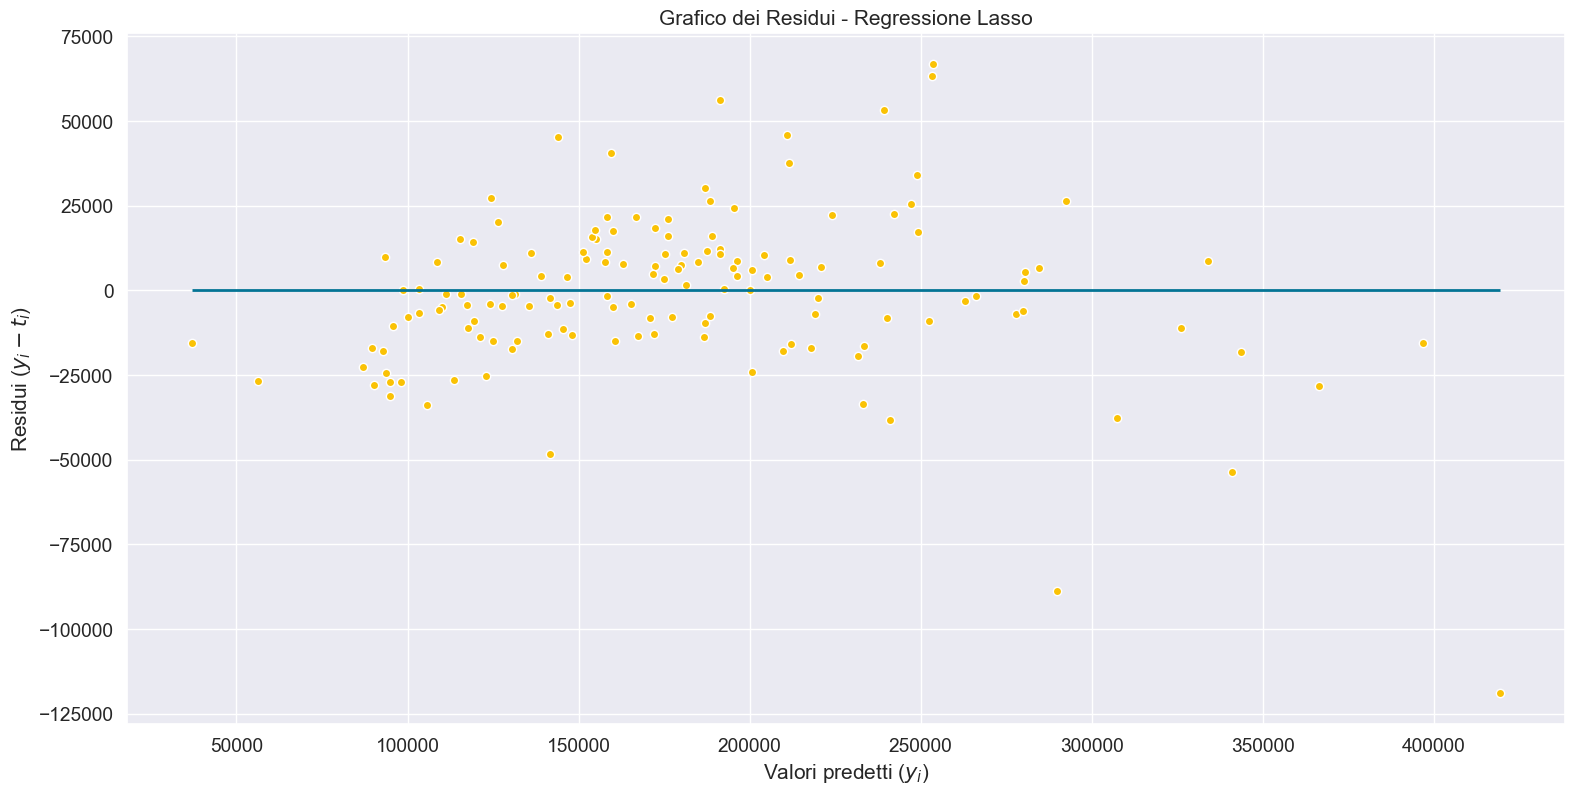

In [55]:
residual_plot(y_pred_lasso, dataset.y_test, 'Regressione Lasso')

### 6.3.4 Performance test con pca, con/senza feature selection

In [77]:
lasso_regression_pca_fs = Lasso(alpha=best_param_lasso['alpha'], tol=best_param_lasso['tol'])

X_train_pca, X_test_pca, X_train_pca, X_test_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=False)
score1_lasso, _, y_pred_lasso1 = run_regression_train_test("linear normalized with PCA", lasso_regression_pca_fs,
                                                           dataset, X_train_pca,
                                                           X_test_pca, scaled=False)
score2_lasso, _, y_pred_lasso2 = run_regression_train_test("linear normalized with FS and PCA", lasso_regression_pca_fs,
                                                           dataset,
                                                           X_train_pca, X_test_pca, scaled=False)

Feature ridotte da 220 con PCA:  (1314, 4)
Feature selezionate:  (1314, 10)
Feature ridotte da 104 con MI e PCA:  (1314, 4)
linear normalized with PCA - r2: 0.6076690257915041 - rms: 50113.987202415556
linear normalized with PCA - r2 test: 0.7182285562556874 - rms test: 38808.209208087945
linear normalized with FS and PCA - r2: 0.723163109283141 - rms: 42111.77654163267
linear normalized with FS and PCA - r2 test: 0.772033594220436 - rms test: 34906.84039011187


Anche in questo caso la FS e PCA riducono le performance di almeno 10 punti percentuali per l'$R^2$, quindi non sono convenienti.

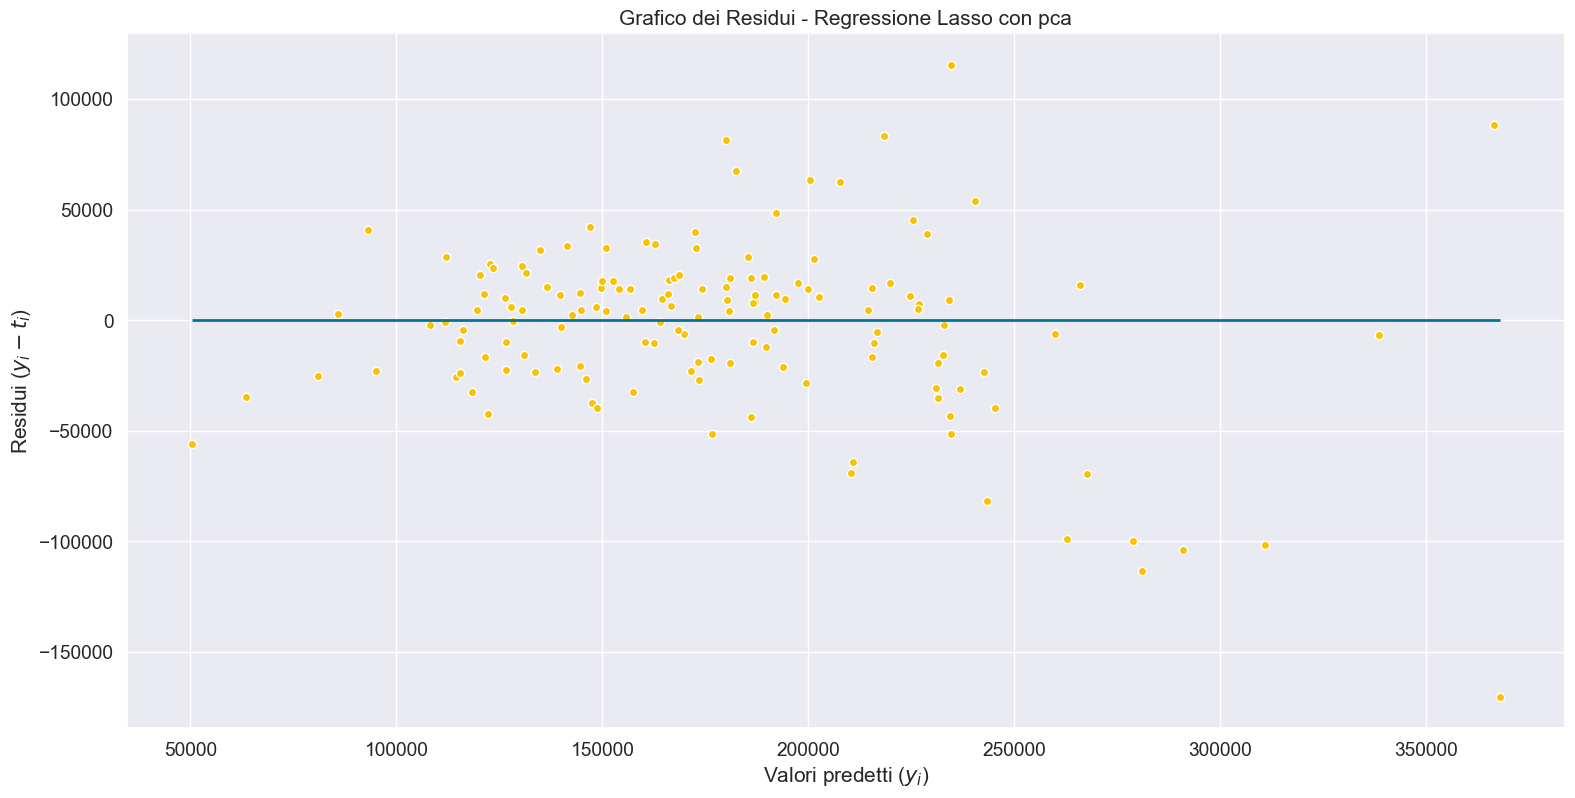

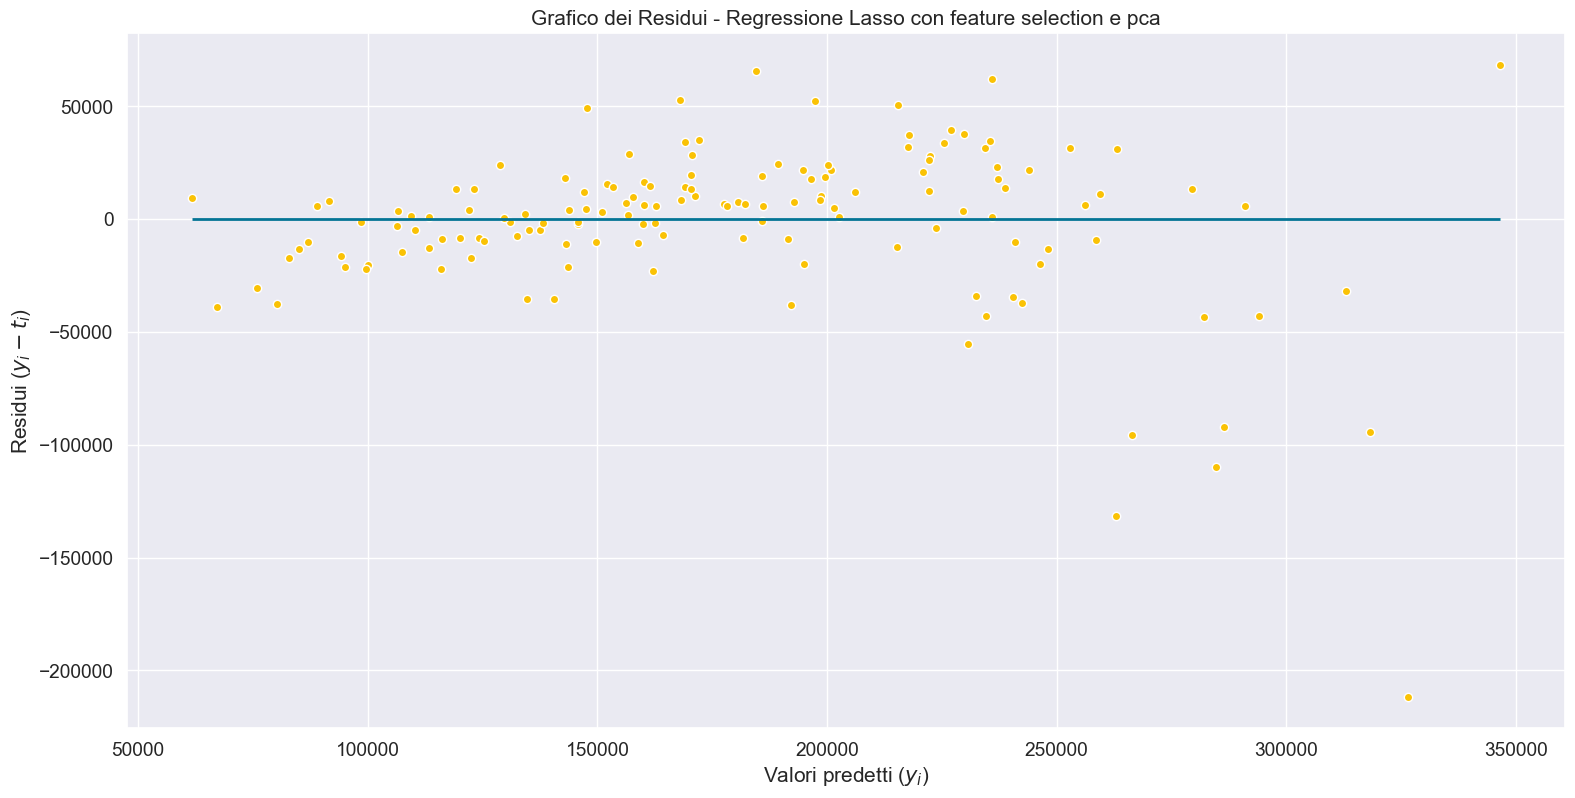

In [78]:
residual_plot(y_pred_lasso1, dataset.y_test, 'Regressione Lasso con pca')
residual_plot(y_pred_lasso2, dataset.y_test, 'Regressione Lasso con feature selection e pca')

## 6.4 Ridge Regression
La ridge regression usa un coefficiente di regolarizzazione $\alpha$ per ridurre la complessità del modello e quindi l'overfitting, il che potrebbe essere utile in quanto abbiamo pochi elementi nel dataset (1480).

### 6.4.1 GridSearch

In [79]:
ridge_regression_gs = Ridge()
params_ridge = {
    #'alpha': list(np.linspace(0.1, 10, 10)),
    'alpha': [1, 20, 50, 100, 110, 139, 170, 200],
    'tol': list(np.linspace(0.1, 1, 10)),
}
r2_gs_ridge, best_param_ridge = grid_search(ridge_regression_gs, dataset, params_ridge)
print(f"Ridge regression -> r2: {r2_gs_ridge} - best parameters: {best_param_ridge}")


Ridge regression -> r2: 0.7789970650493566 - best parameters: {'alpha': 200, 'tol': 0.1}


### 6.4.2 Performance training

In [80]:
ridge_regression = Ridge(alpha=best_param_ridge['alpha'], tol=best_param_ridge['tol'])
mean_r2 = 0.0
mean_rms = 0.0
for i in range(0, len(folds)):
    dataset = Dataset(folds[i].X_train, folds[i].y_train, folds[i].X_test, folds[i].y_test)
    r2_cv_ridge, rms_cv_ridge = performance_cross_validation(ridge_regression, dataset)
    print(f"Ridge Regression -> r2 = {r2_cv_ridge} rms = {rms_cv_ridge}")
    mean_r2 += r2_cv_ridge
    mean_rms += rms_cv_ridge
mean_r2 = mean_r2 / len(folds)
mean_rms = mean_rms / len(folds)
print(f"Ridge regression mean cv: r2 = {mean_r2} rms = {mean_rms}")

Ridge Regression -> r2 = 0.8468904373544737 rms = 30259.926165889745
Ridge Regression -> r2 = 0.8469049097251362 rms = 31066.059719157038
Ridge Regression -> r2 = 0.8433124723976408 rms = 31604.45582654664
Ridge Regression -> r2 = 0.847826882232867 rms = 30469.750061866973
Ridge Regression -> r2 = 0.8604637718624015 rms = 29936.884596124826
Ridge Regression -> r2 = 0.8790682361707803 rms = 27692.9579491222
Ridge Regression -> r2 = 0.847663089083472 rms = 30702.10181926516
Ridge Regression -> r2 = 0.845719401220997 rms = 31434.608411677087
Ridge Regression -> r2 = 0.8458057762598058 rms = 31478.63213706253
Ridge Regression -> r2 = 0.8432562241139925 rms = 31676.21937873232
Ridge regression mean cv: r2 = 0.8506911200421566 rms = 30632.159606544454


### 6.4.3 Perfomance test

In [81]:
ridge_regression = Ridge(alpha=best_param_ridge['alpha'], tol=best_param_ridge['tol'])
mean_r2 = 0.0
mean_rms = 0.0
for i in range(0, len(folds)):
    dataset = Dataset(folds[i].X_train, folds[i].y_train, folds[i].X_test, folds[i].y_test)
    r2_ridge, rms_ridge, y_pred_ridge = performance_test(ridge_regression, dataset)
    print(f"Ridge Regression -> r2 mean: {r2_ridge} - rms mean: {rms_ridge} ")
    mean_r2 += r2_ridge
    mean_rms += rms_ridge
mean_r2 = mean_r2 / len(folds)
mean_rms = mean_rms / len(folds)
print(f"Ridge regression mean cv: r2 = {mean_r2} rms = {mean_rms}")
pars_ridge = BestParameters("Ridge Regression", 220, best_param_ridge['alpha'], {'tol': best_param_ridge['tol']},
                            mean_r2, mean_rms, None)
parameters.append(pars_ridge)

Ridge Regression -> r2 mean: 0.8464183456892647 - rms mean: 37459.581629353605 
Ridge Regression -> r2 mean: 0.8618169524794406 - rms mean: 29202.773243509197 
Ridge Regression -> r2 mean: 0.9063074481287744 - rms mean: 22876.070456785328 
Ridge Regression -> r2 mean: 0.8297026258839186 - rms mean: 36878.889097257255 
Ridge Regression -> r2 mean: 0.6773107956519475 - rms mean: 40541.64139900496 
Ridge Regression -> r2 mean: 0.34377816884234313 - rms mean: 62305.281677978164 
Ridge Regression -> r2 mean: 0.845756436008546 - rms mean: 33401.5299123769 
Ridge Regression -> r2 mean: 0.8777388943165455 - rms mean: 25472.55878744771 
Ridge Regression -> r2 mean: 0.8805138520469898 - rms mean: 24702.905242506487 
Ridge Regression -> r2 mean: 0.9105012217651165 - rms mean: 21871.75676973559 
Ridge regression mean cv: r2 = 0.7979844740812887 rms = 33471.29882159552


La *regressione Ridge* risulta essere migliore della *regressione Lasso*.

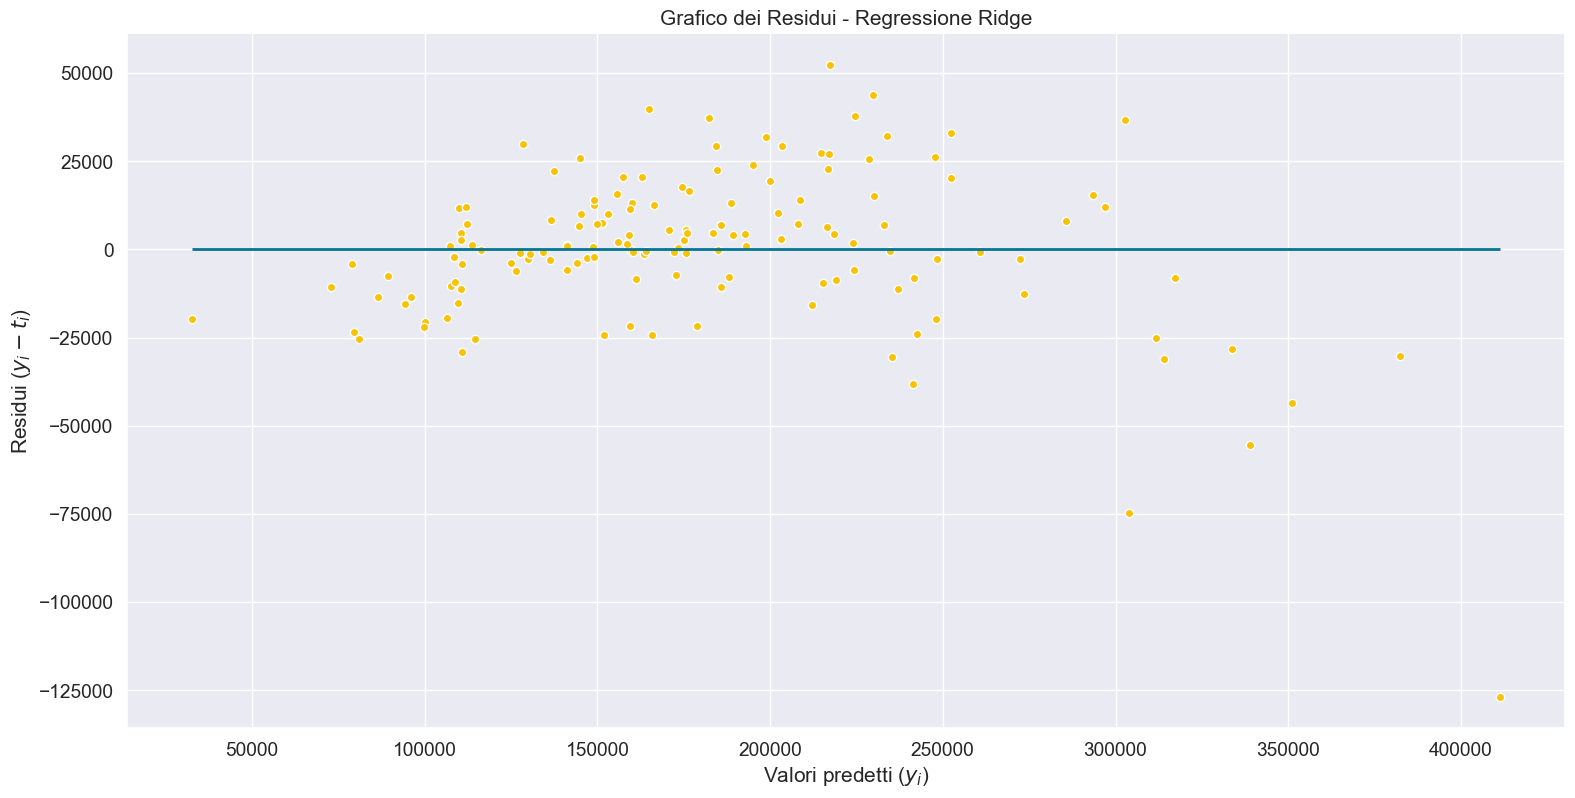

In [82]:
residual_plot(y_pred_ridge, dataset.y_test, 'Regressione Ridge')

### 6.4.4 Performance test con pca, con/senza feature selection

In [83]:
ridge_regression_pca_fs = Lasso(alpha=best_param_ridge['alpha'], tol=best_param_ridge['tol'], random_state=42)

X_train_pca, X_test_pca, X_train_pca, X_test_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=False)
score1_ridge, _, y_pred_ridge1 = run_regression_train_test("linear normalized with PCA", ridge_regression_pca_fs,
                                                           dataset, X_train_pca,
                                                           X_test_pca, scaled=False)
score2_ridge, _, y_pred_ridge2 = run_regression_train_test("linear normalized with FS and PCA", ridge_regression_pca_fs,
                                                           dataset,
                                                           X_train_pca, X_test_pca, scaled=False)

Feature ridotte da 220 con PCA:  (1314, 4)
Feature selezionate:  (1314, 10)
Feature ridotte da 104 con MI e PCA:  (1314, 4)
linear normalized with PCA - r2: 0.607669026218886 - rms: 50113.987174922506
linear normalized with PCA - r2 test: 0.7182306174454649 - rms test: 38808.06726462248
linear normalized with FS and PCA - r2: 0.7231851362805284 - rms: 42110.09843911246
linear normalized with FS and PCA - r2 test: 0.7715890104522474 - rms test: 34940.86175302698


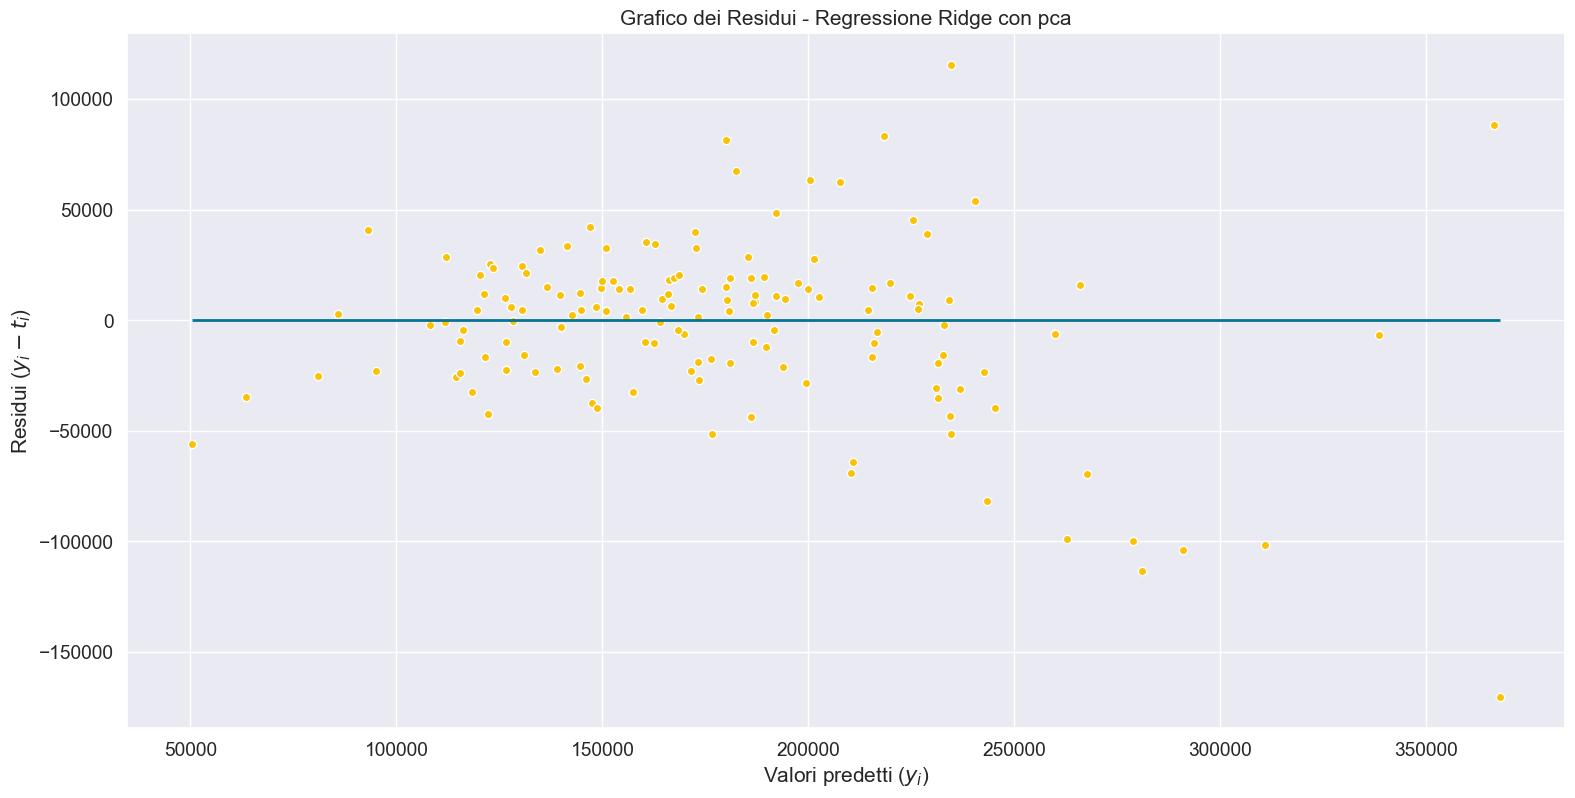

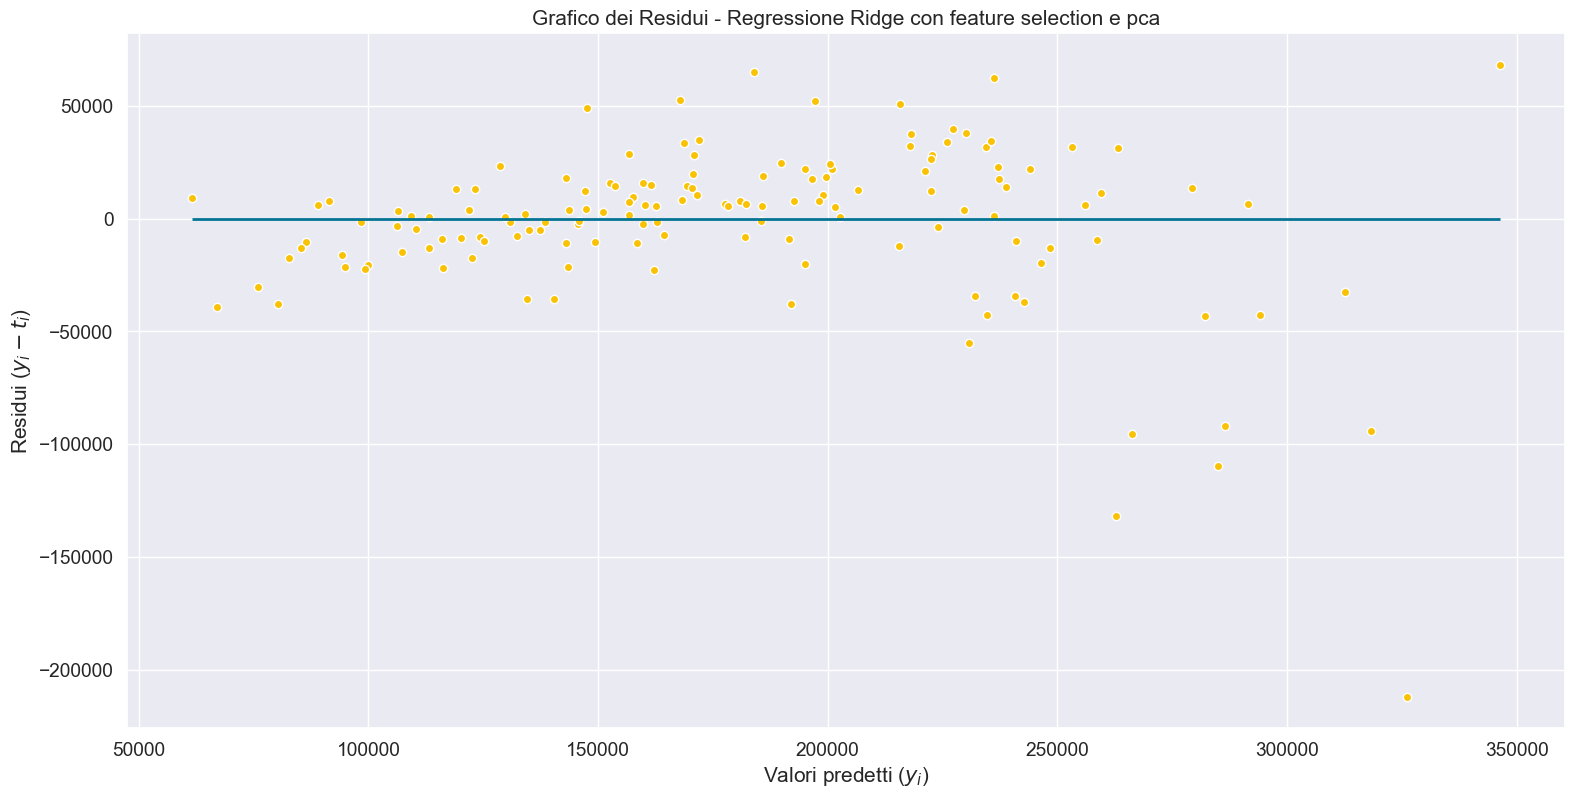

In [84]:
residual_plot(y_pred_ridge1, dataset.y_test, 'Regressione Ridge con pca')
residual_plot(y_pred_ridge2, dataset.y_test, 'Regressione Ridge con feature selection e pca')

## 6.5 ElasticNET Regression

L''Elastic-Net' è un metodo di regressione regolarizzato che combina linearmente le due penalità, *L1* e *L2*, dei metodi di regressione Lasso e Ridge.
- *'l1_ratio'*: determina la percentuale della nostra penalità L1 rispetto a $\alpha$. Quindi, per esempio, se $\alpha = 1$ e $L1_{ratio}$ = 0.4, la nostra penalità $L1$ sarà moltiplicata per 0.4 e la nostra penalità $L2$ sarà moltiplicata per $1 - L1_{ratio} = 0.6$

In questo caso abbiamo la regressione ridge se $L1_{ratio} = 0$ e la regressione lasso se $L1_{ratio} = 1$.

La proprietà più importante di Lasso è che produce pesi del modello sparsi, il che significa che i pesi possono essere impostati fino a 0.



### 6.5.1 GridSearch

In [85]:
from sklearn.linear_model import ElasticNet

elasticnet_regression_gs = ElasticNet(random_state=42)
params_elasticnet = {
    'alpha': [1, 20, 50, 100, 110, 139, 170, 200],
    'tol': list(np.linspace(0.1, 1, 10)),
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
r2_gs_elasticnet, best_param_elasticnet = grid_search(elasticnet_regression_gs, dataset, params_elasticnet)
print(f"Elastic Net regression -> r2: {r2_gs_elasticnet} - best parameters: {best_param_elasticnet}")


Elastic Net regression -> r2: 0.7846656676131126 - best parameters: {'alpha': 1, 'l1_ratio': 0.3, 'tol': 0.2}


### 6.5.2 Performance training

In [86]:
mean_r2 = 0.0
mean_rms = 0.0
elasticnet_regression = ElasticNet(alpha=best_param_elasticnet['alpha'], tol=best_param_elasticnet['tol'],
                                   l1_ratio=best_param_elasticnet['l1_ratio'], random_state=42)
for i in range(0, len(folds)):
    dataset = Dataset(folds[i].X_train, folds[i].y_train, folds[i].X_test, folds[i].y_test)
    r2_cv_elasticnet, rms_cv_elasticnet = performance_cross_validation(elasticnet_regression, dataset)
    print(f"Elastic Net Regression CV -> r2 = {r2_cv_elasticnet} rms = {rms_cv_elasticnet}")
    mean_r2 += r2_cv_elasticnet
    mean_rms += rms_cv_elasticnet
mean_r2 = mean_r2 / len(folds)
mean_rms = mean_rms / len(folds)
print(f"Elastic Net Regression mean CV: r2 = {mean_r2} rms = {mean_rms}")

Elastic Net Regression CV -> r2 = 0.8063967597389196 rms = 34029.84889901018
Elastic Net Regression CV -> r2 = 0.8070029059326117 rms = 34883.360567019205
Elastic Net Regression CV -> r2 = 0.8035835344494753 rms = 35386.60763593676
Elastic Net Regression CV -> r2 = 0.8077051010850843 rms = 34252.983612675176
Elastic Net Regression CV -> r2 = 0.8232830211989738 rms = 33695.803018754916
Elastic Net Regression CV -> r2 = 0.8461740822926789 rms = 31235.034550300355
Elastic Net Regression CV -> r2 = 0.8081261386687093 rms = 34458.70438356157
Elastic Net Regression CV -> r2 = 0.8062590178890806 rms = 35227.13735881886
Elastic Net Regression CV -> r2 = 0.8066424451839758 rms = 35251.79373330969
Elastic Net Regression CV -> r2 = 0.8039080774071868 rms = 35431.32624347117
Elastic Net Regression mean CV: r2 = 0.8119081083846696 rms = 34385.260000285794


### 6.5.3 Performance test

In [87]:
mean_r2 = 0.0
mean_rms = 0.0
elasticnet_regression = ElasticNet(alpha=best_param_elasticnet['alpha'], tol=best_param_elasticnet['tol'],
                                   l1_ratio=best_param_elasticnet['l1_ratio'], random_state=42)
for i in range(0, len(folds)):
    dataset = Dataset(folds[i].X_train, folds[i].y_train, folds[i].X_test, folds[i].y_test)
    r2_elasticnet, rms_elasticnet, y_pred_elasticnet = performance_test(elasticnet_regression, dataset)
    print(f"Elastic Net Regression Test -> r2 mean: {r2_elasticnet} - rms mean: {rms_elasticnet} ")
    mean_r2 += r2_elasticnet
    mean_rms += rms_elasticnet
mean_r2 = mean_r2 / len(folds)
mean_rms = mean_rms / len(folds)
print(f"Elastic Net Regression Test mean CV: r2 = {mean_r2} rms = {mean_rms}")
pars_elasticnet = BestParameters("Elastic Net Regression", 220, best_param_elasticnet['alpha'],
                                 {'l1_ratio': best_param_elasticnet['l1_ratio']}, mean_r2, mean_rms, None)
parameters.append(pars_elasticnet)

Elastic Net Regression Test -> r2 mean: 0.8337220638781618 - rms mean: 38977.193454590924 
Elastic Net Regression Test -> r2 mean: 0.8364979537357977 - rms mean: 31765.69115644301 
Elastic Net Regression Test -> r2 mean: 0.8817321927652775 - rms mean: 25701.718577325802 
Elastic Net Regression Test -> r2 mean: 0.8115640397257009 - rms mean: 38793.21266014412 
Elastic Net Regression Test -> r2 mean: 0.6187830000950292 - rms mean: 44065.14863728602 
Elastic Net Regression Test -> r2 mean: 0.20126766075989433 - rms mean: 68738.5174229844 
Elastic Net Regression Test -> r2 mean: 0.8189313286961906 - rms mean: 36189.6590127266 
Elastic Net Regression Test -> r2 mean: 0.8470882118134968 - rms mean: 28487.1431022969 
Elastic Net Regression Test -> r2 mean: 0.8503244333207614 - rms mean: 27648.062836049103 
Elastic Net Regression Test -> r2 mean: 0.8861100649439341 - rms mean: 24672.762989738058 
Elastic Net Regression Test mean CV: r2 = 0.7586020949734245 rms = 36503.91098495851


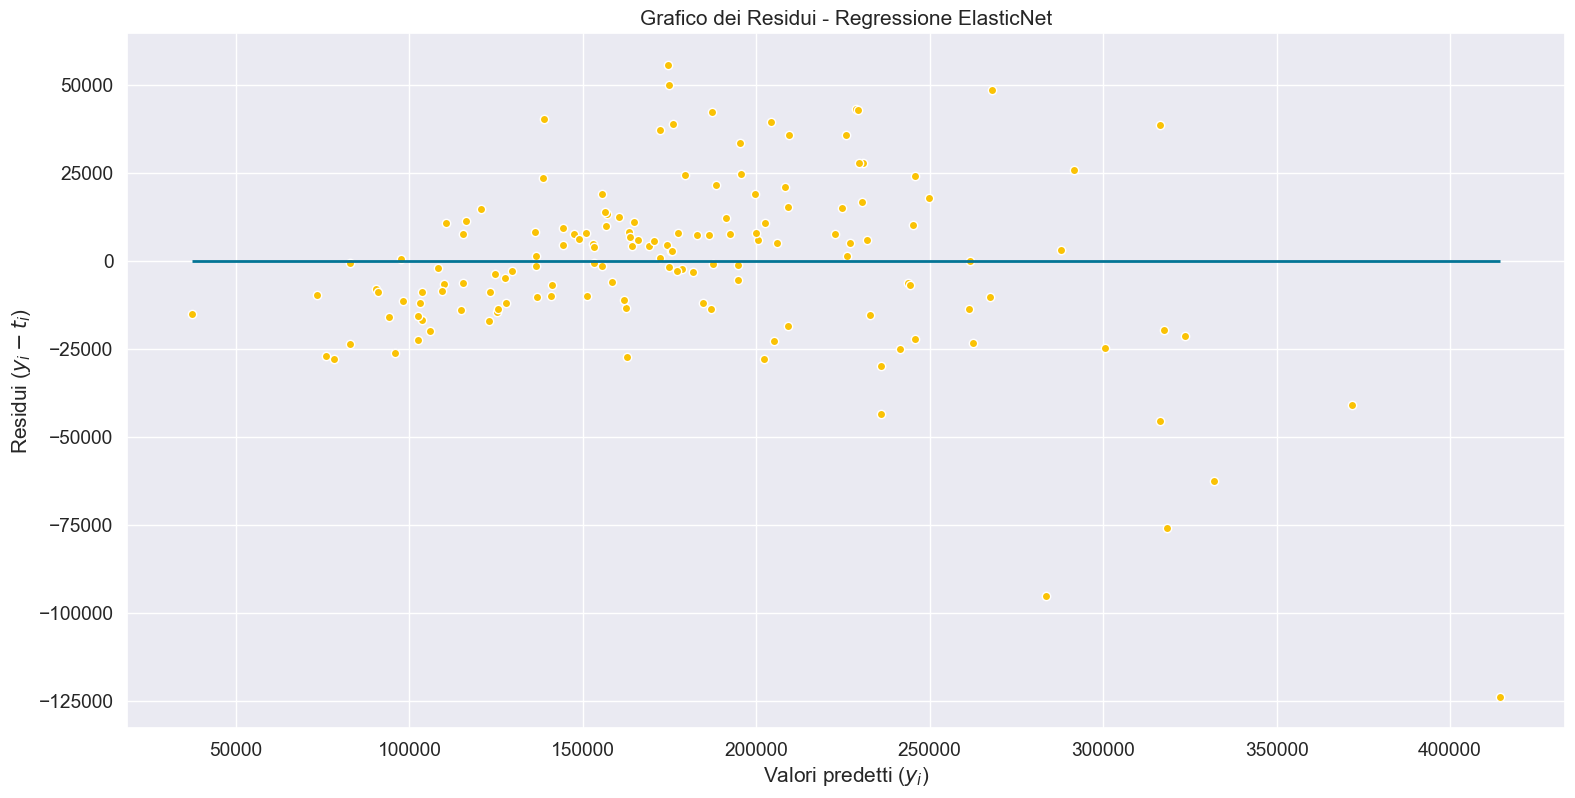

In [88]:
residual_plot(y_pred_elasticnet, dataset.y_test, 'Regressione ElasticNet')

Risulta essere migliore il training set con feature selection.

## 6.6 SVM Regression

Per la regressione SVM, utilizziamo la classe SVR e in particolare selezioniamo i migliori parametri tra i seguenti:

- **Cfloat**: default=1.0. Parametro di regolarizzazione. La forza della regolarizzazione è inversamente proporzionale a C. Deve essere strettamente positivo. La funzione costo è L2.

- **kernel**: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’. Specifica il tipo di funzione kernel da usare nell'algoritmo. 

- **degree**: int, default=3. Grado del polinomio se il kernel è polinomiale. Deve essere non negativo. Viene ignorato da gli altri tipi di kernel diversi da 'poly'.

- **gamma**: {‘scale’, ‘auto’} or float, default=’scale’. Coefficiente Kernel per ‘rbf’, ‘poly’ and ‘sigmoid’.
    - se gamma='scale' (default) $gamma := 1 / (n_{features} \cdot X.var())$,
    - se ‘auto’, $gamma := 1 / n_{features}$
    - se float, $gamma \geq 0$.


In [114]:
from sklearn.model_selection import cross_validate


def svr_cv(X_train: DataFrame, y_train: Series, svm: SVR) -> tuple[Any, ndarray]:
    scores = cross_validate(svm, X_train, y_train, cv=10, scoring=('r2', 'neg_mean_squared_error'),
                            return_train_score=True)
    return scores['train_r2'].mean(), np.sqrt(scores['train_neg_mean_squared_error'].mean())

In [115]:
# classe per mantenere ordinati i parametri di SVR
class SVRParams:
    def __init__(self, C: float, kernel: str, poly_degree: int, gamma: str | float, max_iter: int) -> None:
        self.C = C
        self.kernel = kernel
        self.poly_degree = poly_degree
        self.gamma = gamma
        self.max_iter = max_iter

    def __str__(self):
        return f"C : {self.C:.2f}, kernel : {self.kernel}, poly_degree : {self.poly_degree}, gamma : {self.gamma:.2f}, max_iter : {self.max_iter}"

    def __repr__(self) -> str:
        return self.__str__()

    def default(self):
        return SVRParams(1, 'rbf', 0, 1, -1)

    def create_svr(self):
        return SVR(C=self.C, kernel=self.kernel, degree=self.poly_degree, gamma=self.gamma, max_iter=self.max_iter,
                   tol=0.01)

    def to_array(self, r2: float, rms: float, r2_test: float, rms_test: float):
        return [self.C, self.kernel, self.poly_degree, self.gamma, self.max_iter, r2, rms, r2_test, rms_test]

    def to_dict(self, r2: float, rms: float):
        return {"C": self.C, "kernel": self.kernel, "degree": poly_degree, "gamma": self.gamma,
                "max_iter": self.max_iter, "r2": r2, "rms": rms}


In [125]:
def run_svr(params: SVRParams, folds: List[Fold], scores, curr_iter, total_iterations) -> tuple[
    float, float, DataFrame]:
    # creo il modello dai parametri scelti (mio metodo di utilita')
    svm = params.create_svr()
    r2_score_cv_sum = 0.0
    rms_score_cv_sum = 0.0
    r2_score_sum = 0.0
    rms_score_sum = 0.0
    for f in folds:
        dataset = Dataset(f.X_train, f.y_train, f.X_test, f.y_test)
        # valutazione con cross validation
        r2_score_cv, rms_score_cv = performance_cross_validation(svm, dataset, f.X_train_normalized_fs, scaled=True)
        r2_score_cv_sum += r2_score_cv
        rms_score_cv_sum += rms_score_cv
        # valutazione su testing
        r2_score_test, rms_score_test, _ = performance_test(svm, dataset, f.X_train_normalized_fs,
                                                            f.X_test_normalized_fs,
                                                            scaled=True)
        r2_score_sum += r2_score_test
        rms_score_sum += rms_score_test
    r2_score_cv = r2_score_cv_sum / len(folds)
    rms_score_cv = rms_score_cv_sum / len(folds)
    r2_score = r2_score_sum / len(folds)
    rms_score = rms_score_sum / len(folds)

    # aggiungo al dataframe i parametri appena usati e il punteggio.
    new_row_df = pd.DataFrame([params.to_array(r2_score_cv, rms_score_cv, r2_score, rms_score)],
                              columns=["C", "kernel", "poly_degree", "gamma", 'max_iter', 'r2', 'rms', 'r2_test',
                                       'rms_test'])
    scores = pd.concat([scores, new_row_df], axis=0)

    print(
        f"{curr_iter} of {total_iterations} - PARAMS [{params}] - R2: {r2_score_cv:.6f} - rms: {rms_score_cv} -  R2 Test: {r2_score:.6f} - rms test: {rms_score:.6f}")
    return r2_score, rms_score, scores


# metodo che trova i migliori parametri di SVR
def find_best_svr_params(folds: List[Fold], k_features=129) -> Tuple[
    pd.DataFrame, Tuple[SVRParams, float], float, float]:
    # questi sono i parametri su cui facciamo grid search
    C_values = [0.1, 0.5, 1, 1.5, 2]
    kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
    poly_degree_values = [2, 3]
    gamma_values = [0.1, 1, 4]
    max_iter = -1

    # assegno i tipi numpy e poi trasformo in dataframe
    dtypes = np.dtype(
        [
            ("C", float),
            ("kernel", str),
            ("poly_degree", int),
            ("gamma", float),
            ('max_iter', int),
            ('r2', float),
            ('rms', float),
            ('r2_test', float),
            ('rms_test', float)
        ]
    )
    # calcolo il numero di giri da fare in totale:
    total_iterations = (len(C_values) * len(gamma_values)) * (len(poly_degree_values) + len(kernel_values) - 1)
    curr_iter = 0

    # eseguiamo la feature selection su tutti i fold e manteniamola in memoria, per ridurre il tempo di esecuzione totale
    folds = do_fs_for_each_fold(folds, k_features)

    scores: pd.DataFrame[float, str, int, float, int, float, float, float, float] = pd.DataFrame(
        np.empty(0, dtype=dtypes))
    best_score_params = {}
    best_r2 = 0.0
    best_rms = 0.0
    # troviamo i migliori parametri
    for c in C_values:
        for kernel in kernel_values:
            for gamma in gamma_values:
                if kernel == 'poly':
                    for poly_degree in poly_degree_values:
                        curr_iter += 1
                        # metto insieme i parametri nella classe, per comodita'
                        params = SVRParams(c, kernel, poly_degree, gamma, max_iter)
                        r2_score, rms_score, scores = run_svr(params, folds, scores, curr_iter, total_iterations)
                        if r2_score > best_r2:
                            best_r2 = r2_score
                            best_rms = rms_score
                            best_score_params = params.to_dict(r2_score, rms_score)

                else:
                    curr_iter += 1
                    # metto insieme i parametri nella classe, per comodita'. Il degree e' sempre 0
                    params = SVRParams(c, kernel, 0, gamma, max_iter)
                    r2_score, rms_score, scores = run_svr(params, folds, scores, curr_iter, total_iterations)
                    if r2_score > best_r2:
                        best_r2 = r2_score
                        best_rms = rms_score
                        best_score_params = params.to_dict(r2_score, rms_score)

    return best_score_params, scores, best_r2, best_rms

In [209]:
k = 129
best_score_params_svr, scores_svr, best_r2, best_rms, y_pred_svm = find_best_svr_params(folds, k_features=k)
print(f"The BESTEST model is: {best_score_params_svr}")

Feature selection... Done
1 of 75 - PARAMS [C : 0.10, kernel : linear, poly_degree : 0, gamma : 0.10, max_iter : -1] - R2: -0.030938 - rms: 80619.63493132466 -  R2 Test: -0.033512 - rms test: 80180.572545
2 of 75 - PARAMS [C : 0.10, kernel : linear, poly_degree : 0, gamma : 1.00, max_iter : -1] - R2: -0.030938 - rms: 80619.63493132466 -  R2 Test: -0.033512 - rms test: 80180.572545
3 of 75 - PARAMS [C : 0.10, kernel : linear, poly_degree : 0, gamma : 4.00, max_iter : -1] - R2: -0.030938 - rms: 80619.63493132466 -  R2 Test: -0.033512 - rms test: 80180.572545
4 of 75 - PARAMS [C : 0.10, kernel : poly, poly_degree : 2, gamma : 0.10, max_iter : -1] - R2: -0.047836 - rms: 81277.59875909032 -  R2 Test: -0.052202 - rms test: 80895.072278
5 of 75 - PARAMS [C : 0.10, kernel : poly, poly_degree : 3, gamma : 0.10, max_iter : -1] - R2: 0.008004 - rms: 79082.27430349591 -  R2 Test: -0.013743 - rms test: 79404.013219
6 of 75 - PARAMS [C : 0.10, kernel : poly, poly_degree : 2, gamma : 1.00, max_iter :

In [ ]:
residual_plot(y_pred_svm, dataset.y_test, 'SVR')

In [52]:
# pars_svr = BestParameters("SVM Regression", k, 0.0, best_score_params_svr, best_r2, best_rms, None)
pars_svr = BestParameters("SVM Regression", 129, 0.0, best_score_params_svr, 0.6619067965961025, 45572.50279942541,
                          None)
parameters.append(pars_svr)

In [68]:
# NON CANCELLARE - serve per non perdere tempo a rieseguire ogni volta
scores_svr = {
    'C': [0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.50, 0.50, 0.50,
          0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00,
          1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50,
          1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 2.00, 2.00, 2.00, 2.00, 2.00, 2.00, 2.00, 2.00, 2.00, 2.00, 2.00, 2.00,
          2.00, 2.00, 2.00],
    'kernel': ["linear", "linear", "linear", "poly", "poly", "poly", "poly", "poly", "poly", "rbf", "rbf", "rbf",
               "sigmoid", "sigmoid", "sigmoid", "linear", "linear", "linear", "poly", "poly", "poly", "poly", "poly",
               "poly", "rbf", "rbf", "rbf", "sigmoid", "sigmoid", "sigmoid", "linear", "linear", "linear", "poly",
               "poly", "poly", "poly", "poly", "poly", "rbf", "rbf", "rbf", "sigmoid", "sigmoid", "sigmoid", "linear",
               "linear", "linear", "poly", "poly", "poly", "poly", "poly", "poly", "rbf", "rbf", "rbf", "sigmoid",
               "sigmoid", "sigmoid", "linear", "linear", "linear", "poly", "poly", "poly", "poly", "poly", "poly",
               "rbf", "rbf", "rbf", "sigmoid", "sigmoid", "sigmoid"],
    'gamma': [0.10, 1.00, 4.00, 0.10, 0.10, 1.00, 1.00, 4.00, 4.00, 0.10, 1.00, 4.00, 0.10, 1.00, 4.00, 0.10, 1.00,
              4.00, 0.10, 0.10, 1.00, 1.00, 4.00, 4.00, 0.10, 1.00, 4.00, 0.10, 1.00, 4.00, 0.10, 1.00, 4.00, 0.10,
              0.10, 1.00, 1.00, 4.00, 4.00, 0.10, 1.00, 4.00, 0.10, 1.00, 4.00, 0.10, 1.00, 4.00, 0.10, 0.10, 1.00,
              1.00, 4.00, 4.00, 0.10, 1.00, 4.00, 0.10, 1.00, 4.00, 0.10, 1.00, 4.00, 0.10, 0.10, 1.00, 1.00, 4.00,
              4.00, 0.10, 1.00, 4.00, 0.10, 1.00, 4.00],
    'r2': [-0.030938, -0.030938, -0.030938, -0.047836, 0.008004, 0.188916, 0.988291, 0.835069, 0.999969, -0.051199,
           -0.051199, -0.051199, -0.050374, -0.050252, -0.050250, 0.043285, 0.043285, 0.043285, -0.034365, 0.156743,
           0.609197, 0.999291, 0.961535, 0.999986, -0.051190, -0.051192, -0.051192, -0.047049, -0.046451, -0.046445,
           0.124477, 0.124477, 0.124477, -0.018245, 0.282279, 0.767856, 0.999778, 0.981736, 0.999987, -0.051180,
           -0.051183, -0.051183, -0.042947, -0.041721, -0.041707, 0.190095, 0.190095, 0.190095, -0.003260, 0.377667,
           0.827049, 0.999869, 0.988697, 0.999987, -0.051169, -0.051174, -0.051174, -0.038829, -0.037049, -0.037023,
           0.249071, 0.249071, 0.249071, 0.011295, 0.456382, 0.860832, 0.999901, 0.992135, 0.999988, -0.051159,
           -0.051165, -0.051165, -0.034753, -0.032400, -0.032371],
    'rms': [80619.63493132466, 80619.63493132466, 80619.63493132466, 81277.59875909032, 79082.27430349591,
            71506.97516462737, 8553.074005422484, 32225.852382753692, 393.05728588008407, 81407.89032980999,
            81407.90260804487, 81407.90272725876, 81375.94168107965, 81371.2119628305, 81371.15960350385,
            77663.3533258768, 77663.3533258768, 77663.3533258768, 80753.4932088808, 72909.95483515914,
            49619.43772221328, 2081.7427431422343, 15542.9178571227, 227.0935414931767, 81407.56478577887,
            81407.62605801653, 81407.6266540685, 81247.05073924879, 81223.84420869769, 81223.61408810294,
            74295.13733933147, 74295.13733933147, 74295.13733933147, 80121.79435564153, 67257.98720701085,
            38234.88324368257, 1149.9621638688543, 10697.325613944915, 213.12600110524514, 81407.15746431677,
            81407.28037232796, 81407.28156438582, 81087.68409254527, 81039.97553918898, 81039.41207391894,
            71456.90795679056, 71456.90795679056, 71456.90795679056, 79530.257048455, 62624.535871147134,
            33000.1377203933, 866.4364201963305, 8406.641301118492, 211.1499497557921, 81406.75011589061,
            81406.93468869386, 81406.93647670886, 80927.486453443, 80858.1155983258, 80857.11754703017,
            68805.9774767959, 68805.9774767959, 68805.9774767959, 78951.41984000427, 58525.28794019341,
            29601.127374498563, 738.9366524720843, 7003.937103954352, 203.91914236272837, 81406.34272120155,
            81406.58900711211, 81406.59139103765, 80768.63470906632, 80676.7935808189, 80675.66943402504]
}

In [69]:
# print(best_score_params_svr)
# 
best_score_params_svr = {'C': 2, 'kernel': 'poly', 'degree': 3, 'gamma': 1, 'max_iter': -1, 'r2': 0.6619067965961025,
                         'rms': 45572.50279942541}

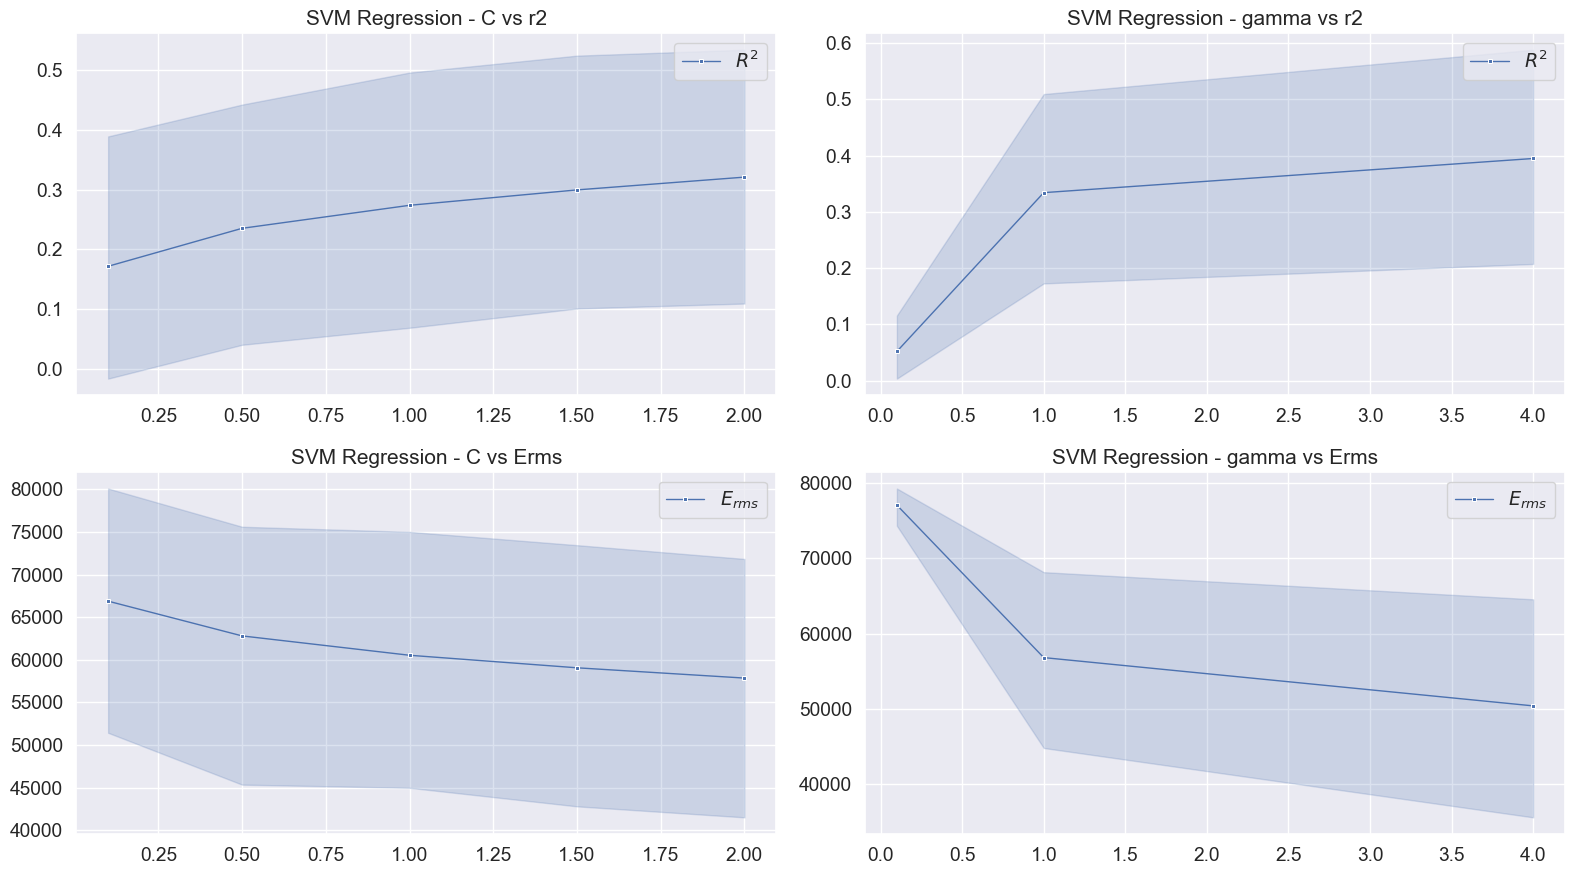

In [70]:
plt.figure(figsize=(16, 9))
plt.subplot(2, 2, 1)
simple_plot_scores(x=scores_svr["C"], y=scores_svr["r2"], label="$R^2$", title="SVM Regression - C vs r2")
plt.subplot(2, 2, 2)
simple_plot_scores(x=scores_svr["gamma"], y=scores_svr["r2"], label="$R^2$", title="SVM Regression - gamma vs r2")
plt.subplot(2, 2, 3)
simple_plot_scores(x=scores_svr["C"], y=scores_svr["rms"], label="$E_{rms}$", title="SVM Regression - C vs Erms")
plt.subplot(2, 2, 4)
simple_plot_scores(x=scores_svr["gamma"], y=scores_svr["rms"], label="$E_{rms}$",
                   title="SVM Regression - gamma vs Erms")
plt.tight_layout()  # fa in modo che ci sia spazio tra un plot e l'altro

Le performance del training e test sul modello coi migliori parametri.

### Performance training

In [71]:
mean_r2 = 0.0
mean_rms = 0.0
svm_regression = SVRParams(pars_svr.other['C'], pars_svr.other['kernel'], pars_svr.other['degree'],
                           pars_svr.other['gamma'], pars_svr.other['max_iter']).create_svr()
for i in range(0, len(folds)):
    dataset = Dataset(folds[i].X_train, folds[i].y_train, folds[i].X_test, folds[i].y_test)
    r2_cv_svm, rms_cv_svm = performance_cross_validation(svm_regression, dataset)
    print(f"SVM Regression CV -> r2 = {r2_cv_svm} rms = {rms_cv_svm}")
    mean_r2 += r2_cv_svm
    mean_rms += rms_cv_svm
mean_r2 = mean_r2 / len(folds)
mean_rms = mean_rms / len(folds)
print(f"SVM Regression mean CV: r2 = {mean_r2} rms = {mean_rms}")

NameError: name 'pars_svr' is not defined

### Performance testing

In [ ]:
mean_r2 = 0.0
mean_rms = 0.0
svm_regression = SVRParams(pars_svr.other['C'], pars_svr.other['kernel'], pars_svr.other['degree'],
                           pars_svr.other['gamma'], pars_svr.other['max_iter']).create_svr()
for i in range(0, len(folds)):
    dataset = Dataset(folds[i].X_train, folds[i].y_train, folds[i].X_test, folds[i].y_test)
    r2_svm, rms_svm, y_pred_svm = performance_test(svm_regression, dataset)
    print(f"SVM Regression Test -> r2 = {r2_svm} rms = {rms_svm}")
    mean_r2 += r2_svm
    mean_rms += rms_svm
mean_r2 = mean_r2 / len(folds)
mean_rms = mean_rms / len(folds)
print(f"SVM Regression mean Test: r2 = {mean_r2} rms = {mean_rms}")

In [ ]:
residual_plot(y_pred_svm, dataset.y_test, 'SVR')

## 6.7 KNN
Metodo parametrico.

Dato che stiamo trattando un modello di regressione, prendiamo in considerazione il modello KNeighborsRegressor  basato sul concetto di **"nearest neighbors"**. In pratica, l'algoritmo cerca i K campioni più simili al punto di input di cui vogliamo stimare l'output (ovvero la variabile dipendente) e ne calcola la media.
I parametri sono:
- **n_neighbors**: indica il numero di vicini più vicini per la stima di un punto. Un valore alto porta a una decisione più stabile ma potenzialmente meno accurata. Al contrario, un valore basso di n_neighbors porta a decisioni più flessibili, ma più soggette al rumore nei dati.

- **weights**: indica il peso assegnato a ciascun vicino più prossimo. I possibili valori sono:
  - **'uniform'**, dove tutti i vicini hanno lo stesso peso;
  - **'distance'**, dove il peso di un vicino diminuisce all'aumentare della distanza dal punto di stima.

- **algorithm**: indica l'algoritmo utilizzato per trovare i vicini. I possibili valori sono:
    - **'ball_tree'**, che utilizza un albero di sfere per trovare i vicini più prossimi;
    - **'kd_tree'**, che utilizza un albero KD per trovare i vicini più prossimi;
    - **'brute'**, se il numero di punti è relativamente piccolo,  calcola esplicitamente le distanze tra tutti i punti e seleziona i vicini più prossimi.
- **p**: indica il tipo di distanza.
    - se p=1, utilizza la distanza di Manhattan;
    - se p=2, utilizza la distanza Euclidea;
    - se p arbitrario si utilizza la distanza Minkowski.


### 6.7.1 GridSearch

In [89]:
knn_gs = KNeighborsRegressor()
params_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # Distance -> 1: Manhattan, 2: Euclidean, 3: Minkowski
}
r2_gs_knn, best_param_knn = grid_search(knn_gs, dataset, params_knn)
print(f"KNN regression -> r2: {r2_gs_knn} - best parameters: {best_param_knn}")


KNN regression -> r2: 0.6575871790751037 - best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}


### 6.7.2 Performance training
Eseguendo cross validation su un singolo fold che per ogni fold, $r^2$ è uguale a 1 e questo potrebbe essere un segnale di overfitting. Evidentemente, troppi parametri nel modello tendono ad addestrare molto bene  adattando perfettamente il modello ai dati di training, senza alcun errore; quindi, proviamo a ridurre la complessità del modello considerando solo il numero di vicini (**n_neighbors**):

In [90]:
n_neighbors = 3

In [99]:
#knn_regression = KNeighborsRegressor(n_neighbors=best_param_knn['n_neighbors'], weights=best_param_knn['weights'], algorithm=best_param_knn['algorithm'], p=best_param_knn['p'])
knn_regression_one = KNeighborsRegressor(n_neighbors=n_neighbors)
r2_cv_knn, rms_cv_knn = performance_cross_validation(knn_regression_one, dataset)
print(f"KNN Regression -> r2 = {r2_cv_knn} rms = {rms_cv_knn}")

KNN Regression -> r2 = 0.8082704231588324 rms = 35059.53540870063


In [92]:
mean_r2 = 0.0
mean_rms = 0.0
scores_train_knn = {'r2_train': [], 'rms_train': []}
knn_regression_all = KNeighborsRegressor(n_neighbors=n_neighbors)
for i in range(0, len(folds)):
    dataset = Dataset(folds[i].X_train, folds[i].y_train, folds[i].X_test, folds[i].y_test)
    r2_cv_knn, rms_cv_knn = performance_cross_validation(knn_regression_all, dataset, scaled=True)
    print(f"KNN Regression CV -> r2 = {r2_cv_knn} rms = {rms_cv_knn}")
    mean_r2 += r2_cv_knn
    mean_rms += rms_cv_knn
    scores_train_knn['r2_train'].append(mean_r2)
    scores_train_knn['rms_train'].append(mean_rms)
mean_r2 = mean_r2 / len(folds)
mean_rms = mean_rms / len(folds)
print(f"KNN Regression mean CV: r2 = {mean_r2} rms = {mean_rms}")

KNN Regression CV -> r2 = 0.8003339108425316 rms = 34579.642162426375
KNN Regression CV -> r2 = 0.7739355031571176 rms = 37783.92911074718
KNN Regression CV -> r2 = 0.7787381811067347 rms = 37578.984262027996
KNN Regression CV -> r2 = 0.7794944318465309 rms = 36694.0361871492
KNN Regression CV -> r2 = 0.7860439944819216 rms = 37110.05389978118
KNN Regression CV -> r2 = 0.7884023968135391 rms = 36636.52436339544
KNN Regression CV -> r2 = 0.7870902219657527 rms = 36327.52248625996
KNN Regression CV -> r2 = 0.7809240808086783 rms = 37482.3242357938
KNN Regression CV -> r2 = 0.7782772865303523 rms = 37779.467847985245
KNN Regression CV -> r2 = 0.784327937862113 rms = 37181.91110221024
KNN Regression mean CV: r2 = 0.7837567945415271 rms = 36915.439565777655


### 6.7.3 Performance test

Considerare tutti i parametri per la valutazione del test porta ad avere un $r^2$ molto scarso; questa è la conferma che il modello è in overfitting e non è in grado di generalizzare bene su nuovi dati di test.

Consideriamo solo **n_neighbors**:

In [93]:
mean_r2 = 0.0
mean_rms = 0.0
scores_test_knn = {'r2_test': [], 'rms_test': []}
for i in range(0, len(folds)):
    dataset = Dataset(folds[i].X_train, folds[i].y_train, folds[i].X_test, folds[i].y_test)
    r2_knn, rms_knn, y_pred_knn = performance_test(knn_regression_all, dataset)
    print(f"KNN Regression Test -> r2 = {r2_knn} rms = {rms_knn}")
    mean_r2 += r2_knn
    mean_rms += rms_knn
    scores_test_knn['r2_test'].append(mean_r2)
    scores_test_knn['rms_test'].append(mean_rms)
mean_r2 = mean_r2 / len(folds)
mean_rms = mean_rms / len(folds)
print(f"KNN Regression mean Test: r2 = {mean_r2} rms = {mean_rms}")

KNN Regression Test -> r2 = 0.6871425385169154 rms = 53464.623213620696
KNN Regression Test -> r2 = 0.6961910239092368 rms = 43300.90900519942
KNN Regression Test -> r2 = 0.671169148619525 rms = 42856.34899615296
KNN Regression Test -> r2 = 0.633547961654348 rms = 54098.15146068033
KNN Regression Test -> r2 = 0.5891609270836289 rms = 45745.14199939597
KNN Regression Test -> r2 = 0.40952112075571767 rms = 59101.93645016902
KNN Regression Test -> r2 = 0.6985091951265134 rms = 46698.17080665167
KNN Regression Test -> r2 = 0.6346300031083015 rms = 44034.68098882597
KNN Regression Test -> r2 = 0.55066878940165 rms = 47904.08454900198
KNN Regression Test -> r2 = 0.5910842045866611 rms = 46751.12408466351
KNN Regression mean Test: r2 = 0.6161624912762498 rms = 48395.51715543615


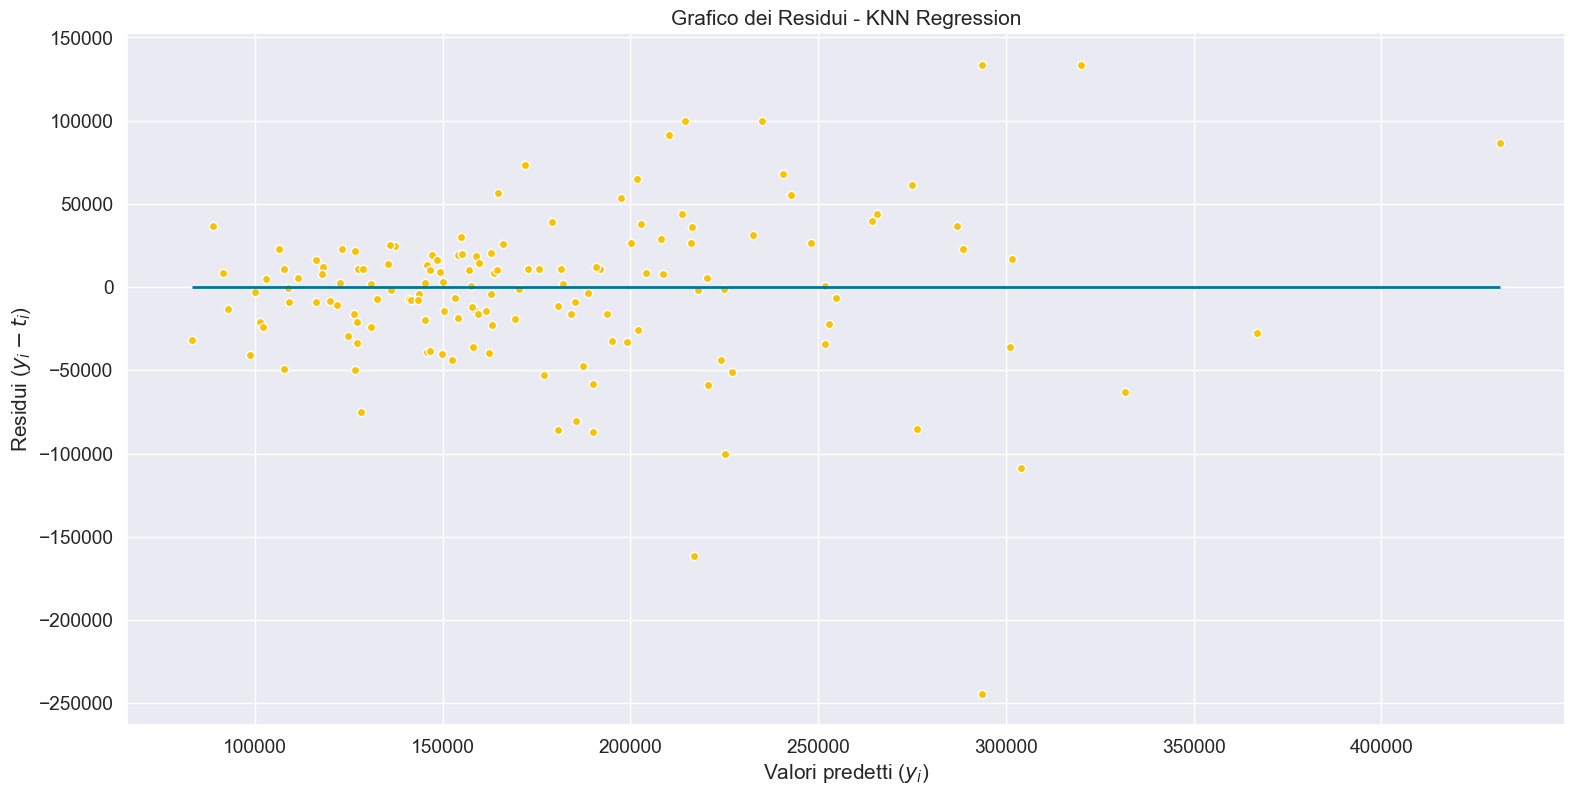

In [94]:
residual_plot(y_pred_knn, dataset.y_test, 'KNN Regression')

### 6.7.4 Performance test con pca, con/senza feature selection

In [95]:
knn_pca_fs = KNeighborsRegressor(n_neighbors=5)

X_train_pca, X_test_pca, X_train_pca, X_test_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=False)
score1_knn, _, y_pred_knn1 = run_regression_train_test("knn with PCA", knn_pca_fs, dataset, X_train_pca,
                                                       X_test_pca, scaled=False)
score2_knn, _, y_pred_knn2 = run_regression_train_test("knn with FS and PCA", knn_pca_fs, dataset,
                                                       X_train_pca, X_test_pca, scaled=False)

Feature ridotte da 220 con PCA:  (1314, 4)
Feature selezionate:  (1314, 10)
Feature ridotte da 104 con MI e PCA:  (1314, 4)
knn with PCA - r2: 0.7518679053172173 - rms: 39888.887953543825
knn with PCA - r2 test: 0.6614090114291487 - rms test: 42541.50127210994
knn with FS and PCA - r2: 0.7495028486697539 - rms: 40068.45671472349
knn with FS and PCA - r2 test: 0.6350364218408489 - rms test: 44167.20094600046


Utilizzare feature selection e pca porta ad avere un $r^2$ migliore.

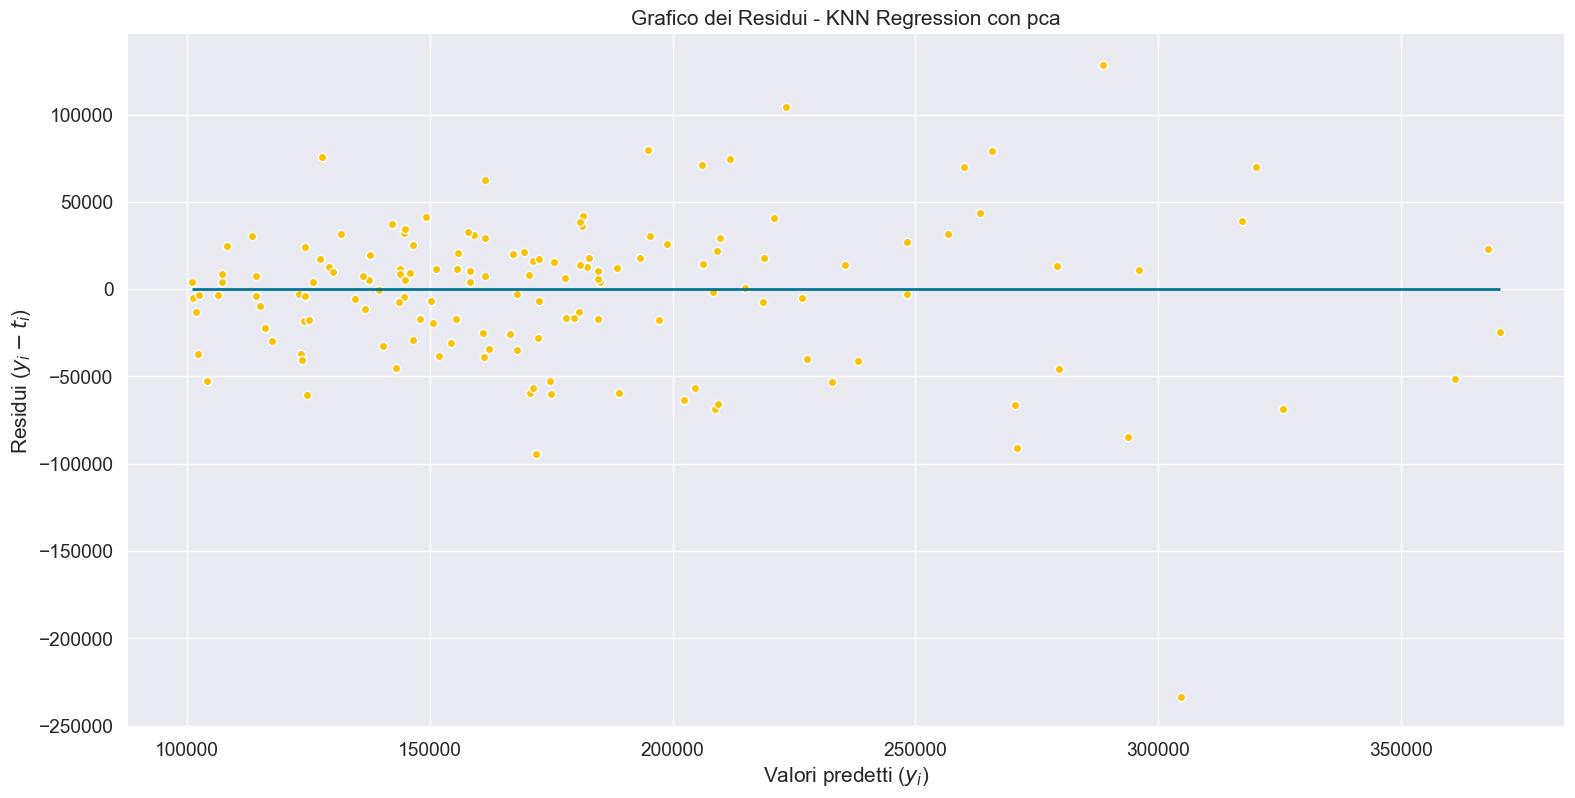

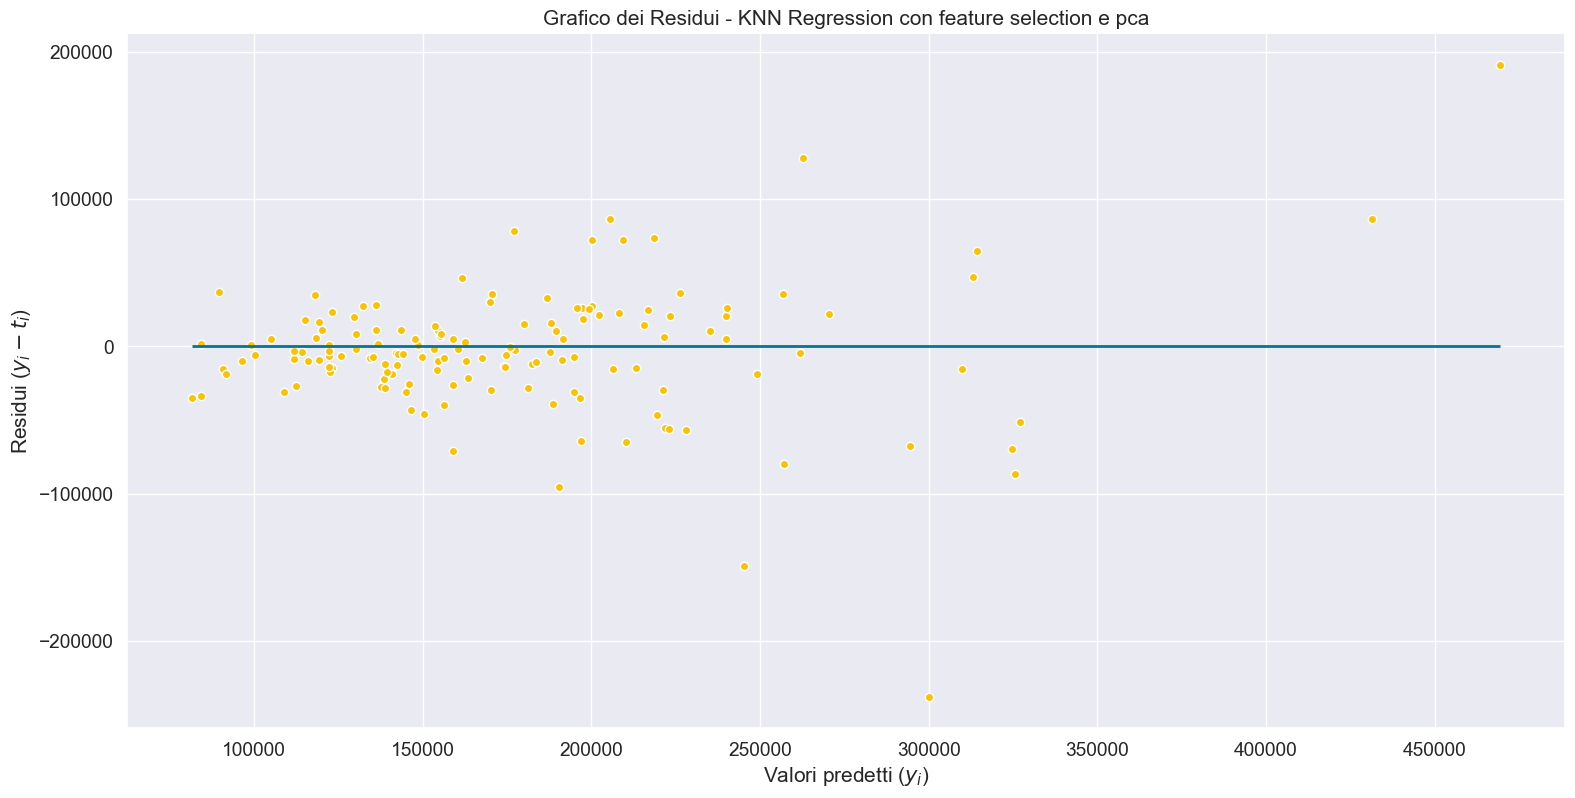

In [96]:
residual_plot(y_pred_knn1, dataset.y_test, 'KNN Regression con pca')
residual_plot(y_pred_knn2, dataset.y_test, 'KNN Regression con feature selection e pca')

## 6.7 Kernel Regression (Nadaraya Watson)
Come KNN, anche la Kernel Regression di Nadaraya Watson è un **Metodo parametrico**, in cui la predizione avviene facendo riferimento direttamente agli elementi del training set, senza la necessità di addestrare un modello. 
Innanzitutto dobbiamo definire una funzione kernel $\kappa_h (x)$ con due caratteristiche:
- non nulla solo in un itervallo intorno allo $0$ di ampiezza $h$ (_banda del kernel_)
- massima in $0$

Per eseguire la regressione kernel Nadaraya-Watson abbiamo bisogno di questa libreria:

In [1]:
% pip install scikit-fda

  Using cached scikit_fda-0.8.1-py3-none-any.whl (398 kB)
  Using cached rdata-0.9-py3-none-any.whl (19 kB)
  Using cached fdasrsf-2.4.0-cp310-cp310-win_amd64.whl (428 kB)
  Using cached GPy-1.10.0.tar.gz (959 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for GPy: filename=GPy-1.10.0-cp310-cp310-win_amd64.whl size=1405221 sha256=2401ae24ad162eef56f4579354a4199e128507a2286054f323bd20915edad530
  Stored in directory: c:\users\emeli\appdata\local\pip\cache\wheels\1c\13\d2\18ba56e6f6bf00c6f1562724da66f84537d17febb0415c4aa7
Successfully built GPy
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
from skfda.misc.hat_matrix import (
    KNeighborsHatMatrix,
    LocalLinearRegressionHatMatrix,
    NadarayaWatsonHatMatrix,
)
from skfda.ml.regression._kernel_regression import KernelRegression

### 6.7.1 NadarayaWatsonHatMatrix

In [61]:
def get_bandwidth(scaled=True):
    if scaled:
        bandwidth = np.logspace(-2, 0,
                                num=20)  # 100 numeri da 10^-2=0.01 a 1=10^0. Questo funziona meglio se scaled=True
    else:
        bandwidth = np.logspace(0, 3, 20)  # numeri da 10^0 a 10^5 # questo funziona meglio se scaled=False
    return bandwidth

In [62]:
# bandwidth = [0.1, 0.5, 1.0, 1.5]
# TODO: non capisco perché questo codice non funziona mentre qullo sotto sì... cosa cambia?
# kernel_regr = KernelRegression(kernel_estimator=NadarayaWatsonHatMatrix()),
# params_krnw = {'kernel_estimator__bandwidth': bandwidth} # Nota: usiamo __ per distinguere il parametro del kernel_estimator
# gs_kernel_regr = GridSearchCV(kernel_regr, params_krnw) # , scoring="r2", return_train_score=True)
# gs_kernel_regr.fit(dataset.X_train, dataset.y_train)
# r2_gs_krnw = gs_kernel_regr.best_score_

scaled = True  # meglio scaled (r2 = 0.73)
bandwidth = get_bandwidth(scaled=scaled)

nw = GridSearchCV(
    KernelRegression(kernel_estimator=NadarayaWatsonHatMatrix()),
    param_grid={'kernel_estimator__bandwidth': bandwidth},
)

X_train_pca, X_test_pca, X_train_pca, X_test_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=scaled)
X_train_pca = X_train_pca.to_numpy()
nw.fit(X_train_pca, dataset.y_train)

print(
    'Best Nadaraya-Watson bandwidth:',
    nw.best_params_['kernel_estimator__bandwidth'],
    nw.best_score_
)

Feature ridotte da 220 con PCA:  (1168, 4)
Feature selezionate:  (1168, 10)
Feature ridotte da 104 con MI e PCA:  (1168, 4)
Best Nadaraya-Watson bandwidth: 0.4832930238571752 0.714025104671074


#### 6.7.1.1 Predizione sul miglior modello

In [63]:
# gridSearchCV, dopo il fit, permette di usare direttamente il miglior modello con predict.
y_pred_nw = nw.predict(X_test_pca.to_numpy())  # a quanto pare i DataFrame non gli piacciono
nw_res = r2_score(y_pred_nw, dataset.y_test.to_numpy())
print('Score NW:', nw_res)

Score NW: 0.6676115523045201


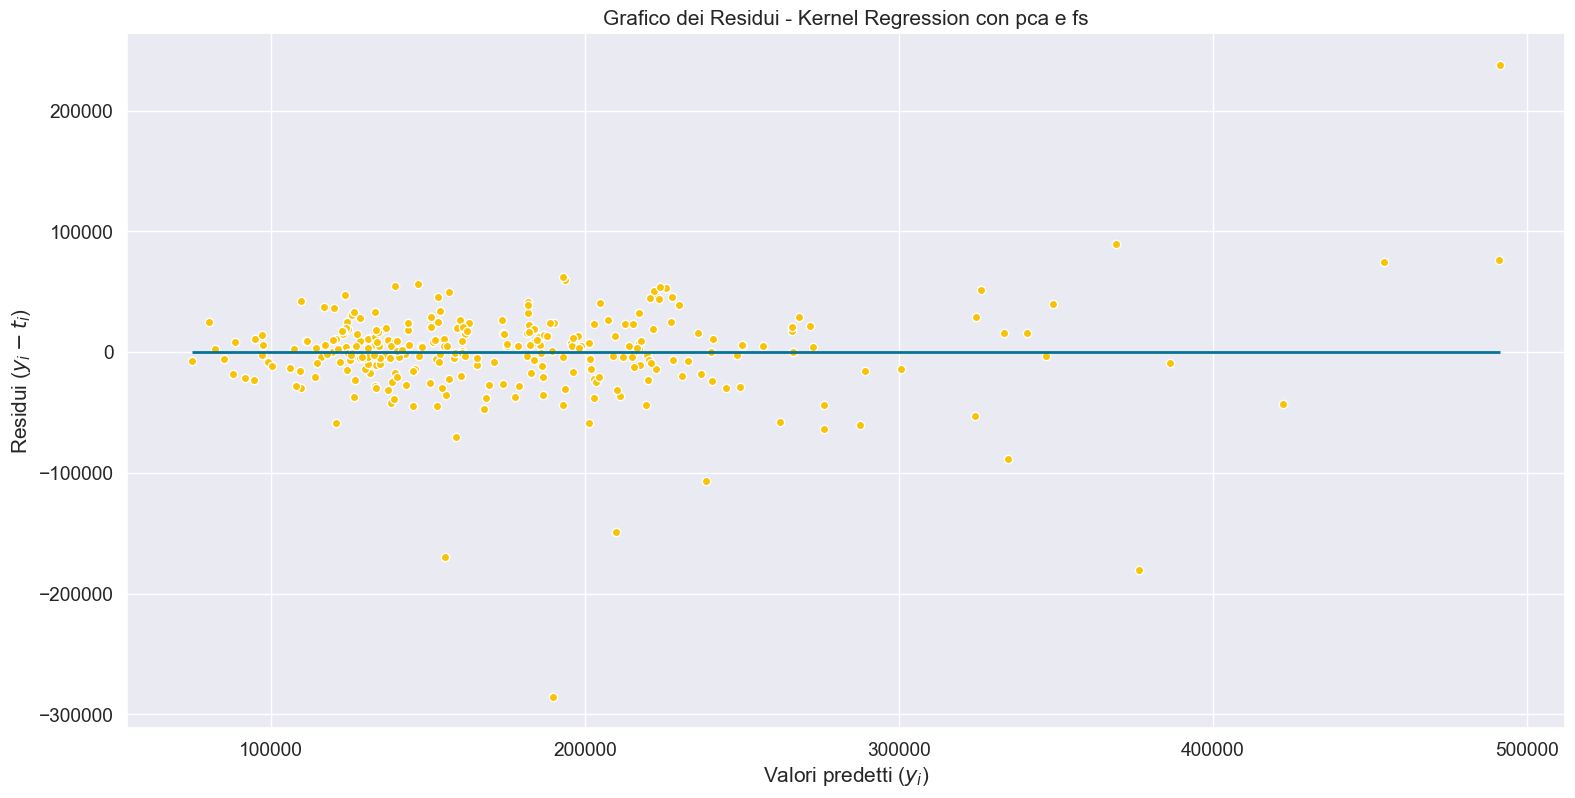

In [64]:
residual_plot(y_pred_nw, dataset.y_test, 'Kernel Regression con pca e fs')

### 6.7.2 KNeighborsHatMatrix

In [65]:
scaled = True  # meglio scaled (r2 = 0.73)
n_neighbors = np.array(range(1, 100))

hm = GridSearchCV(
    KernelRegression(kernel_estimator=KNeighborsHatMatrix()),
    param_grid={'kernel_estimator__n_neighbors': n_neighbors},
)

X_train_pca, X_test_pca, X_train_pca, X_test_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=scaled)
X_train_pca = X_train_pca.to_numpy()
hm.fit(X_train_pca, dataset.y_train)

print(
    'Best Nadaraya-Watson parameters:',
    hm.best_params_['kernel_estimator__n_neighbors'],
    hm.best_score_
)

Feature ridotte da 220 con PCA:  (1168, 4)
Feature selezionate:  (1168, 10)
Feature ridotte da 104 con MI e PCA:  (1168, 4)
Best Nadaraya-Watson parameters: 17 0.7751767212515867


#### 6.7.2.1 Predizione sul miglior modello

In [66]:
y_pred_hm = hm.predict(X_test_pca.to_numpy())  # a quanto pare i DataFrame non gli piacciono
hm_res = r2_score(y_pred_hm, dataset.y_test.to_numpy())
print('Score NW:', hm_res)

Score NW: 0.7574893272823358


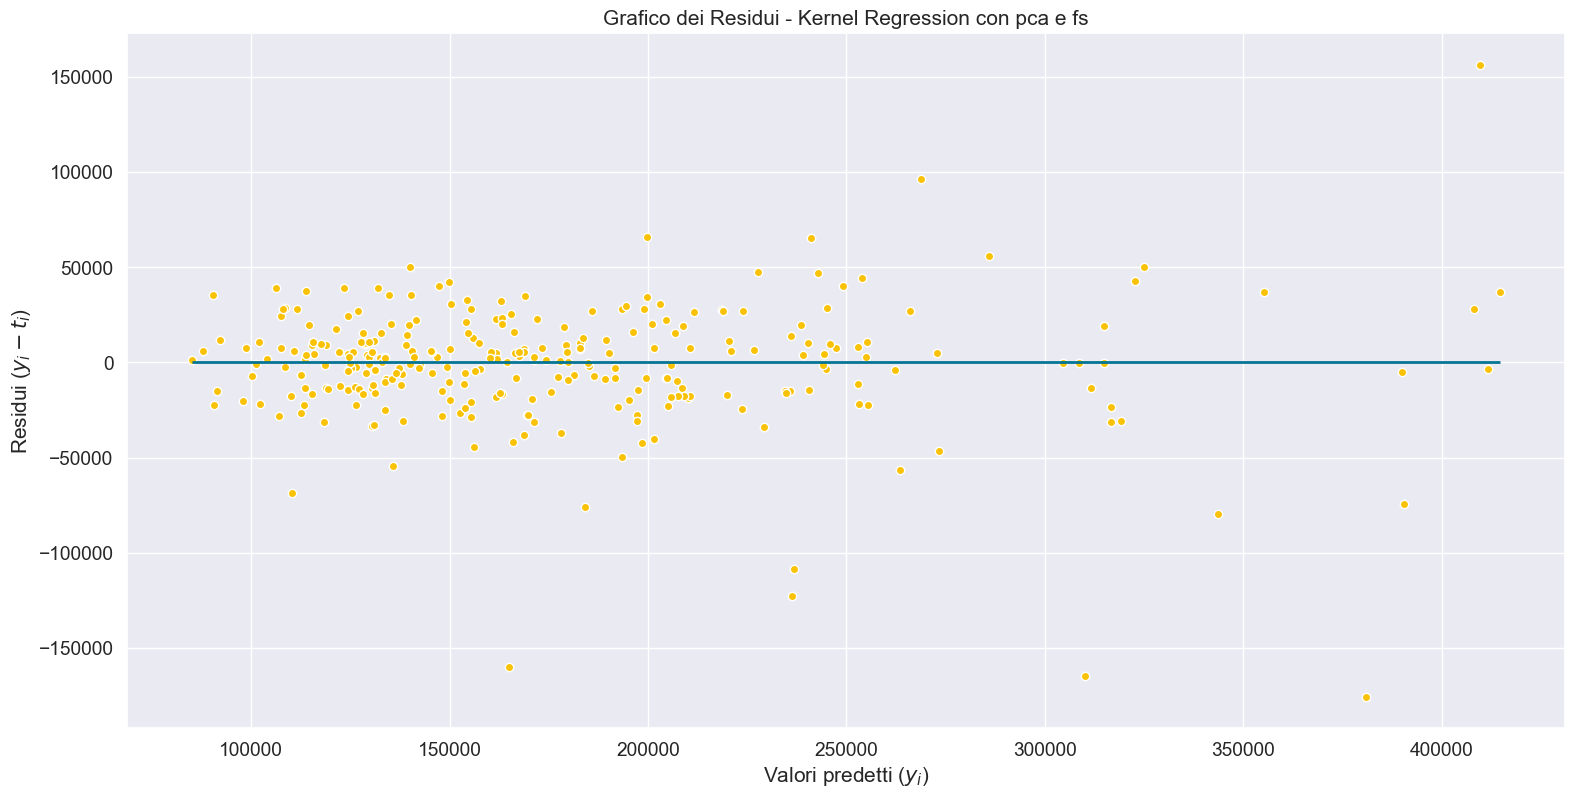

In [67]:
residual_plot(y_pred_hm, dataset.y_test, 'Kernel Regression con pca e fs')

### 6.7.3 LocalLinearRegressionHatMatrix

In [56]:
from scipy.fft import fft

scaled = True
bandwidth = np.logspace(0.3, 1, num=100)

llr = GridSearchCV(
    KernelRegression(kernel_estimator=LocalLinearRegressionHatMatrix()),
    param_grid={'kernel_estimator__bandwidth': bandwidth},
)

X_train_pca, X_test_pca, X_train_pca, X_test_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=scaled)
X_train_pca = X_train_pca.to_numpy()

# applico Fourier
X_train_pca = fft(X_train_pca)

llr.fit(X_train_pca, dataset.y_train)

print(
    'Best Nadaraya-Watson parameters:',
    llr.best_params_['kernel_estimator__bandwidth'],
    llr.best_score_
)

Feature ridotte da 220 con PCA:  (1168, 4)
Feature selezionate:  (1168, 10)
Feature ridotte da 104 con MI e PCA:  (1168, 4)
Best Nadaraya-Watson parameters: 5.939328873072055 0.5033427248321785


#### 6.7.3.1 Predizione sul miglior modello

In [57]:
y_pred_llr = llr.predict(X_test_pca.to_numpy())  # a quanto pare i DataFrame non gli piacciono
llr_res = r2_score(y_pred_llr, dataset.y_test.to_numpy())
print('Score NW:', llr_res)

Score NW: -2.952013708357615


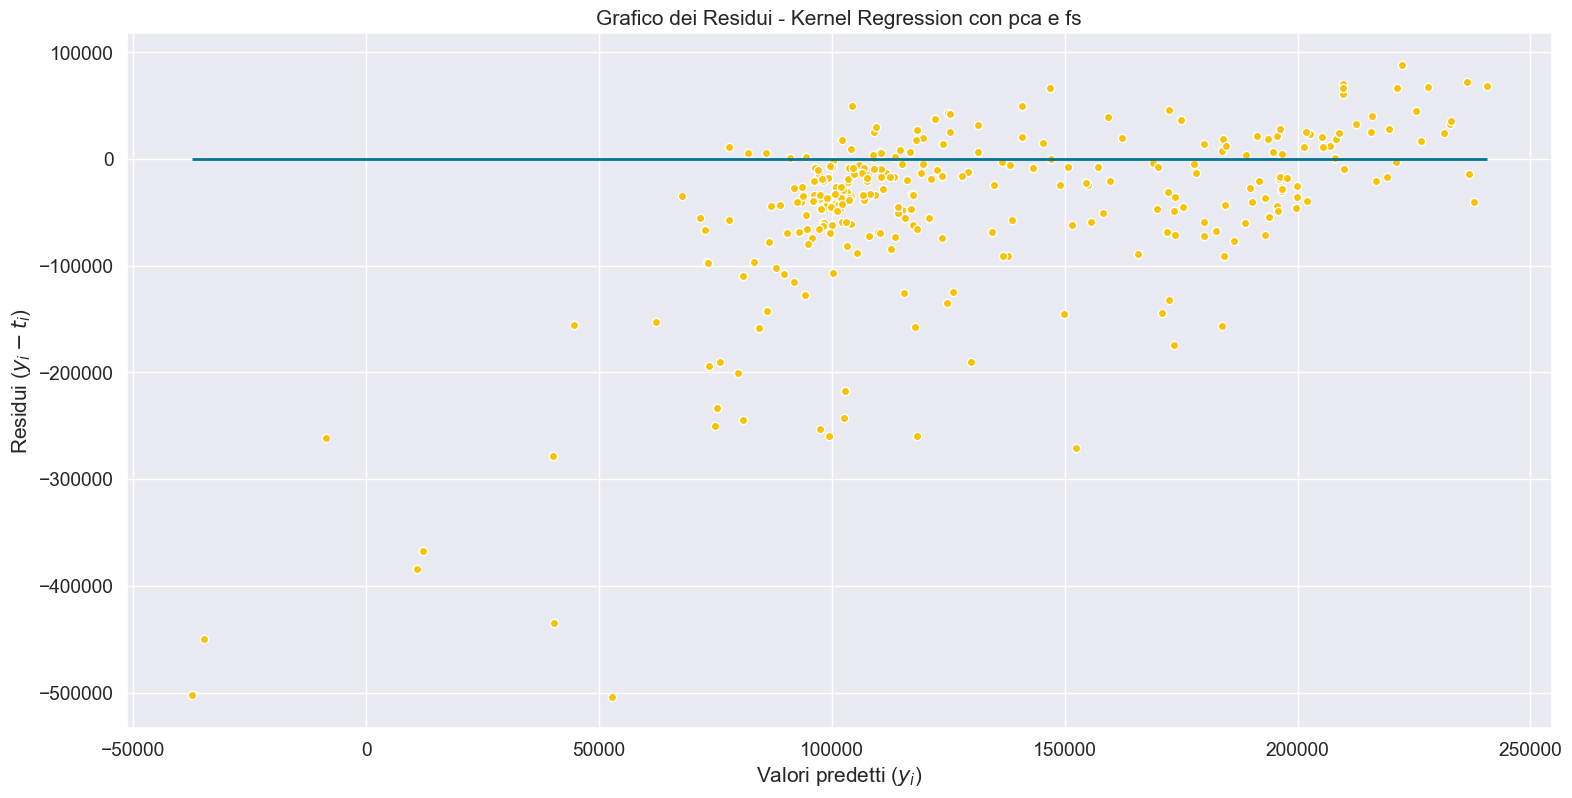

In [58]:
residual_plot(y_pred_llr, dataset.y_test, 'Kernel Regression con pca e fs')

## 6.8 Decision Tree
Metodo parametrico ?

## 6.9 Reti neurali

Definiamo una classe con dati in tensori pytorch:

In [282]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import copy

class DatasetNN():
    def __init__(self, dataset: Dataset):
        # Conversione dei dati in tensori PyTorch
        self.dataset = dataset
        self.X_train = torch.tensor(dataset.X_train.to_numpy(), dtype=torch.float32)
        self.y_train = torch.tensor(dataset.y_train.to_numpy(), dtype=torch.float32).reshape(-1,1)# .to(torch.float64)
        self.X_test = torch.tensor(dataset.X_test.to_numpy(), dtype=torch.float32)
        self.y_test = torch.tensor(dataset.y_test.to_numpy(), dtype=torch.float32).reshape(-1,1) # .to(torch.float64)
        self.X_train_normalized = torch.tensor(dataset.X_train_normalized.to_numpy(), dtype=torch.float32)
        self.X_test_normalized = torch.tensor(dataset.X_test_normalized.to_numpy(), dtype=torch.float32)
        self.numFeatures = self.X_train.data.shape[1]
        self.numRow = self.X_train.shape[0]
        self.X_train_fs_pca = None
        self.X_test_fs_pca = None
        self.X_train_pca = None
        self.X_test_pca = None

    def do_fs_pca(self, k_fs, k_pca):
        _, _, X_train_fs_pca, X_test_fs_pca = apply_fs_and_or_pca(self.dataset, k_fs, k_pca, scaled=True)
        self.X_train_fs_pca = torch.tensor(X_train_fs_pca.to_numpy(), dtype=torch.float32)
        self.X_test_fs_pca = torch.tensor(X_test_fs_pca.to_numpy(), dtype=torch.float32)
        self.numFeatures = k_pca # aggiorniamo le feature al valore finale con fs+pca

    def do_pca(self, k_pca):
        X_train_pca, X_test_pca, _, _ = apply_fs_and_or_pca(self.dataset, self.dataset.num_features(), k_pca, scaled=True)
        self.X_train_pca = torch.tensor(X_train_pca.to_numpy(), dtype=torch.float32)
        self.X_test_pca = torch.tensor(X_test_pca.to_numpy(), dtype=torch.float32)
        self.numFeatures = k_pca # aggiorniamo le feature al valore finale con pca

datasetNN = DatasetNN(dataset)

Definiamo la classe di una rete neurale a due strati:

In [334]:
from torch import nn
from torchinfo import summary
from torchmetrics import R2Score

class NeuralNet0:
    def __init__(self, datasetNN: DatasetNN):
        self.datasetNN = datasetNN
        self.model = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(datasetNN.numFeatures, 500),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(500, 300),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(300, 1)
        )
        
    
    def parameters(self):
        return self.model.parameters()

    def summary(self):
        print(summary(self.model, input_size=(self.datasetNN.numRow, self.datasetNN.numFeatures)))

    def train_fs_pca(self, n_epochs: int, optimizer: optim.Adam, loss_fn: nn.MSELoss, batch_start, batch_size):
        return self._network_train(n_epochs, optimizer, loss_fn, self.datasetNN.X_train_fs_pca, self.datasetNN.y_train, self.datasetNN.X_test_fs_pca, self.datasetNN.y_test, batch_start, batch_size) 
    
    def _network_train(self, n_epochs: int, optimizer: optim.Adam, loss_fn: nn.MSELoss, X_train, y_train, X_test, y_test, batch_start, batch_size) -> Tuple[Dict[str, Any], List[float], float, float, float]:
        self.model.to('cpu') 
        # Hold the best model
        best_mse = np.inf   # init to infinity
        best_weights = None
        best_r2 = -np.inf
        history: List[float] = []
        history_r2: List[float] = []
        
        # training loop
        for epoch in range(n_epochs):
            self.model.train() # attiva la modalità training
            with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
                bar.set_description(f"Epoch {epoch}")
                for start in bar:
                    # take a batch
                    X_batch = X_train[start:start+batch_size]
                    y_batch = y_train[start:start+batch_size]
                    # print(X_batch.shape, y_batch.shape)
                    
                    # forward pass
                    y_pred = self.model(X_batch)
                    # serve per avere la stessa dim tra y_pred_hat e y_train. Alternativa y_train = y_train.unsqueeze(-1)
                    # y_pred = y_pred.squeeze(-1)
                    loss = loss_fn(y_pred, y_batch)

                    # backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    # update weights
                    optimizer.step()
                    # print progress
                    bar.set_postfix(mse=float(loss))
            # evaluate accuracy at end of each epoch
            self.model.eval() # modalità valutazione
            y_pred = self.model(X_test) #.squeeze(-1)
            mse = loss_fn(y_pred, y_test)
            mse = float(mse)

            r2score = R2Score()
            r2 = r2score(y_pred, y_test)
            history.append(mse)
            history_r2.append(r2)
            if mse < best_mse:
                best_mse = mse
                best_r2 = r2
                best_weights = copy.deepcopy(self.model.state_dict())
        return best_weights, history, history_r2, best_mse, best_r2

# scegli se fare FS e/o PCA
datasetNN.do_fs_pca(k_fs=50, k_pca=10)
net0 = NeuralNet0(datasetNN)
net0.summary()

Feature ridotte da 220 con PCA:  (1168, 10)
Feature selezionate:  (1168, 50)
Feature ridotte da 104 con MI e PCA:  (1168, 10)
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1168, 1]                 --
├─Linear: 1-1                            [1168, 500]               5,500
├─Dropout: 1-2                           [1168, 500]               --
├─ReLU: 1-3                              [1168, 500]               --
├─Linear: 1-4                            [1168, 300]               150,300
├─Dropout: 1-5                           [1168, 300]               --
├─ReLU: 1-6                              [1168, 300]               --
├─Linear: 1-7                            [1168, 1]                 301
Total params: 156,101
Trainable params: 156,101
Non-trainable params: 0
Total mult-adds (M): 182.33
Input size (MB): 0.05
Forward/backward pass size (MB): 7.48
Params size (MB): 0.62
Estimated Total Size (MB): 8.16


### Ottimizzatore e funzione loss
Possiamo aumentare il learning rate per velocizzare l'addestramento, oppure diminuirlo per addestrare più a fondo.
E' buona norma usare una via di mezzo. Parti da 0.001 e poi man mano moltiplica per 3 (e arrotondando .9 a 1), finché i tempi sono abbastanza brevi e le performance abbastanza buone.

In [335]:
learning_rate = 0.0001

loss_mse0 = nn.MSELoss()
optimizer0 = optim.Adam(net0.parameters(), lr=learning_rate)

num_epochs = 1000 # numero di epochs
batch_size = 100 # dimensione di ogni batch
batch_start = torch.arange(0, len(datasetNN.X_train_normalized), batch_size)

In [85]:
from torchmetrics import R2Score

class History:
    """Accumulates values in a dictionary of sequences."""

    def __init__(self, keys: List[str]):
        self.data: Dict[str, List[float]] = {}
        self.keys: List[str] = keys
        for k in self.keys:
            self.data[k] = []

    def add(self, *args: Any):
        for k, a in zip(self.keys, args):
            self.data[k].append(a)

    def sums(self) -> Dict[str, float]:
        """
        Ho un dizionario di chiavi e liste di float. Questo metodo produce
        un nuovo dizionario con la stessa chiave e gli elementi della sequenza sommati
        """
        return {k: sum(self.data[k]) for k in self.keys}

    def merge(self, d: dict[str, List[float]]):
        """
        Unisce il dizionario di questo oggetto con il dizionario passato in input
        :param d: un dizionario con chiave string e lista di valori float
        """
        for k in self.keys:
            self.data[k].extend(d[k])

    def __getitem__(self, k: str) -> List[float]:
        """
        Restituisce la lista relativa alla chiave k
        :param k:
        :return:
        """
        return self.data[k]


def evaluate_r2(y_pred, y_train):
    """Compute the r2 for a model on a dataset."""
    if isinstance(y_pred, torch.nn.Module): # se è una rete neurale
        # Set the model to eval mode
        y_pred.eval()
    h_test = History(['r2_train', 'predictions'])  # r2, no. of predictions
    with torch.no_grad():  # Gradients must not be computed
        #X = X.flatten(start_dim=1, end_dim=-1)
        r2score = R2Score()
        h_test.add(r2score(y_pred, y_train), len(y_train))
        s = h_test.sums()
    return s['r2_train'] / s['predictions']

def train_epoch(model: torch.nn.Module, x_train: DataFrame, y_train: Series, loss_func, optimizer):
    if isinstance(model, torch.nn.Module):
        model.train()  # Set the model to training mode
    h_epoch = History(['mse', 'r2', 'n_examples'])  # Training loss, r2, no. of examples

    #X=X.flatten(start_dim=1, end_dim=-1)
    # Compute predictions
    y_pred_hat = model(x_train)
    # serve per avere la stessa dim tra y_pred_hat e y_train. Alternativa y_train = y_train.unsqueeze(-1)
    y_pred_hat = y_pred_hat.squeeze(-1)
    # Compute loss
    loss = loss_func(y_pred_hat, y_train)
    optimizer.zero_grad()
    # Compute gradients
    loss.backward()
    # Update parameters
    optimizer.step()
    # print progress
    h_epoch.add(float(loss), evaluate_r2(y_pred_hat, y_train), len(y_train))
    # Return training loss and training accuracy
    s = h_epoch.sums()
    n_examples = s['n_examples']
    print("n_examples:", n_examples, "mse: ", s['mse'], "r2: ", s['r2'])
    return s['mse'] / n_examples, s['r2'] / n_examples, h_epoch

def train(net, dataset: DatasetNN, loss_func, num_epochs: int, updater, report=False):
    h_batch = History(['mse', 'r2', 'n_examples'])
    h_train = History(['training_loss', 'training_r2',
                       'test_r2'])  # Avg. training loss rms, avg. training r2, test r2

    for epoch in range(num_epochs):
        print(f'Epoch #{epoch + 1}')
        # train model for one epoch
        train_mse, train_r2, h_epoch = train_epoch(net, dataset.X_train_normalized, dataset.y_train, loss_func, updater)
        # evaluate accuracy on test set
        test_acc = 0.0 #evaluate_r2(net, dataset.X_test_normalized)
        if report:
            print(f' Min Square error {train_mse:3.4f}, Training set r2 {train_r2:1.4f}, Test set r2 {test_acc:1.4f}')
        else:
            print('\n')
        h_train.add(train_mse, train_r2, test_acc)
        h_batch.merge(h_epoch.data)
    return h_train, h_batch

def predict(model, loaders):
    preds_train = []
    y_train = []
    preds_test = []
    y_test = []
    if isinstance(model, torch.nn.Module):
        model.eval()
    with torch.no_grad():
        for X, y in loaders['train']:
            #X = X.flatten(start_dim=1, end_dim=-1)
            preds = (torch.max(model(X), 1)[1]).numpy()
            preds_train.extend(preds)
            y_train.extend(y.numpy())
        for X, y in loaders['test']:
            #X = X.flatten(start_dim=1, end_dim=-1)
            preds = (torch.max(model(X), 1)[1]).numpy()
            preds_test.extend(preds)
            y_test.extend(y.numpy())
    return preds_train, y_train, preds_test, y_test


### Training della rete

In [336]:
best_weights, history, history_r2, best_mse, best_r2 = net0.train_fs_pca(num_epochs, optimizer0, loss_mse0, batch_start, batch_size)

MSE: 1544994304.00
RMSE: 39306.42
R2: 0.71


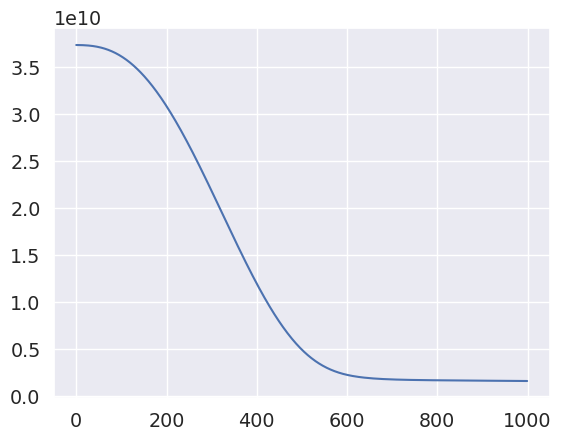

In [337]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
print("R2: %.2f" % best_r2)
plt.plot(history)
plt.show()

# 7. Bagging and Boosting

# 8. Conclusione

In [55]:
for param in parameters:
    if param.print_parameters() is not None:
        print(param.print_parameters())